# EDA for Football Data from Transfermarkt
- Kaggle Data URL

    - https://www.kaggle.com/datasets/davidcariboo/player-scores

## 1. 데이터 설명


- `csv` 파일 설명
    - `apperances` : 선수 출장 기록
    - `club_games` : 클럽별 경기 홈팀, 어웨이팀 정보
    - `clubs` : 리그별 속해 있는 클럽
    - `competitions` : 대회 정보
    - `game_events` : 경기별 이벤트 정보 (카드, 득점, 어시스트 등)
    - `game_lineups` : 경기별 선수의 선발, 교체 명단 등재 여부
    - `games` : 경기에 대한 정보 (시즌, 라운드, 홈팀, 어웨이팀, 순위)
    - `player_valuations` : Transfermarkt 웹사이트에서 매긴 선수의 가치
    - `players` : 선수에 대한 세부 정보


## 2. 데이터 불러오기

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("ticks")

from mplsoccer import Radar, FontManager, grid

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from datetime import datetime
from datetime import timedelta
import missingno as msno

from sklearn.preprocessing import StandardScaler


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option("display.max_columns", None)

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
import plotly.io as pio

pio.renderers.default = "svg"

In [4]:
# 데이터 경로
path = "data/df_merged_total.csv"
df = pd.read_csv(path)

In [5]:
df.head()

player_name_preprocessed  start_season  yellow_cards_preprocessed  \
0             Aarón Martín        2019.0                        2.0   
1        Abdelhamid Sabiri        2019.0                        6.0   
2            Achraf Hakimi        2019.0                        5.0   
3              Adam Bodzek        2019.0                       10.0   
4          Ademola Lookman        2019.0                        0.0   

   red_cards_preprocessed  goals  assists  minutes_played  total_apps  \
0                     0.0    0.0      0.0          1795.0        22.0   
1                     0.0    4.0      1.0          1035.0        24.0   
2                     0.0    5.0     10.0          2717.0        33.0   
3                     0.0    0.0      0.0          2018.0        28.0   
4                     0.0    0.0      0.0           300.0        11.0   

  competition_code  is_major_national_league date_of_birth  \
0       bundesliga                      True    1997-04-22   
1       bundesliga                      True    1996-11-28   
2       bundesliga                      True    1998-11-04   
3       bundesliga                      True    1985-09-07   
4       bundesliga                      True    1997-10-20   

  position_preprocessed    current_club_name  highest_market_value  \
0             Left-Back            Genoa CFC            20000000.0   
1    Attacking Midfield       ACF Fiorentina             4000000.0   
2            Right-Back  Paris Saint-Germain            70000000.0   
3    Defensive Midfield   Fortuna Düsseldorf             1750000.0   
4        Second Striker          Atalanta BC            40000000.0   

   market_value_per_season  country   foot  height_in_cm  \
0               10500000.0    Spain   left         178.0   
1                1700000.0  Morocco  right         186.0   
2               54000000.0  Morocco  right         181.0   
3                 325000.0   Poland  right         184.0   
4               13500000.0  Nigeria  right         174.0   

  player_name_normalized original_player_name first_name_preprocessed  \
0           Aaron Martin         Aarón Martín                   Aaron   
1      Abdelhamid Sabiri    Abdelhamid Sabiri              Abdelhamid   
2          Achraf Hakimi        Achraf Hakimi                  Achraf   
3            Adam Bodzek          Adam Bodzek                    Adam   
4        Ademola Lookman      Ademola Lookman                 Ademola   

  last_name_preprocessed      id player_name_league  games    time  \
0                 Martin  5133.0       Aarón Martín   22.0  1804.0   
1                 Sabiri  6296.0  Abdelhamid Sabiri   24.0  1028.0   
2                 Hakimi  5197.0      Achraf Hakimi   33.0  2709.0   
3                 Bodzek  7140.0        Adam Bodzek   28.0  2023.0   
4                Lookman  5556.0    Ademola Lookman   11.0   281.0   

   goals_season  xG_season  assists_season  xA_season  shots_season  \
0           0.0   0.294448             0.0   3.250888           9.0   
1           4.0   3.468877             1.0   0.232751          43.0   
2           5.0   5.067438            10.0   5.510969          38.0   
3           0.0   0.697913             0.0   0.270701           9.0   
4           0.0   1.185320             0.0   0.983638          11.0   

   key_passes_season  yellow_cards_league  red_cards_league position_league  \
0               32.0                  2.0               0.0           D M S   
1                7.0                  6.0               0.0             M S   
2               36.0                  5.0               0.0           D M S   
3                8.0                 10.0               0.0             M S   
4                7.0                  0.0               0.0             F S   

               team_title  npg_season  npxG_season    xGChain  xGBuildup  \
0                Mainz 05         0.0     0.294448   3.658402   2.195273   
1               Paderborn         3.0     2.711101   1.644770   0.8

In [6]:
# 데이터프레임에서 사용할 컬럼들만 필터링
cols = ['player_name_preprocessed', 'start_season', 'yellow_cards_preprocessed',
       'red_cards_preprocessed', 'goals', 'assists', 'minutes_played',
       'total_apps', 'competition_code', 'date_of_birth', 'position_preprocessed', 'current_club_name',
       'highest_market_value', 'market_value_per_season', 'country', 'foot',
       'height_in_cm', 'xG_season', 'xA_season', 'shots_season', 'key_passes_season',
       'npg_season', 'npxG_season', 'xGChain', 'xGBuildup']
df = df[cols]

# 컬럼명 변경
df.rename(columns={"player_name_preprocessed" : "player_name",
                   'yellow_cards_preprocessed' : "yellow_cards",
                   "red_cards_preprocessed" : "red_cards",
                   "position_preprocessed" : "position",
                   "xG_season" : "xG",
                   "xA_season" : "xA",
                   "shots_season" : "shots",
                   "key_passes_season" : "key_passes",
                   "npg_season" : "npg",
                   "npxG_season" : "npxG"}, 
                   inplace= True)

In [7]:
df.head(3)

player_name  start_season  yellow_cards  red_cards  goals  assists  \
0       Aarón Martín        2019.0           2.0        0.0    0.0      0.0   
1  Abdelhamid Sabiri        2019.0           6.0        0.0    4.0      1.0   
2      Achraf Hakimi        2019.0           5.0        0.0    5.0     10.0   

   minutes_played  total_apps competition_code date_of_birth  \
0          1795.0        22.0       bundesliga    1997-04-22   
1          1035.0        24.0       bundesliga    1996-11-28   
2          2717.0        33.0       bundesliga    1998-11-04   

             position    current_club_name  highest_market_value  \
0           Left-Back            Genoa CFC            20000000.0   
1  Attacking Midfield       ACF Fiorentina             4000000.0   
2          Right-Back  Paris Saint-Germain            70000000.0   

   market_value_per_season  country   foot  height_in_cm        xG        xA  \
0               10500000.0    Spain   left         178.0  0.294448  3.250888   
1                1700000.0  Morocco  right         186.0  3.468877  0.232751   
2               54000000.0  Morocco  right         181.0  5.067438  5.510969   

   shots  key_passes  npg      npxG    xGChain  xGBuildup  
0    9.0        32.0  0.0  0.294448   3.658402   2.195273  
1   43.0         7.0  3.0  2.711101   1.644770   0.885899  
2   38.0        36.0  5.0  5.067438  24.144373  16.293885

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12732 entries, 0 to 12731
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              12732 non-null  object 
 1   start_season             12732 non-null  float64
 2   yellow_cards             12732 non-null  float64
 3   red_cards                12732 non-null  float64
 4   goals                    12732 non-null  float64
 5   assists                  12732 non-null  float64
 6   minutes_played           12732 non-null  float64
 7   total_apps               12732 non-null  float64
 8   competition_code         12732 non-null  object 
 9   date_of_birth            12732 non-null  object 
 10  position                 12732 non-null  object 
 11  current_club_name        12732 non-null  object 
 12  highest_market_value     12732 non-null  float64
 13  market_value_per_season  12732 non-null  float64
 14  country               

In [9]:
# date_of_birth 컬럼 타입 datetime으로 변경
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], format='%Y-%m-%d')

In [10]:
# 시즌별 만 나이 구하는 함수 생성
def calculate_age(born_col, season_col):
    today = datetime.today()
    # 생일이 지나지 않았다면 현재 연도 - 태어난 연도 - 1년 더 빼준다
    age = today.year - born_col.year - ((today.month, today.day) < (born_col.month, born_col.day))
    # return age, season_col

    # 23-24 시즌
    if season_col == (today.year-1):
        return age
    # 22-23 시즌
    elif season_col == (today.year-2):
        return age-1
    # 21-22 시즌
    elif season_col == (today.year-3):
        return age-2
    # 20-21 시즌
    elif season_col == (today.year-4):
        return age-3
    # 19-20 시즌
    else :
        return age-4
    

In [11]:
# 시즌별 만 나이 구하는 함수 적용
df["age"] = df.apply(lambda row : calculate_age(row["date_of_birth"], row["start_season"]), axis=1)

In [12]:
# start_season 컬럼 타입 object로 변경
df["start_season"] = df["start_season"].astype(int).astype(str)

In [13]:
# 결측치 확인
df.isnull().sum()

player_name                0
start_season               0
yellow_cards               0
red_cards                  0
goals                      0
assists                    0
minutes_played             0
total_apps                 0
competition_code           0
date_of_birth              0
position                   0
current_club_name          0
highest_market_value       0
market_value_per_season    0
country                    0
foot                       0
height_in_cm               0
xG                         0
xA                         0
shots                      0
key_passes                 0
npg                        0
npxG                       0
xGChain                    0
xGBuildup                  0
age                        0
dtype: int64

In [14]:
# 450분 이상을 소화한 선수만 필터링
df = df[df["minutes_played"]>=450]

In [15]:
df.shape

(9332, 26)

In [1]:
# 중복값 확인
df[df.duplicated(subset=["player_name", "age", "position", "current_club_name"], keep=False)].sort_values(by="player_name").head(50)

NameError: name 'df' is not defined

In [17]:
# 합계를 계산할 컬럼들과 평균을 계산할 컬럼들을 정의
columns_to_sum = ['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', "total_apps",
                  'xG', 'xA', 'shots', 'key_passes', 'npg', 'npxG', 'xGChain', 'xGBuildup']
# columns_to_average = []

# 중복된 값을 확인하기 위해 키 컬럼들로 그룹화
grouped_df = df.groupby(['player_name', 'start_season', 'age', 'current_club_name'])

# 필요한 컬럼들을 합산하고 나머지 컬럼들은 평균을 계산
df_no_duplicate = grouped_df.agg({
    **{col: 'sum' for col in columns_to_sum},  # 필요한 컬럼들을 합산
    # **{col: lambda x: x.sum() / 2 for col in columns_to_average},  # 나머지 컬럼들은 합계 후 2로 나누어 평균 계산
    # 범주형 컬럼은 첫 번째 값을 유지
    'competition_code': 'first',
    'position' : 'first',
    'height_in_cm' : 'first',
    'highest_market_value' : 'first', 
    'market_value_per_season' : 'first'
}).reset_index()


In [18]:
df_no_duplicate.head(3)

player_name start_season  age       current_club_name  yellow_cards  \
0   Aaron Connolly         2019   20  Brighton & Hove Albion           0.0   
1   Aaron Connolly         2020   21  Brighton & Hove Albion           0.0   
2  Aaron Cresswell         2019   30         West Ham United           7.0   

   red_cards  goals  assists  minutes_played  total_apps        xG        xA  \
0        0.0    3.0      2.0          1261.0        24.0  4.553528  0.562017   
1        0.0    2.0      1.0           791.0        17.0  4.464138  0.160784   
2        0.0    3.0      0.0          2730.0        31.0  1.032539  3.006656   

   shots  key_passes  npg      npxG   xGChain  xGBuildup competition_code  \
0   36.0         6.0  3.0  4.553528  4.356781   0.354199   premier-league   
1   23.0         6.0  2.0  4.464138  4.783492   0.191225   premier-league   
2   18.0        26.0  3.0  1.032539  6.834942   4.891464   premier-league   

         position  height_in_cm  highest_market_value  market_value_per_season  
0  Centre-Forward         174.0             7000000.0                4000000.0  
1  Centre-Forward         174.0             7000000.0                7000000.0  
2       Left-Back         170.0            12000000.0                6500000.0

In [30]:
df[df["player_name"]=="Gabriel Magalhães"]

player_name start_season  yellow_cards  red_cards  goals  \
5865   Gabriel Magalhães         2020           4.0        0.0    2.0   
5866   Gabriel Magalhães         2020           4.0        0.0    2.0   
5867   Gabriel Magalhães         2020           4.0        0.0    2.0   
6384   Gabriel Magalhães         2021           8.0        0.0    5.0   
6385   Gabriel Magalhães         2021           8.0        0.0    5.0   
6386   Gabriel Magalhães         2021           8.0        0.0    5.0   
6889   Gabriel Magalhães         2022           5.0        0.0    3.0   
6890   Gabriel Magalhães         2022           5.0        0.0    3.0   
6891   Gabriel Magalhães         2022           5.0        0.0    3.0   
7432   Gabriel Magalhães         2023           4.0        0.0    4.0   
7433   Gabriel Magalhães         2023           4.0        0.0    4.0   
7434   Gabriel Magalhães         2023           4.0        0.0    4.0   
7435   Gabriel Magalhães         2023           4.0        0.0    4.0   
10377  Gabriel Magalhães         2019           3.0        0.0    1.0   
10378  Gabriel Magalhães         2019           3.0        0.0    1.0   
10379  Gabriel Magalhães         2019           3.0        0.0    1.0   

       assists  minutes_played  total_apps competition_code date_of_birth  \
5865       0.0          1997.0        23.0   premier-league    1997-12-19   
5866       0.0          1997.0        23.0   premier-league    1997-12-19   
5867       0.0          1997.0        23.0   premier-league    1997-12-19   
6384       0.0          3067.0        35.0   premier-league    1997-12-19   
6385       0.0          3067.0        35.0   premier-league    1997-12-19   
6386       0.0          3067.0        35.0   premier-league    1997-12-19   
6889       0.0          3411.0        38.0   premier-league    1997-12-19   
6890       0.0          3411.0        38.0   premier-league    1997-12-19   
6891       0.0          3411.0        38.0   premier-league    1997-12-19   
7432       0.0          3044.0        36.0   premier-league    1997-12-19   
7433       0.0          3044.0        36.0   premier-league    1997-12-19   
7434       0.0          3044.0        36.0   premier-league    1997-12-19   
7435       0.0          3044.0        36.0   premier-league    1997-12-19   
10377      0.0          2087.0        24.0          ligue-1    1997-12-19   
10378      0.0          2087.0        24.0          ligue-1    1997-12-19   
10379      0.0          2087.0        24.0          ligue-1    1997-12-19   

          position current_club_name  highest_market_value  \
5865   Centre-Back        Arsenal FC            70000000.0   
5866   Centre-Back        Arsenal FC            70000000.0   
5867   Centre-Back        Arsenal FC            70000000.0   
6384   Centre-Back        Arsenal FC            70000000.0   
6385   Centre-Back        Arsenal FC            70000000.0   
6386   Centre-Back        Arsenal FC            70000000.0   
6889   Centre-Back        Arsenal FC            70000000.0   
6890   Centre-Back        Arsenal FC            70000000.0   
6891   Centre-Back        Arsenal FC            70000000.0   
7432   Centre-Back        Arsenal FC            70000000.0   
7433   Centre-Back        Arsenal FC            70000000.0   
7434   Centre-Back        Arsenal FC            70000000.0   
7435   Centre-Back        Arsenal FC            70000000.0   
10377  Centre-Back        Arsenal FC            70000000.0   
10378  Centre-Back        Arsenal FC            70000000.0   
10379  Centre-Back        Arsenal FC            70000000.0   

       market_value_per_season country  foot  height_in_cm         xG  \
5865                25000000.0  Brazil  left         190.0   9.653351   
5866                25000000.0  Brazil  left         190.0   1.564549   
5867                25000000.0  Brazil  left         190.0   3.252447   
6384                38000000.0  Brazil  left         190.0  10.153562   
6385                38000000.0  Brazil  l

In [26]:
df_no_duplicate.sort_values(by="total_apps", ascending=False)

player_name start_season  age   current_club_name  yellow_cards  \
2837   Gabriel Magalhães         2023   26          Arsenal FC          16.0   
2836   Gabriel Magalhães         2022   25          Arsenal FC          15.0   
2835   Gabriel Magalhães         2021   24          Arsenal FC          24.0   
7237         Raúl García         2019   34     Athletic Bilbao          33.0   
4731                Koke         2020   29  Atlético de Madrid          18.0   
...                  ...          ...  ...                 ...           ...   
3875        Jessy Moulin         2019   34        ESTAC Troyes           0.0   
8486        Tomas Vaclik         2020   32  Olympiacos Piraeus           0.0   
6063  Michele Cerofolini         2022   24    Frosinone Calcio           0.0   
4428         Jérémy Pied         2019   31          LOSC Lille           2.0   
765      Antonio Mirante         2019   37            AC Milan           0.0   

      red_cards  goals  assists  minutes_played  total_apps         xG  \
2837        0.0   16.0      0.0         12176.0       144.0  19.682356   
2836        0.0    9.0      0.0         10233.0       114.0  31.044823   
2835        0.0   15.0      0.0          9201.0       105.0  22.560608   
7237        0.0   45.0      3.0          8631.0       105.0  11.367468   
4731        0.0    2.0      4.0          6050.0        74.0   2.113915   
...         ...    ...      ...             ...         ...        ...   
3875        0.0    0.0      0.0           450.0         5.0   0.000000   
8486        0.0    0.0      0.0           450.0         5.0   0.000000   
6063        0.0    0.0      0.0           450.0         5.0   0.000000   
4428        0.0    0.0      0.0           450.0         5.0   0.073686   
765         0.0    0.0      0.0           450.0         5.0   0.000000   

             xA  shots  key_passes   npg       npxG    xGChain  xGBuildup  \
2837  10.528546  154.0        79.0  15.0  19.682356  48.058205  27.055771   
2836  13.759533  188.0        95.0  28.0  30.283663  61.454336  29.708758   
2835  10.246841  144.0        80.0  17.0  21.038268  41.823953  20.320044   
7237   2.180336   89.0        33.0   8.0   6.164786   8.275068   2.723901   
4731   2.796461   17.0        39.0   1.0   2.113915  16.931591  14.245880   
...         ...    ...         ...   ...        ...        ...        ...   
3875   0.000000    0.0         0.0   0.0   0.000000   0.312316   0.312316   
8486   0.000000    0.0         0.0   0.0   0.000000   0.466231   0.466231   
6063   0.000000    0.0         0.0   0.0   0.000000   0.283438   0.283438   
4428   0.169821    2.0         2.0   0.0   0.073686   0.727505   0.653819   
765    0.000000    0.0         0.0   0.0   0.000000   0.854620   0.854620   

     competition_code          position  height_in_cm  highest_market_value  \
2837   premier-league       Centre-Back         190.0            70000000.0   
2836   premier-league       Centre-Back         190.0            70000000.0   
2835   premier-league       Centre-Back         190.0            70000000.0   
7237           laliga    Centre-Forward         184.0            16000000.0   
4731           laliga  Central Midfield         176.0            70000000.0   
...               ...               ...           ...                   ...   
3875          ligue-1        Goalkeeper         184.0             1000000.0   
8486           laliga        Goalkeeper         189.0            18000000.0   
6063          serie-a        Goalkeeper         188.0              700000.0   
4428          ligue-1        Right-Back         173.0             3500000.0   
765           serie-a        Goalkeeper         193.0             6000000.0   

      market_value_per_season  
2837               70000000.0  
2836               55000000.0  
2835               38000000.0  
7237                6000000.0  
4731               60000000.0  
...                       ...  
3875                 250000.0  
8486                4000000.0  
6

### 2-1. `.describe()` 확인

In [20]:
df_no_duplicate.describe()

age  yellow_cards    red_cards        goals      assists  \
count  9167.000000   9167.000000  9167.000000  9167.000000  9167.000000   
mean     27.210756      3.616123     0.087924     2.452493     1.901604   
std       4.175832      2.807873     0.301848     3.805308     2.419041   
min      17.000000      0.000000     0.000000     0.000000     0.000000   
25%      24.000000      1.000000     0.000000     0.000000     0.000000   
50%      27.000000      3.000000     0.000000     1.000000     1.000000   
75%      30.000000      5.000000     0.000000     3.000000     3.000000   
max      44.000000     33.000000     3.000000    45.000000    22.000000   

       minutes_played   total_apps           xG           xA        shots  \
count     9167.000000  9167.000000  9167.000000  9167.000000  9167.000000   
mean      1753.645795    25.347333     2.618808     1.842473    22.465583   
std        819.399208     8.373470     3.656568     2.062245    22.686699   
min        450.000000     5.000000     0.000000     0.000000     0.000000   
25%       1073.000000    19.000000     0.432282     0.387441     7.000000   
50%       1705.000000    26.000000     1.306676     1.175714    16.000000   
75%       2386.000000    32.000000     3.218502     2.557024    31.000000   
max      12176.000000   144.000000    37.924069    20.620713   238.000000   

        key_passes          npg         npxG      xGChain    xGBuildup  \
count  9167.000000  9167.000000  9167.000000  9167.000000  9167.000000   
mean     16.746482     2.227664     2.385441     7.273074     4.395966   
std      16.425092     3.338524     3.189370     5.699324     3.539857   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       5.000000     0.000000     0.427153     3.208806     1.916855   
50%      12.000000     1.000000     1.253681     5.773349     3.466614   
75%      23.000000     3.000000     2.998733     9.708166     5.834587   
max     133.000000    38.000000    34.135185    61.454336    29.708758   

       height_in_cm  highest_market_value  market_value_per_season  
count   9167.000000          9.167000e+03             9.167000e+03  
mean     182.819897          2.274593e+07             1.322463e+07  
std        6.565583          2.513287e+07             1.752804e+07  
min      162.000000          3.000000e+05             1.000000e+05  
25%      178.000000          6.000000e+06             2.500000e+06  
50%      183.000000          1.500000e+07             6.500000e+06  
75%      188.000000          3.000000e+07             1.700000e+07  
max      202.000000          2.000000e+08             1.800000e+08

In [21]:
df_no_duplicate.describe(include="object")

player_name start_season current_club_name competition_code  \
count         9167         9167              9167             9167   
unique        3515            5               237                5   
top         Danilo         2022  Newcastle United          serie-a   
freq             9         1875               129             1986   

           position  
count          9167  
unique           13  
top     Centre-Back  
freq           1830

### 2-2. 분포 확인

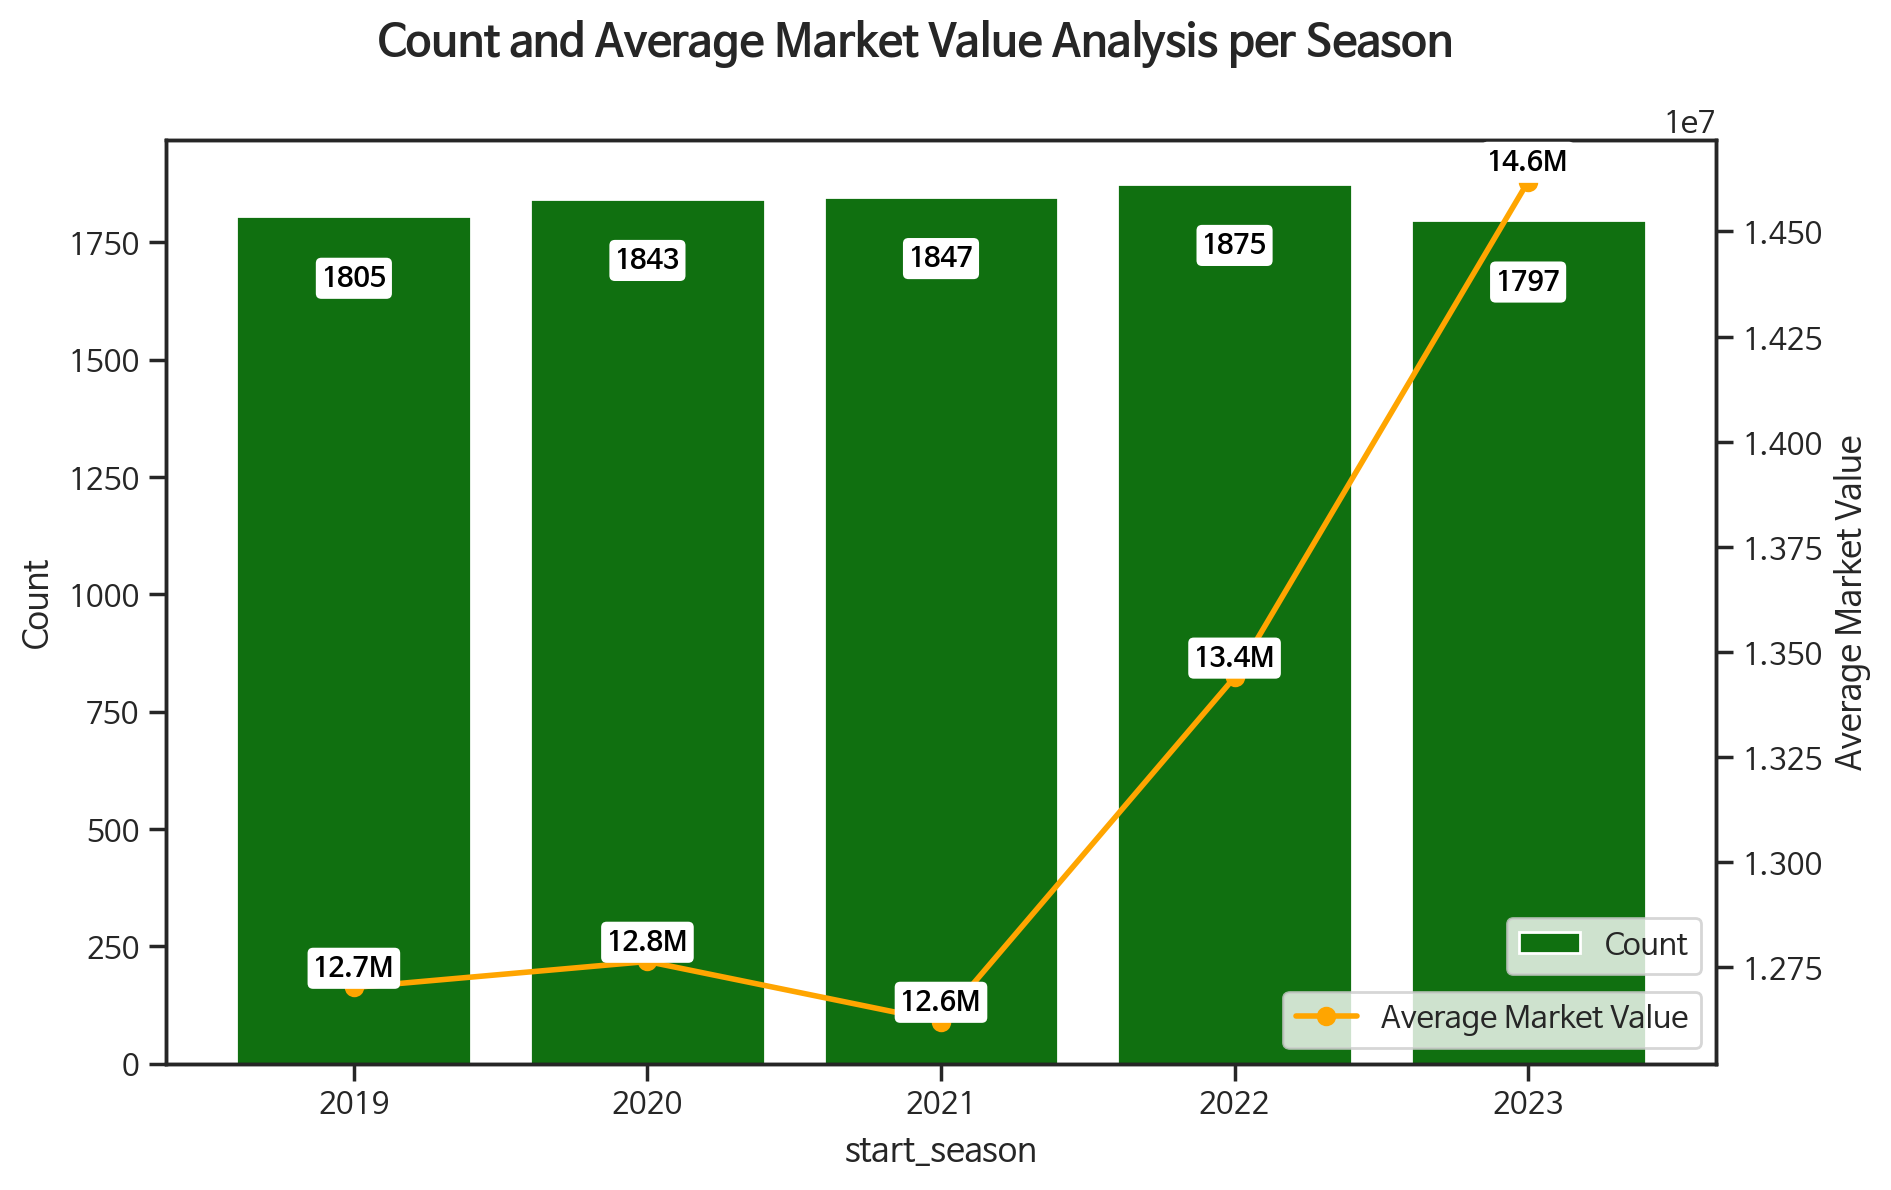

In [22]:
# start_season별 평균 몸값 계산
average_value_per_season = df_no_duplicate.groupby('start_season')['market_value_per_season'].mean()

# 기본 figure 설정
fig, ax1 = plt.subplots(figsize=(10, 6))

# 큰 제목 추가
plt.suptitle('Count and Average Market Value Analysis per Season', fontsize=16, fontweight='bold')

# 첫 번째 y축: countplot 생성 (hue를 제거하고 label 추가)
countplot = sns.countplot(data=df_no_duplicate, x="start_season", ax=ax1, color='green', label='Count')
ax1.set_ylabel('Count')
# ax1.set_title('Count and Average Market Value per Start Season')

# 각 countplot 막대에 값 표시 (밑으로 조금 내리기)
for p in countplot.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width() / 2., height - 100, int(height), 
             ha='center', va='top', fontsize=10, fontweight='bold', color='black', 
             bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

# 두 번째 y축 설정
ax2 = ax1.twinx()
lineplot, = ax2.plot(average_value_per_season.index, average_value_per_season.values, 
                     marker='o', color='orange', linewidth=2, label='Average Market Value')
ax2.set_ylabel('Average Market Value')

# 각 lineplot에 값 표시 (위로 올리기)
for i, value in enumerate(average_value_per_season.values):
    ax2.text(average_value_per_season.index[i], value + 10000, f'{round(value/1000000, 1)}M', 
             color='black', ha='center', va='bottom', fontsize=10, fontweight='bold', 
             bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

# 범례 추가
ax1.legend(loc='lower right', bbox_to_anchor=(1, 0.08))
ax2.legend(loc='lower right')

# 그래프 보여주기
plt.show()


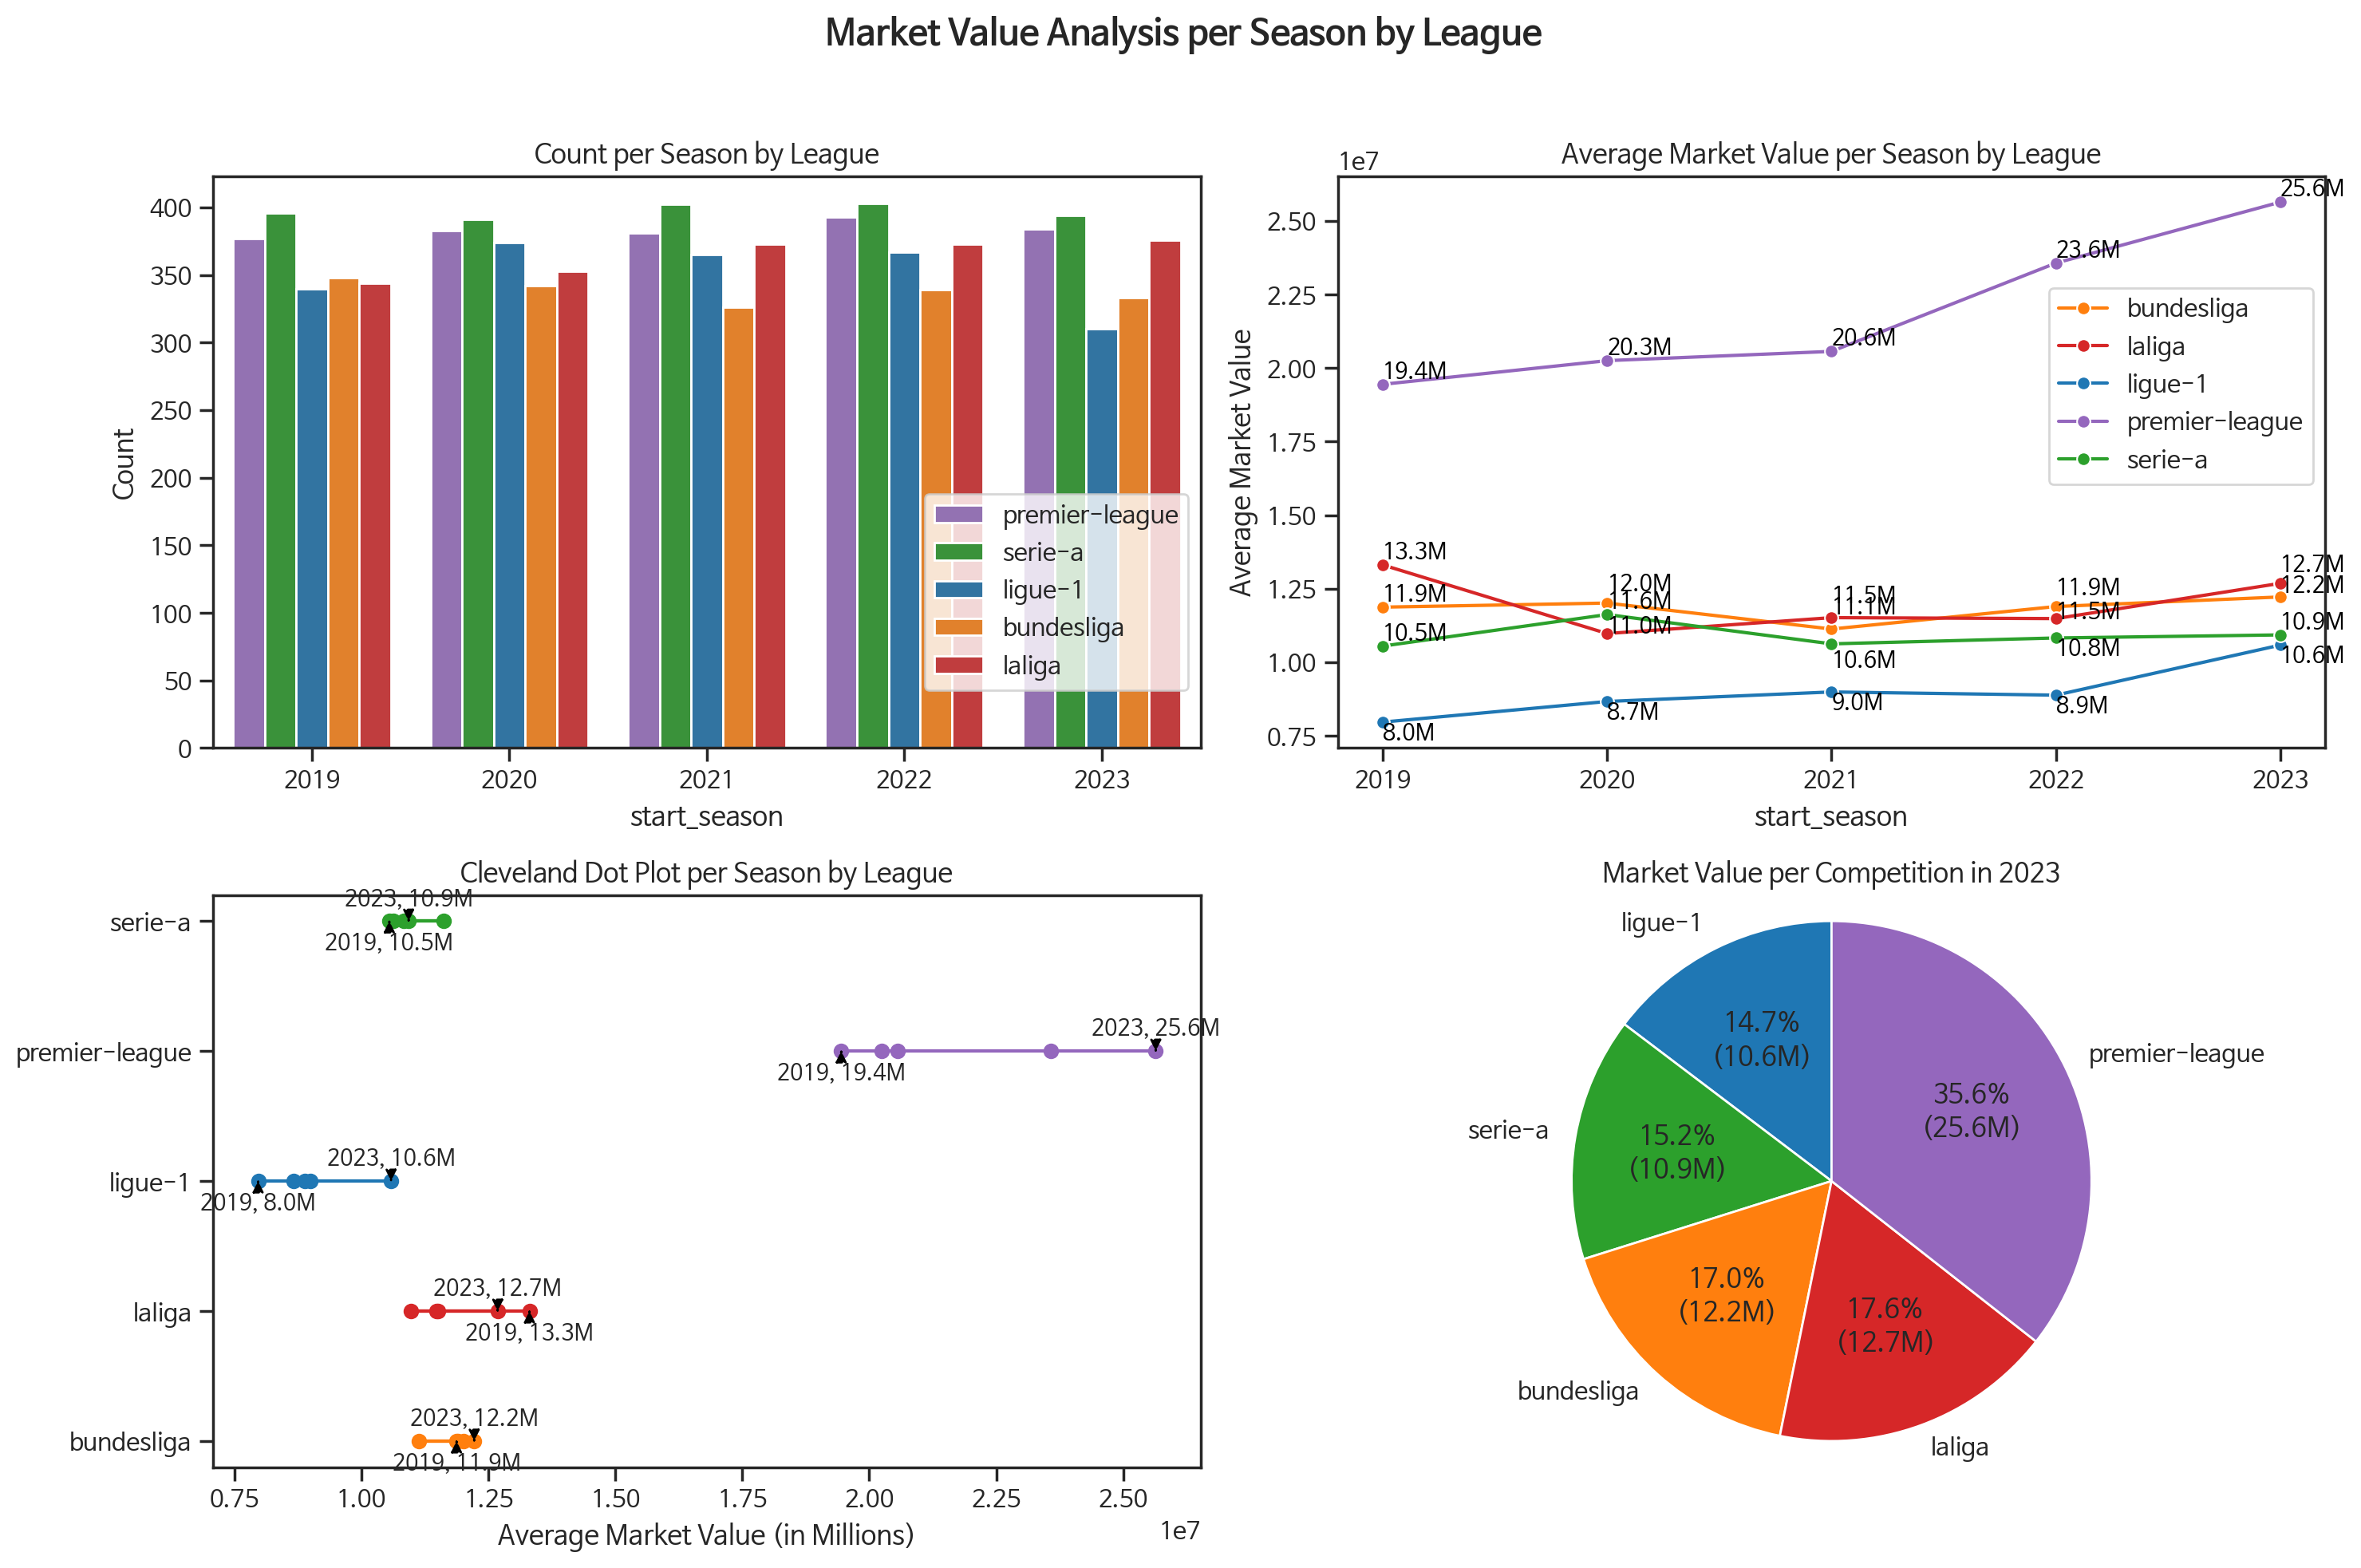

In [23]:
# 2x2 서브플롯으로 4개의 플롯을 표시하는 코드에 Cleveland dot plot 내용 추가

# 공통 색상 팔레트 정의
palette = {
    'laliga': '#d62728',
    'bundesliga': '#ff7f0e',
    'premier-league': '#9467bd', 
    'serie-a': '#2ca02c',
    'ligue-1': '#1f77b4',
    'liga-portugal-bwin': '#8c564b'
}

def autopct_with_values(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    return f"{pct:.1f}%\n({absolute / 1000000:.1f}M)"

# figure 설정 (2x2 subplots)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Market Value Analysis per Season by League', fontsize=16, fontweight='bold')

# 첫 번째 plot: countplot
sns.countplot(data=df_no_duplicate, x="start_season", hue="competition_code", palette=palette, ax=axes[0, 0])
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Count per Season by League')

average_value_per_season = df_no_duplicate.groupby(['start_season', 'competition_code'])['market_value_per_season'].mean().reset_index()
# competition_code를 카테고리로 변환하여 순서대로 숫자 할당
average_value_per_season['competition_code_numeric'] = average_value_per_season['competition_code'].astype('category').cat.codes


# 두 번째 plot: lineplot (평균 몸값)
sns.lineplot(data=average_value_per_season, x="start_season", y="market_value_per_season", hue="competition_code", marker='o', palette=palette, ax=axes[0, 1])

# 데이터 포인트에 값 표시 (값이 가까울 때 위치 조정)
for i in range(average_value_per_season.shape[0]):
    start_season = average_value_per_season.loc[i, 'start_season']
    market_value = average_value_per_season.loc[i, 'market_value_per_season']
    competition = average_value_per_season.loc[i, 'competition_code']
    
    # 특정 조건에 따라 위치 조정
    verticalalignment = 'bottom'
    offset = 0
    if start_season in ["2020", "2022"]:
        if competition == 'bundesliga':
            offset = 200000  # Bundesliga 값을 위로 올림
        elif competition == 'laliga':
            offset = -200000  # LaLiga 값을 아래로 내림
    
    if (start_season == "2021"):
        if ((competition == "bundesliga") | (competition == "laliga")):
            offset = 300000
        elif competition == "serie-a": 
            offset = -1000000

    if ((start_season == "2022") & (competition == "serie-a")) | (competition == "ligue-1"):
        verticalalignment = 'top'

    if (start_season == "2023"):
        if (competition == "laliga"):
            offset = 200000
        elif (competition == "bundesliga"):
            offset = -50000

    adjusted_y = market_value + offset

    axes[0, 1].text(x=start_season, 
                 y=adjusted_y, 
                 s=f'{round(market_value / 1000000, 1)}M', 
                 color='black', 
                 fontsize=10, 
                 verticalalignment=verticalalignment)

axes[0, 1].set_ylabel('Average Market Value')
axes[0, 1].set_title('Average Market Value per Season by League')

# 세 번째 plot: Cleveland dot plot
for competition in average_value_per_season['competition_code'].unique():
    subset = average_value_per_season[average_value_per_season['competition_code'] == competition]
    axes[1, 0].plot(subset['market_value_per_season'], subset['competition_code_numeric'], 'o-', label=competition, color=palette[competition])
    # 연도별로 각 점에 레이블을 표시 (start_season)
    for i in range(subset.shape[0]):

        season_value = None
        y_offset = 0  # 기본 y_offset은 0으로 설정

        if i in [0, 4]:
            season_value = f"{subset['start_season'].iloc[i]}, {round(subset['market_value_per_season'].iloc[i] / 1000000, 1)}M"
            y_offset = -0.17 if i == 0 else 0.17  # 데이터 포인트 위/아래로 조정

        # 데이터 포인트와 텍스트를 연결하는 선 그리기
        axes[1, 0].annotate(
            season_value,
            xy=(subset['market_value_per_season'].iloc[i], subset['competition_code_numeric'].iloc[i]),
            xytext=(subset['market_value_per_season'].iloc[i], subset['competition_code_numeric'].iloc[i] + y_offset),
            fontsize=10,
            ha='center',
            va='center',
            arrowprops=dict(arrowstyle='-|>', color='black', lw=1, linestyle='--')
        )        

        
axes[1, 0].set_yticks(average_value_per_season['competition_code_numeric'].unique())
axes[1, 0].set_yticklabels(average_value_per_season['competition_code'].unique())
axes[1, 0].set_xlabel('Average Market Value (in Millions)')
axes[1, 0].set_title('Cleveland Dot Plot per Season by League')

# 네 번째 plot: pie chart
data_2023_sorted = average_value_per_season[average_value_per_season['start_season'] == "2023"].sort_values(by='market_value_per_season', ascending=True)
colors = [palette[comp] for comp in data_2023_sorted['competition_code']]
wedges, texts, autotexts = axes[1, 1].pie(data_2023_sorted['market_value_per_season'], 
               labels=data_2023_sorted['competition_code'], 
               autopct=lambda pct: autopct_with_values(pct, data_2023_sorted['market_value_per_season']), 
               startangle=90, 
               colors=colors)

# 글자 위치를 중심에서 바깥쪽으로 조정
# autotexts[0].set_position((1.35 * autotexts[0].get_position()[0], 1.35 * autotexts[0].get_position()[1]))

axes[1, 1].set_title('Market Value per Competition in 2023')
axes[1, 1].axis('equal')


# 범례 위치 조정
axes[0, 0].legend(loc='lower right', bbox_to_anchor=(1, 0.08))
axes[0, 1].legend(loc='lower right', bbox_to_anchor=(1, 0.44))

# 레이아웃 조정
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3. 이상치 확인
- `boxplot` 그려서 확인

In [24]:
# num_cols = df_no_duplicate.select_dtypes(include="number").columns.drop("last_season").tolist()
num_cols = df_no_duplicate.select_dtypes(include="number").columns.tolist()

print(num_cols)
print(len(num_cols))

['age', 'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', 'total_apps', 'xG', 'xA', 'shots', 'key_passes', 'npg', 'npxG', 'xGChain', 'xGBuildup', 'height_in_cm', 'highest_market_value', 'market_value_per_season']
18


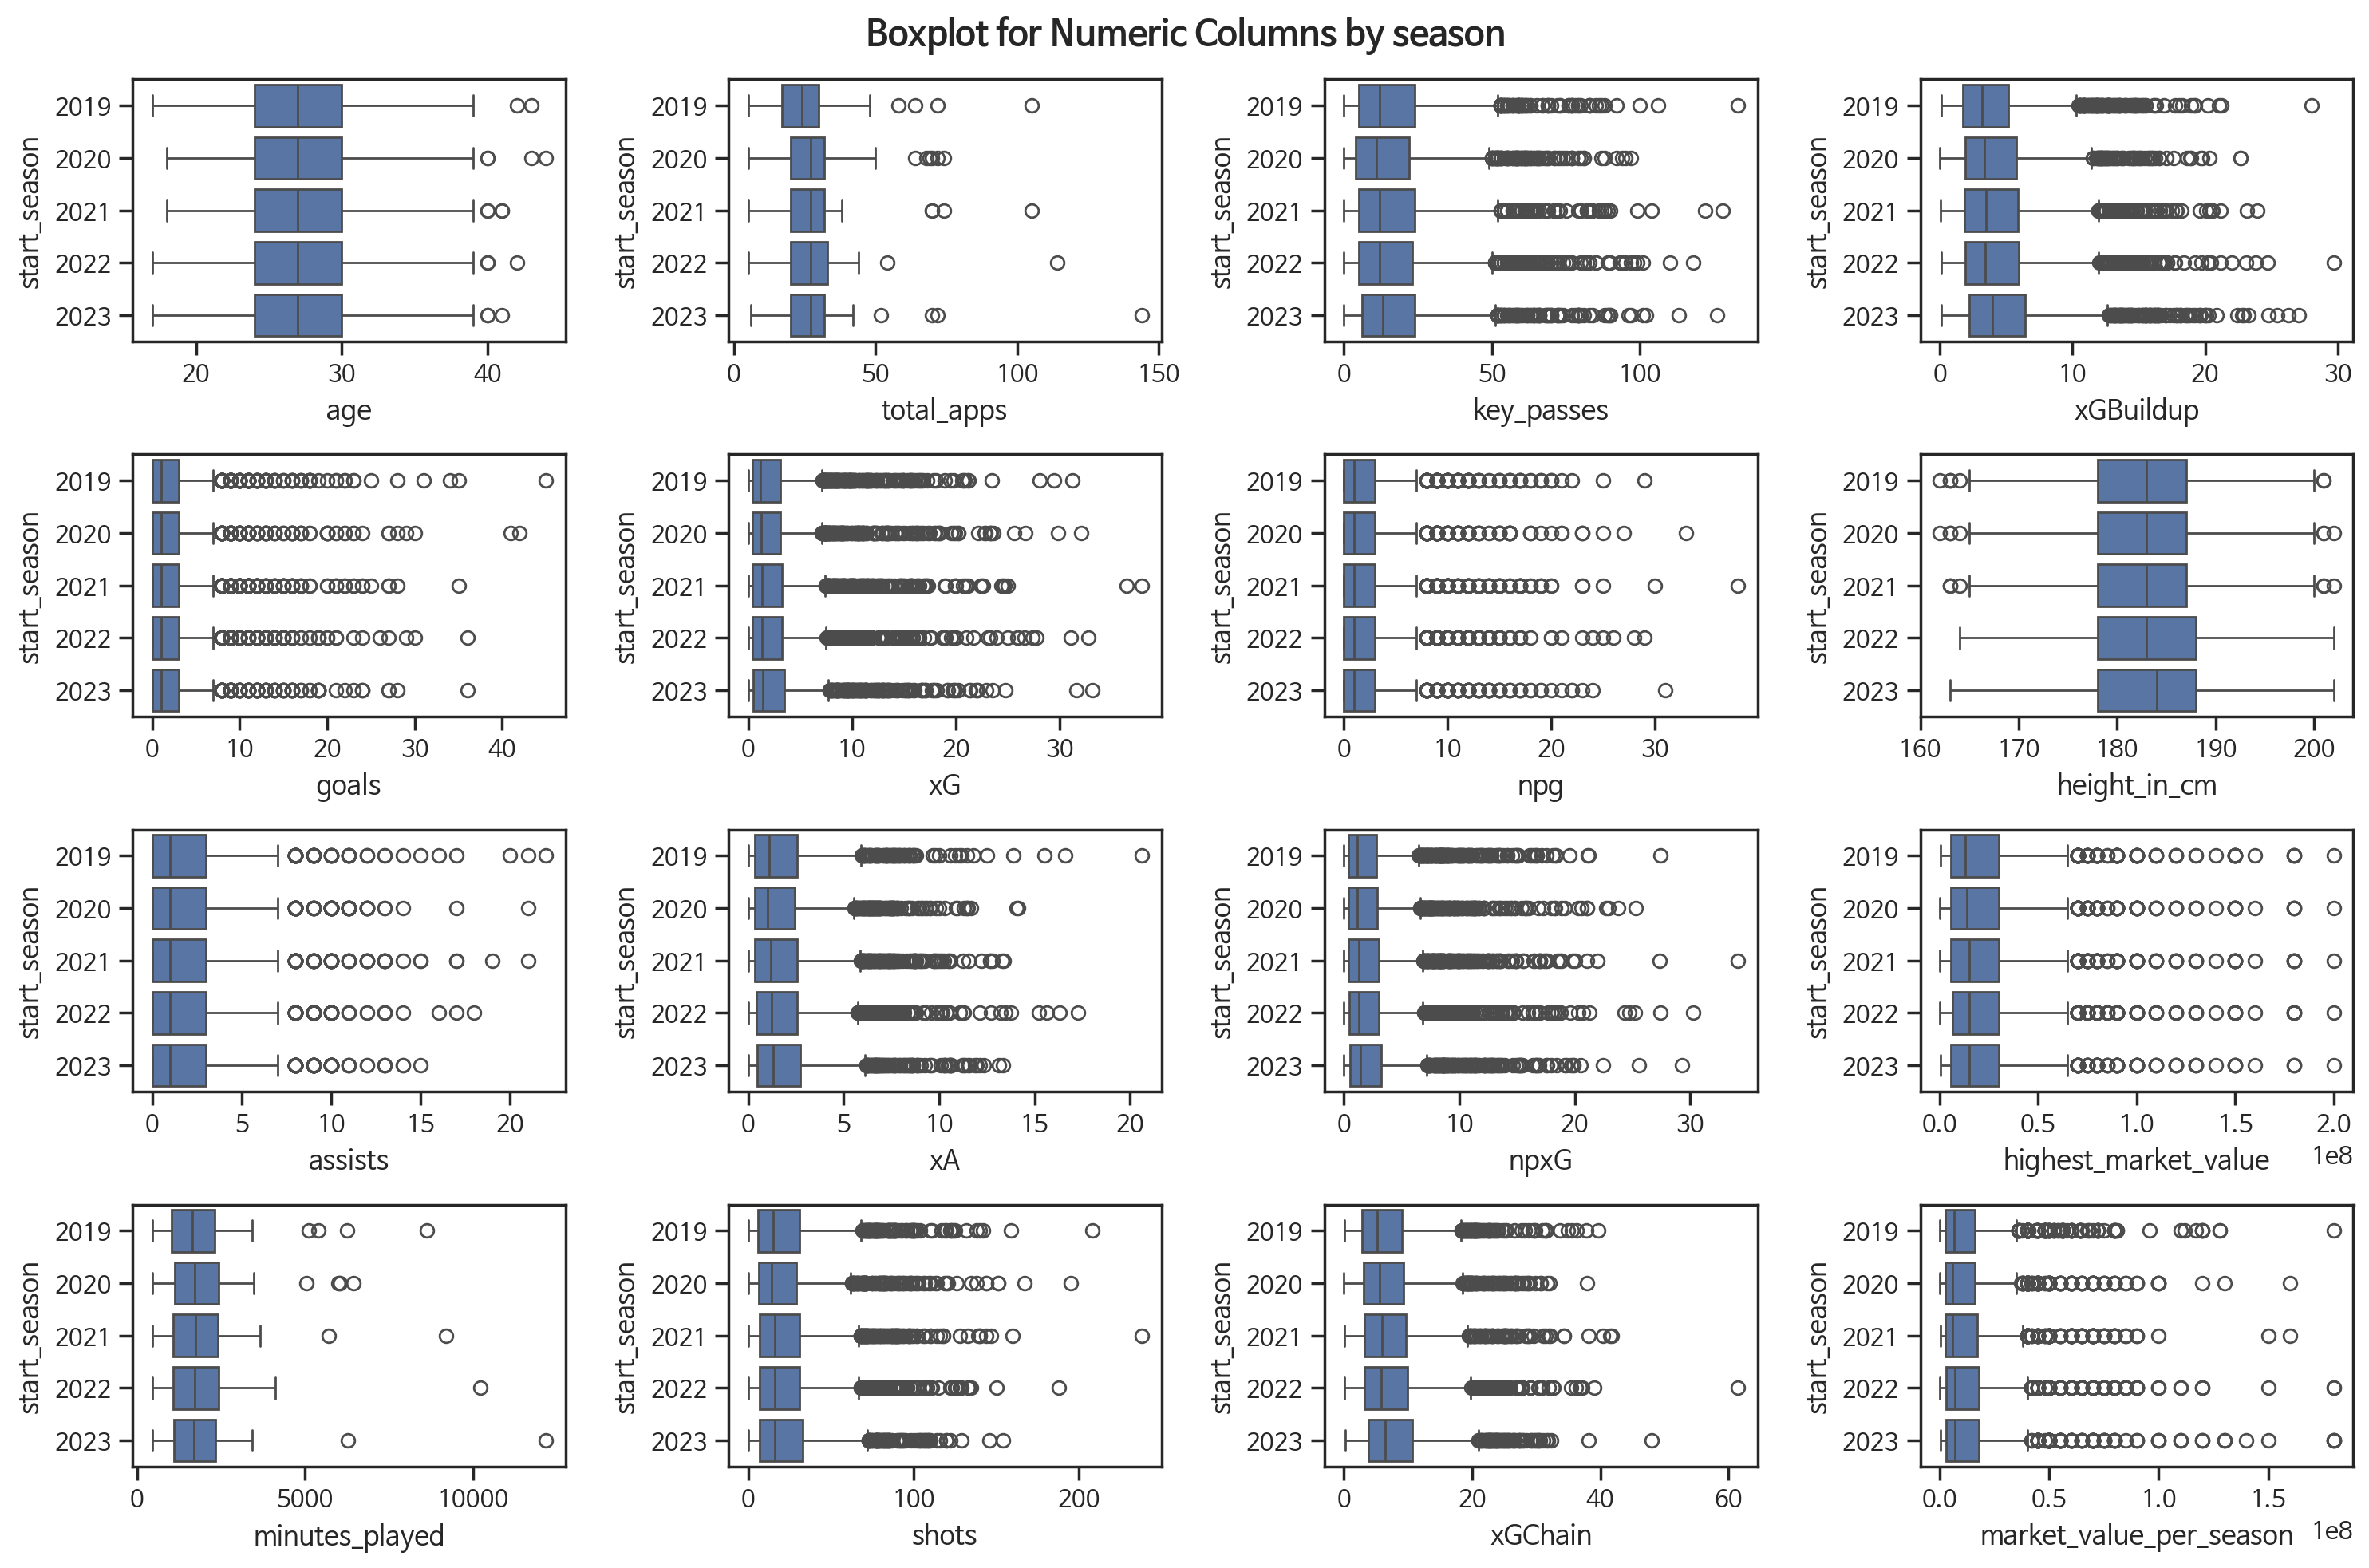

In [25]:
# num_cols에서 yellow_cards, red_cards 제거한 것 num_cols2에 선언
del num_cols[1:3]

# subplot 생성
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

for col, ax in zip(num_cols, axes):
    sns.boxplot(data=df_no_duplicate, x=col, ax=ax, y="start_season")
    # sns.stripplot(data=df_no_duplicate, x=col, ax=ax, y="last_season", hue="foot")

plt.suptitle("Boxplot for Numeric Columns by season", fontsize=16, fontweight='bold')

fig.tight_layout()
plt.show()

### 이상치 확인 결과
- 전반적으로 `start_season`에 따라 비슷한 결과

- `goals`, `assists`, `market_value` 등 다양한 곳에서 이상치 존재
    - 그러나 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라지게 나타난다
- 결론 : 이상치 따로 처리하지 않음

## 4. 상관관계 확인

In [113]:
num_cols = df.select_dtypes(include="number").columns.tolist()
df_corr = round(df[num_cols].corr(), 2)

df_corr.style.background_gradient()

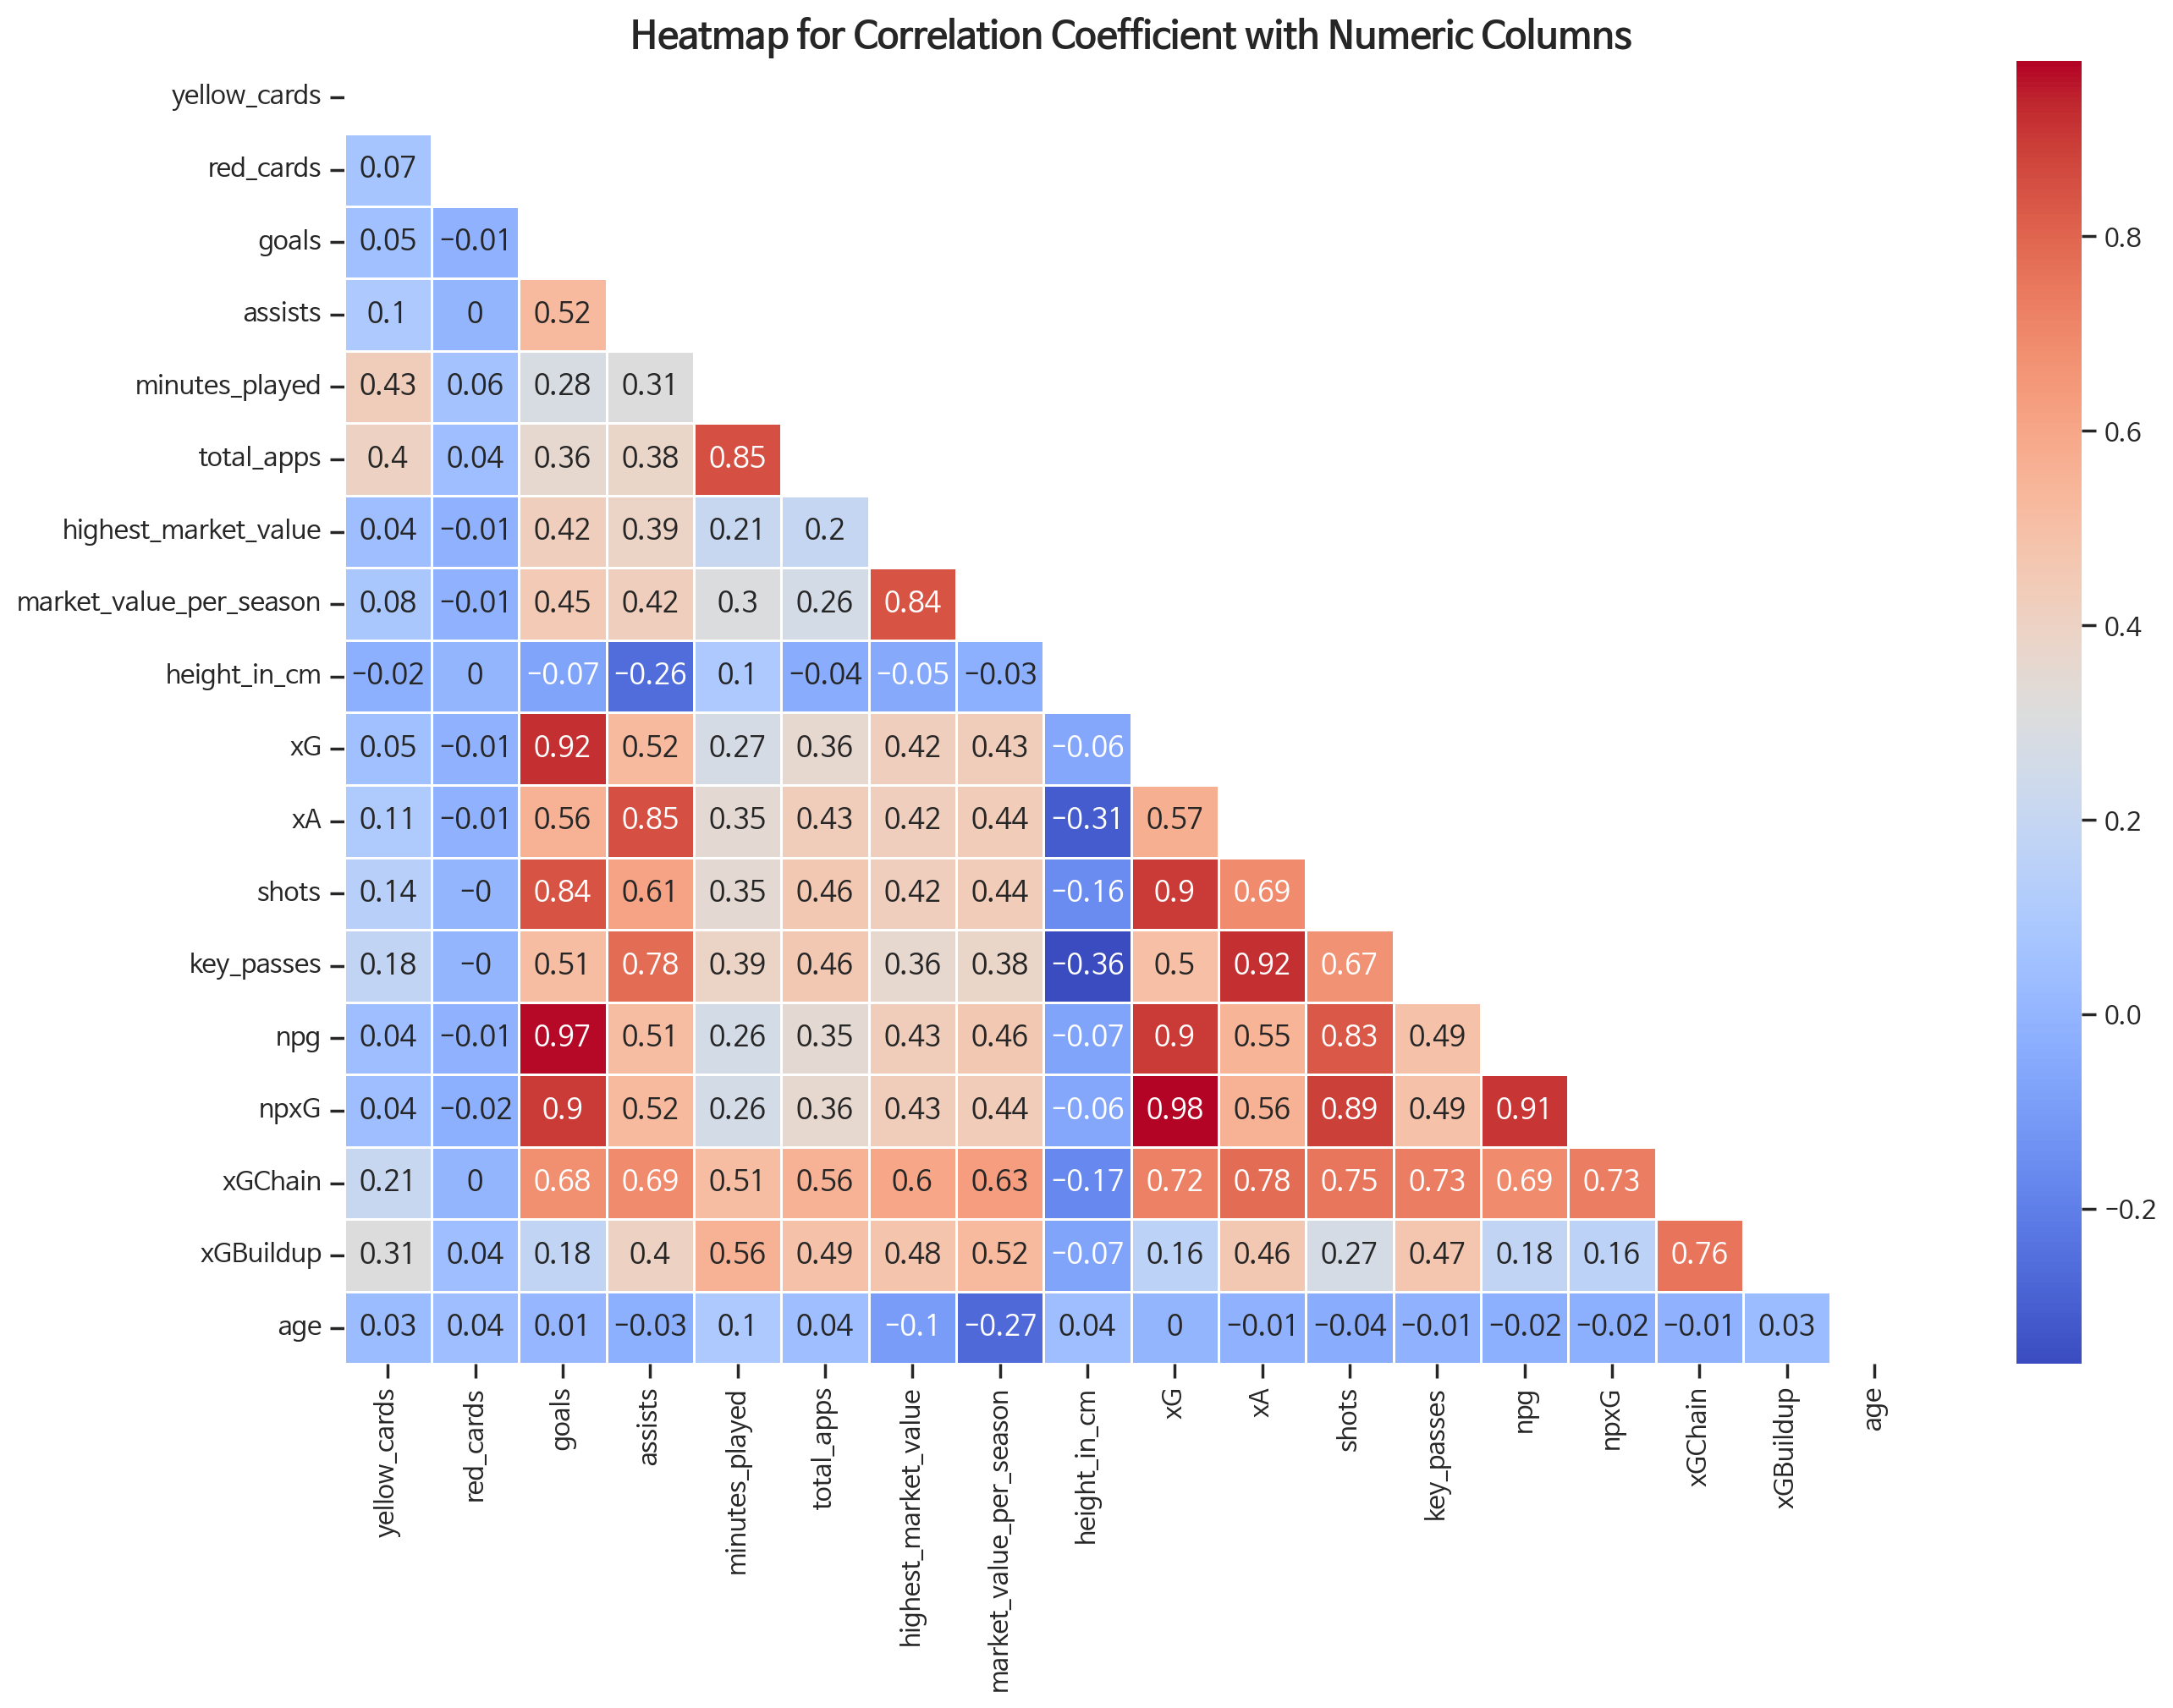

In [114]:
plt.figure(figsize=(15,10))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')

plt.title("Heatmap for Correlation Coefficient with Numeric Columns", fontsize=16, fontweight='bold')
plt.show()

### 4-1. 상관관계 결과
- 매우 강한 상관관계 (0.8 이상)
    - `npg` - `goals`
    - `xG` - `npxG`
    - `xG`- `goals`
    - `xA` - `key_passes`
    - `npxG` - `goals`
    - `goals` - `shots`
    - `xG` - `shots`
    - `shots` - `npxG`
    - `shots` - `npg`
    - `npg` - `npxG`
    - `assists` - `xA`
    - `minutes_played` - `total_apps`
    - `highest_market_value` - `market_value_per_season`
- 강한 상관관계 (0.6 ~ 0.8)
    - `assists` - `key_passes`
    - `xG` - `xGChain`
    - `xA` - `xGChain`
    - `shots` - `xGChain`
    - `key_passes` - `xGChaing`
    - `npxG` - `xGChain`
    - `xGChain` - `xGBuildup`
    - `assists` - `xGChain`
    - `goals` - `xGChain`
    - `market_value_per_season` - `xGChain`
    - `highest_market_value` - `xGChain`
    - `shots` - `key_passes`
    - `xA`- `shots`
- 음의 상관관계 (-0.2 ~ -0.4)
    - `key_passes` - `height_in_cm`
    - `xA` - `height_in_cm`
    - `assists` - `height_in_cm`
    - `age` - `market_value_per_season`

### 4-2. 상관관계 높은 변수들 분포 확인
- 상관관계가 높은 변수 관계 8가지 분포 시각화해본다

    - 매우 강한 상관관계 (0.8 이상)
        - `npg` - `goals`
        - `xG` - `npxG`
        - `xG`- `goals`
        - `xA` - `key_passes`
        - `npxG` - `goals`
        - `goals` - `shots`
        - `xG` - `shots`
        - `shots` - `npxG`

In [129]:
# 상관관계 높은 변수들끼리 짝지워 high_corr에 선언
high_corr = [("xG", "npxG"),
             ("npg", "goals"), 
             ("xG", "goals"), 
             ("xA", "key_passes"),
             ("npxG", "goals"),
             ("xG", "shots"),
             ("shots", "npxG"),
             ("goals", "shots"),
             ]
high_corr

[('xG', 'npxG'),
 ('npg', 'goals'),
 ('xG', 'goals'),
 ('xA', 'key_passes'),
 ('npxG', 'goals'),
 ('xG', 'shots'),
 ('shots', 'npxG'),
 ('goals', 'shots')]

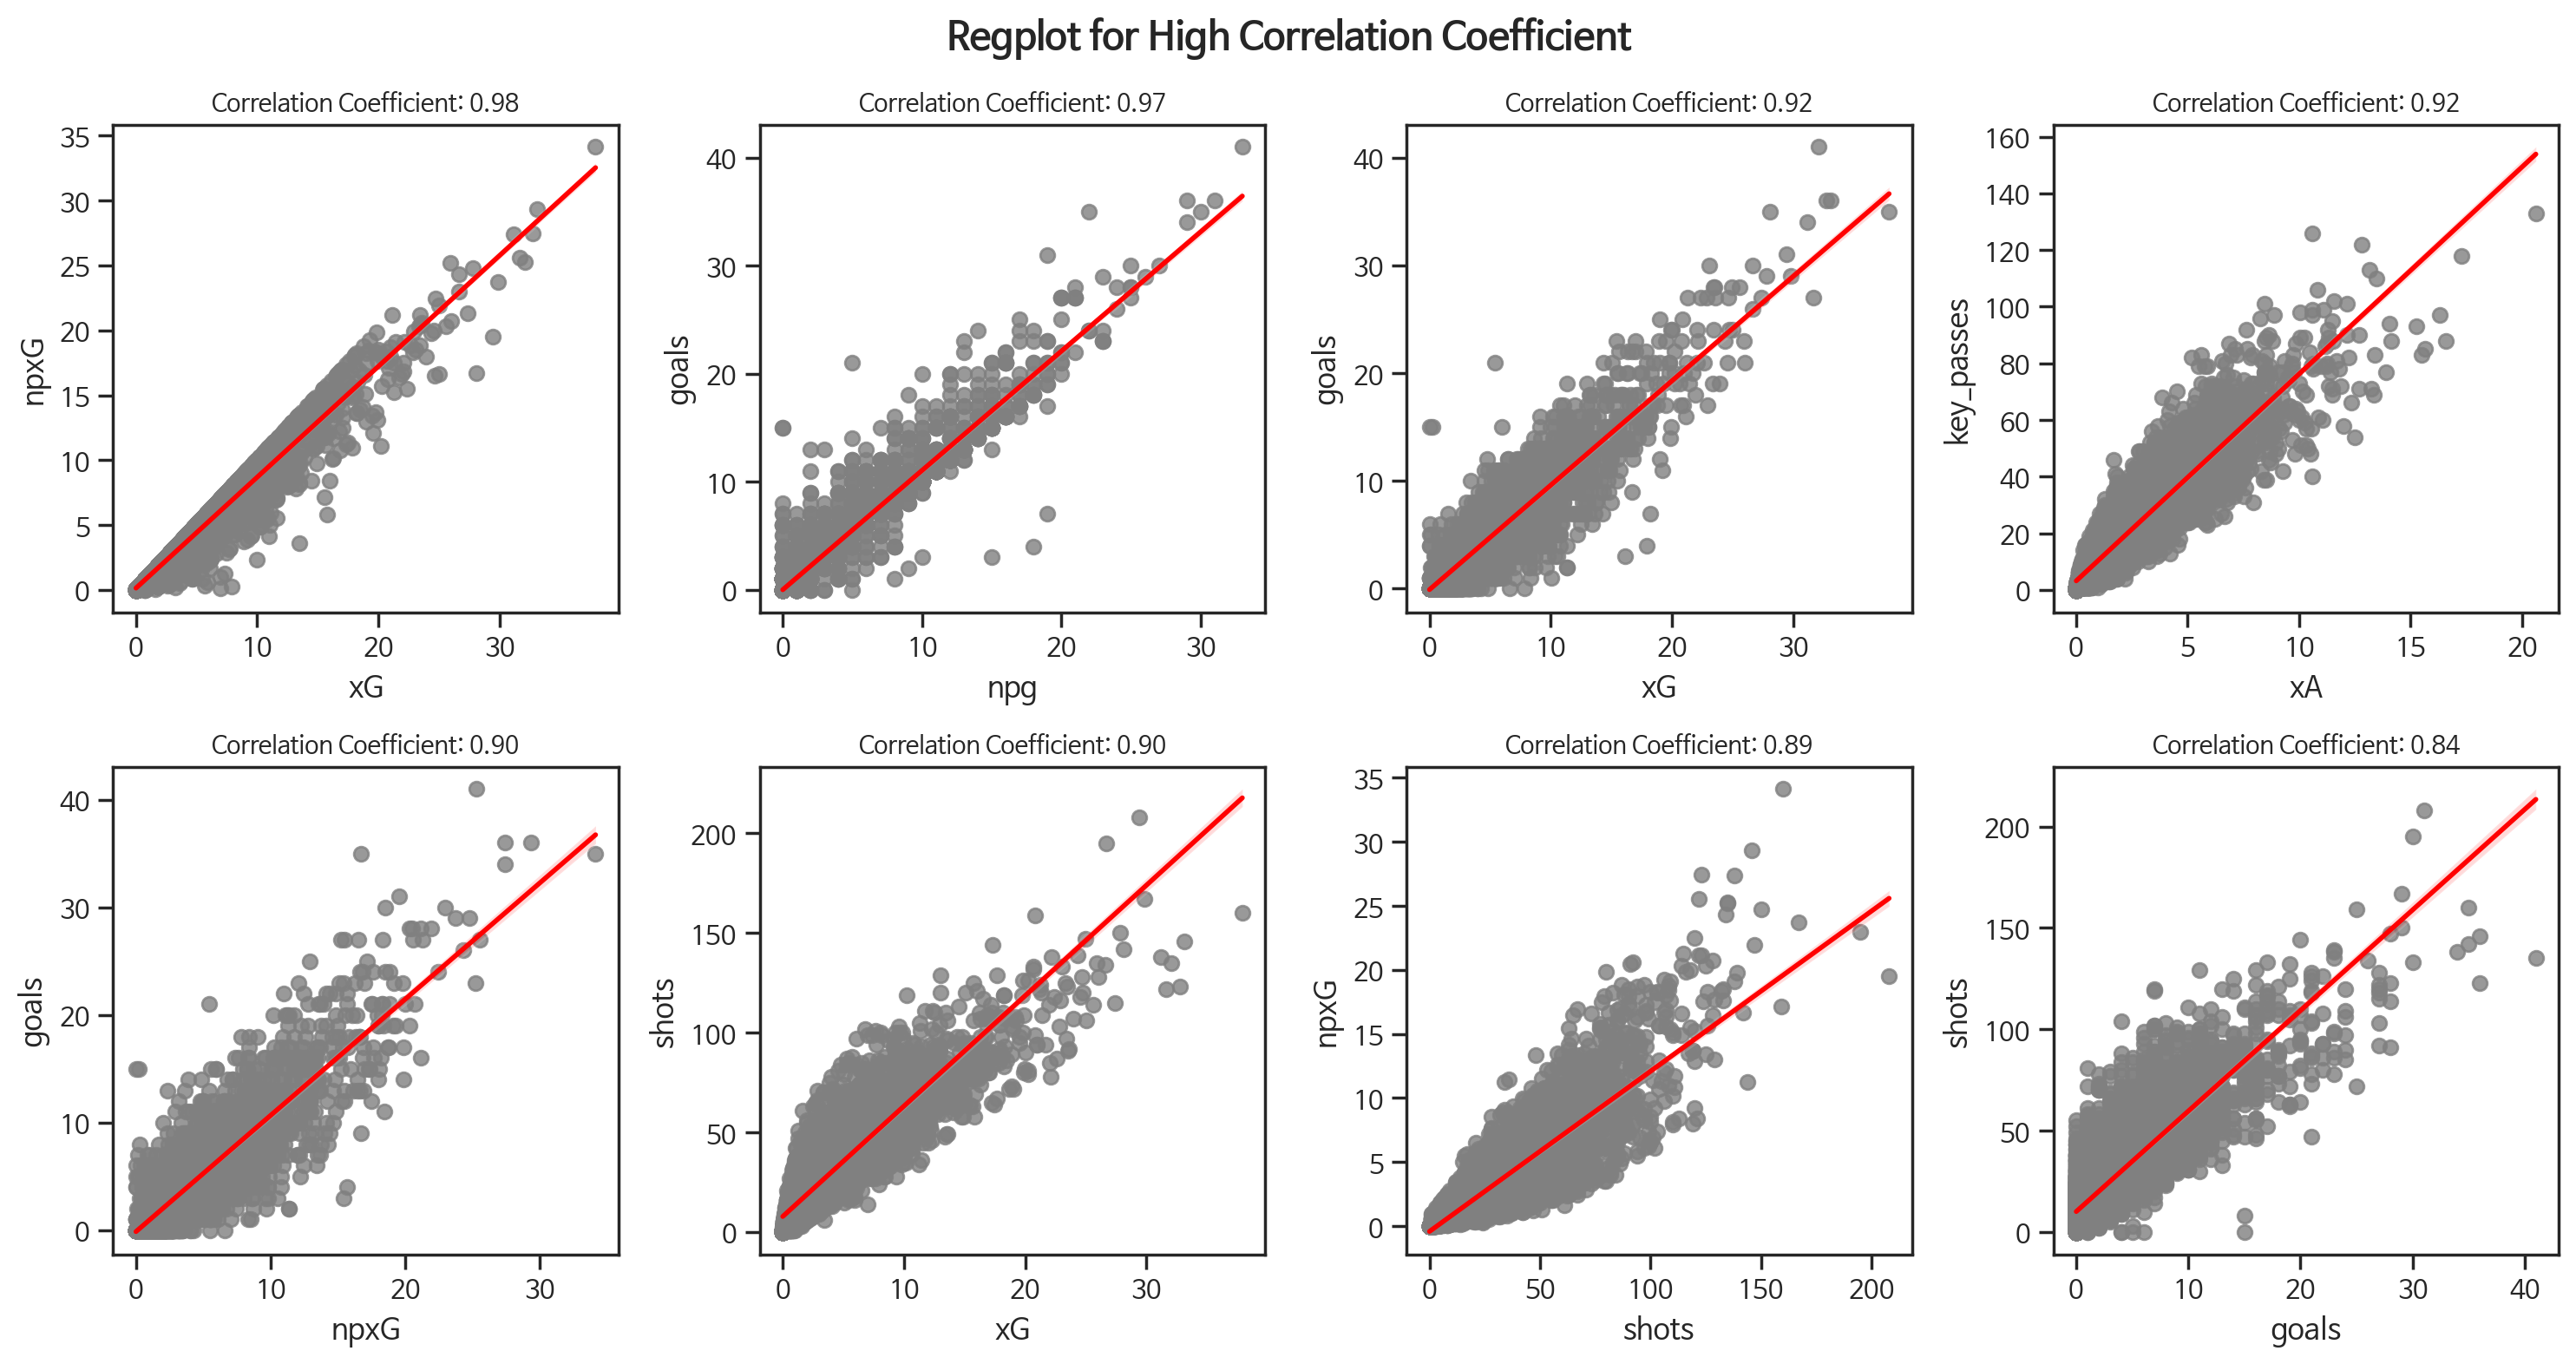

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 상관관계 분포 시각화
# subplot 생성
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))

# flatten()을 통해 axes를 1차원 array로 펴준다
axes = axes.flatten()

# regplot 그려서 추세선과 상관관계 확인
for (x_var, y_var), ax in zip(high_corr, axes):
    sns.regplot(x=df[x_var],
                y=df[y_var],
                ax=ax,
                scatter_kws={"color": "gray"},
                line_kws={"color": "red", "lw": 2})
    
    # 상관계수 계산
    corr, _ = pearsonr(df[x_var], df[y_var])
    
    # 서브플롯 제목에 상관계수 추가
    ax.set_title(f'Correlation Coefficient: {corr:.2f}', fontsize=10)

# 전체 제목 설정
plt.suptitle('Regplot for High Correlation Coefficient', fontsize=16, fontweight='bold')

# 레이아웃 조정
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # suptitle과 겹치지 않게 조정
plt.tight_layout()
plt.show()


## 5. 다중 공선성
- 하나의 독립 변수가 여러개의 독립 변수들로 잘 예측되는 경우를 의미한다
- 독립 변수들이 서로 독립이 아니라, 상호 상관관계가 강한 경우 발생
- 일반적으로 어떤 독립 변수의 영향력을 파악할 때, 확인하려는 변수의 영향력만을 판단하기 위해 다른 독립 변수들은 모두 일정하다고 가정한다.
- 그러나 만약 두 독립 변수가 서로에게 영향을 주고 있다면, 하나의 영향력을 검증할 때 다른 하나의 영향력을 완전히 통제할 수 없게 된다
    - 이러한 상황에서는 도출된 해석이 타당하다고 볼 수 없다
    
- 다중 공선성이 존재한다면 모델 구축 시 발생하는 상황
    - 계수 추정이 잘 되지 않거나, 불안정해져서 데이터가 약간만 바뀌어도 추정치 크게 달라짐
    - 계수가 통계적으로 유의미하지 않은 것처럼 도출
    - 과적합의 위험성
    - 특히 회귀 분석에 큰 영향 미친다 (분류는 영향 크게 미칠때도 있고 별로 상관 없을 때도 있음)
- References
    - https://dacon.io/codeshare/4443
    - https://datascienceschool.net/03%20machine%20learning/06.04%20%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC%20%EB%B3%80%EC%88%98%20%EC%84%A0%ED%83%9D.html
    - https://dacon.io/forum/408387

### 5-1. 다중 공선성 진단
- 분산팽창계수 (VIF, Variance Inflation Factor)를 구한다
- 일반적으로 5 또는 10보다 크면 다중 공선성이 있다고 판단한다

- VIF : 독립변수를 다른 독립변수로 선형회귀한 성능을 나타낸 지표
    - 다른 변수에 의존적일 수록 VIF가 증가

In [134]:
# 출처 : https://aliencoder.tistory.com/17

def feature_engineering_XbyVIF(df):
    # NaN 값이 있는 경우 처리
    if df.isnull().values.any():
        raise ValueError("데이터프레임에 NaN 값이 포함되어 있습니다. NaN 값을 처리해 주세요.")
    
    # 스케일링 (VIF는 스케일에 민감하지 않으나 수렴 문제 방지를 위해 일반적으로 스케일링을 적용)
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]
    vif['Feature'] = df.columns
    
    return vif

vif = feature_engineering_XbyVIF(df[num_cols])
print(vif)

    VIF_Factor                  Feature
0     1.312666             yellow_cards
1     1.012104                red_cards
2    46.351434                    goals
3     3.662747                  assists
4     4.786820           minutes_played
5     4.540967               total_apps
6     3.807397     highest_market_value
7     4.601281  market_value_per_season
8     1.351172             height_in_cm
9    81.458063                       xG
10   13.267897                       xA
11    8.220048                    shots
12    8.316233               key_passes
13   40.607682                      npg
14   86.148089                     npxG
15   56.315224                  xGChain
16   21.096323                xGBuildup
17    1.270484                      age


### 5-2. 다중 공선성 해결 방법
- 다중 공선성을 갖는 독립 변수 중 하나 혹은 일부를 제거한다
    - 단 회귀 모형의 R-square 값을 유지 또는 개선시키는 방향으로만 수행해야 한다
- 변수를 변형시키거나 새로운 관측치를 이용한다
- 자료를 수집하는 현장의 상황을 보아 상관관계의 이유를 파악하여 해결한다
- 주성분 분석 (Principle Component Analysis, PCA)을 이용한 diagonal matrix의 형태로 공선성을 없애준다

- References
    - https://aliencoder.tistory.com/17

In [137]:
num_cols

['yellow_cards',
 'red_cards',
 'goals',
 'assists',
 'minutes_played',
 'total_apps',
 'highest_market_value',
 'market_value_per_season',
 'height_in_cm',
 'xG',
 'xA',
 'shots',
 'key_passes',
 'npg',
 'npxG',
 'xGChain',
 'xGBuildup',
 'age']

In [139]:
# 유사한 의미를 가진 컬럼 제거한 후 다중공선성 확인
# total_apps - minutes_played 유사
# highest_market_value - market_value_per_season 유사
# npg - goals 유사
# npxG - xG 유사

# total_apps, highest_market_value, npg, npxG 제거한 데이터프레임 다중 공선성 확인해본다
feature_engineering_XbyVIF(df[['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played',
                              'market_value_per_season', 'height_in_cm', 'xG', 'xA', 'shots',
                              'key_passes', 'xGChain', 'xGBuildup', 'age']])

VIF_Factor                  Feature
0     1.300152             yellow_cards
1     1.011790                red_cards
2     7.103215                    goals
3     3.626244                  assists
4     1.864682           minutes_played
5     2.007532  market_value_per_season
6     1.313336             height_in_cm
7    19.790903                       xG
8    12.351014                       xA
9     7.857096                    shots
10    8.228796               key_passes
11   35.335015                  xGChain
12   14.059695                xGBuildup
13    1.197482                      age

### 5-3. 다중 공선성 결론
- VIF가 크더라도 분석에 꼭 필요한 Feature라면 살리는 것이 좋다
    - `goals`, `xG`, `xA`, `shots`, `key_passes`, `xGChain`, `xGBuildup` 등은 축구선수를 평가할 때 중요한 스탯
    - 일단 모델 생성해본 후, R-square 값을 개선시키는 방향으로 다중 공선성 다시 확인해 본다
- references
    - https://recipesds.tistory.com/entry/%EC%9C%A0%EC%9D%98%ED%95%98%EC%A7%80-%EC%95%8A%EC%9D%80-%EA%B3%84%EC%88%98%EB%A5%BC-%EC%96%B4%EC%A9%90%EB%8B%A4-%EA%B1%8D-%EB%B2%84%EB%A6%B4%EA%B9%8C-%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EC%9D%80-%EC%95%85%EB%8B%B9%EC%9D%BC%EA%B9%8C-%EC%83%81%EA%B4%80%EC%9D%B4%EB%82%98-VIF%EB%86%92%EC%9C%BC%EB%A9%B4-%EB%8B%A4-%EC%97%86%EC%95%A8%EA%B9%8C
        

In [140]:
#  total_apps, highest_market_value  npg, npxG 제거한 데이터프레임을 df에 선언
df = df.drop(["total_apps", "highest_market_value", "npg", "npxG"], axis=1)
df.head(3)

player_name start_season  yellow_cards  red_cards  goals  assists  \
0       Aarón Martín         2019           2.0        0.0    0.0      0.0   
1  Abdelhamid Sabiri         2019           6.0        0.0    4.0      1.0   
2      Achraf Hakimi         2019           5.0        0.0    5.0     10.0   

   minutes_played competition_code date_of_birth            posision  \
0          1795.0       bundesliga    1997-04-22           Left-Back   
1          1035.0       bundesliga    1996-11-28  Attacking Midfield   
2          2717.0       bundesliga    1998-11-04          Right-Back   

     current_club_name  market_value_per_season  country   foot  height_in_cm  \
0            Genoa CFC               10500000.0    Spain   left         178.0   
1       ACF Fiorentina                1700000.0  Morocco  right         186.0   
2  Paris Saint-Germain               54000000.0  Morocco  right         181.0   

         xG        xA  shots  key_passes    xGChain  xGBuildup  age  
0  0.294448  3.250888    9.0        32.0   3.658402   2.195273   23  
1  3.468877  0.232751   43.0         7.0   1.644770   0.885899   23  
2  5.067438  5.510969   38.0        36.0  24.144373  16.293885   21

## 6. 파생 변수 생성

In [141]:
df_copy = df.copy()

# yellow card, red card 컬럼을 합쳐서 aggression 컬럼 생성
# yellow card를 2번 받으면 red card와 같기 때문에, 가중치 0.3, 0.7 각각 곱해준다
df_copy["aggression"] = (df_copy["yellow_cards"] * 0.3) + (df_copy["red_cards"] * 0.7)

# minutes_played를 90으로 나누어, 90분으로 환산했을 때 몇 경기 뛰었는지 확인해본다
df_copy["90s"] = round(df_copy["minutes_played"] / 90, 1)
# df_copy.drop(columns=["yellow_cards", "red_cards", "minutes_played"], inplace=True)

In [149]:
def divided_90(df, col_list):
    # '90s' 값이 0인 경우를 NaN으로 대체해 나눗셈 시 inf가 발생하지 않도록 처리
    for col in col_list:
        col_name = f"{col}_90"
        df[col_name] = np.where(df["90s"] == 0, np.nan, round(df[col] / df["90s"], 2))

    df = df.fillna(0)
    return df

In [151]:
# "goals", "assists", "aggression", "xG", "xA", "shots", "key_passes", "xGChain", "xGBuildup"을 90분당 몇개 기록했는지 확인
df_copy = divided_90(df_copy, ["goals", "assists", "aggression", "xG", "xA", "shots", "key_passes", "xGChain", "xGBuildup"])
df_copy.head(3)

player_name start_season  yellow_cards  red_cards  goals  assists  \
0       Aarón Martín         2019           2.0        0.0    0.0      0.0   
1  Abdelhamid Sabiri         2019           6.0        0.0    4.0      1.0   
2      Achraf Hakimi         2019           5.0        0.0    5.0     10.0   

   minutes_played competition_code date_of_birth            posision  \
0          1795.0       bundesliga    1997-04-22           Left-Back   
1          1035.0       bundesliga    1996-11-28  Attacking Midfield   
2          2717.0       bundesliga    1998-11-04          Right-Back   

     current_club_name  market_value_per_season  country   foot  height_in_cm  \
0            Genoa CFC               10500000.0    Spain   left         178.0   
1       ACF Fiorentina                1700000.0  Morocco  right         186.0   
2  Paris Saint-Germain               54000000.0  Morocco  right         181.0   

         xG        xA  shots  key_passes    xGChain  xGBuildup  age  \
0  0.294448  3.250888    9.0        32.0   3.658402   2.195273   23   
1  3.468877  0.232751   43.0         7.0   1.644770   0.885899   23   
2  5.067438  5.510969   38.0        36.0  24.144373  16.293885   21   

   aggression   90s  goals_90  assists_90  aggression_90  xG_90  xA_90  \
0         0.6  19.9      0.00        0.00           0.03   0.01   0.16   
1         1.8  11.5      0.35        0.09           0.16   0.30   0.02   
2         1.5  30.2      0.17        0.33           0.05   0.17   0.18   

   shots_90  key_passes_90  xGChain_90  xGBuildup_90  
0      0.45           1.61        0.18          0.11  
1      3.74           0.61        0.14          0.08  
2      1.26           1.19        0.80          0.54

In [152]:
df_copy.sort_values(by="xGChain_90", ascending=False)

player_name start_season  yellow_cards  red_cards  goals  \
12226             Vitinha         2022           0.0        0.0    2.0   
12704             Vitinha         2023           1.0        0.0    3.0   
10480       Kylian Mbappé         2019           0.0        0.0   18.0   
11739    Adrien Thomasson         2022           2.0        0.0    0.0   
12004    Karl Toko Ekambi         2022           0.0        0.0    3.0   
...                   ...          ...           ...        ...    ...   
11865  Eliesse Ben Seghir         2022           1.0        0.0    4.0   
8130          Raúl García         2019          11.0        0.0   15.0   
177         Jonas Hofmann         2019           3.0        0.0    5.0   
8633          Rubén Yáñez         2020           2.0        0.0    0.0   
9087          Raúl García         2021           4.0        0.0    6.0   

       assists  minutes_played competition_code date_of_birth  \
12226      0.0           458.0          ligue-1    2000-03-15   
12704      2.0           920.0          ligue-1    2000-03-15   
10480      7.0          1515.0          ligue-1    1998-12-20   
11739      2.0           937.0          ligue-1    1993-12-10   
12004      2.0           975.0          ligue-1    1992-09-14   
...        ...             ...              ...           ...   
11865      1.0          1061.0          ligue-1    2005-02-16   
8130       1.0          2877.0           laliga    1986-07-11   
177        3.0          1632.0       bundesliga    1992-07-14   
8633       0.0           900.0           laliga    1993-10-12   
9087       3.0          1818.0           laliga    1986-07-11   

                 posision    current_club_name  market_value_per_season  \
12226      Centre-Forward            Genoa CFC               18000000.0   
12704      Centre-Forward            Genoa CFC               14000000.0   
10480      Centre-Forward  Paris Saint-Germain              180000000.0   
11739  Attacking Midfield              RC Lens                6000000.0   
12004         Left Winger     Stade Rennais FC                8000000.0   
...                   ...                  ...                      ...   
11865  Attacking Midfield            AS Monaco               18000000.0   
8130       Centre-Forward      Athletic Bilbao                6000000.0   
177    Attacking Midfield  Bayer 04 Leverkusen                9000000.0   
8633           Goalkeeper            Getafe CF                2000000.0   
9087       Centre-Forward      Athletic Bilbao                2500000.0   

        country   foot  height_in_cm         xG         xA  shots  key_passes  \
12226  Portugal  right         178.0   2.882865   2.676278   30.0        27.0   
12704  Portugal  right         178.0   3.116928   3.475748   45.0        36.0   
10480    France  right         178.0  16.572055  10.575325   88.0        40.0   
11739    France  right         175.0   6.620393   5.641488   38.0        36.0   
12004  Cameroon  right         182.0   9.790106   5.078305   63.0        38.0   
...         ...    ...           ...        ...        ...    ...         ...   
11865   Morocco  right         178.0   0.000000   0.000000    0.0         0.0   
8130      Spain  right         184.0   0.000000   0.000000    0.0         0.0   
177     Germany  right         176.0   0.000000   0.000000    0.0         0.0   
8633      Spain  right         188.0   0.000000   0.000000    0.0         0.0   
9087      Spain  right         184.0   0.000000   0.000000    0.0         0.0   

         xGChain  xGBuildup  age  aggression   90s  goals_90  assists_90  \
12226  21.723909  17.688013   23         0.0   5.1      0.39        0.00   
12704  19.426675  15.858192   24         0.3  10.2      0.29        0.20   
10480  29.428358   6.044631   21         0.0  16.8      1.07        0.42   
11739  18.106727   9.186979   29         0.6  10.4      0.00        0.19   
12004  18.465596   6.247677   31         0.0  10.8      0.28        0.19   
...          .

In [154]:
df_copy[df_copy["player_name"]=="Vitinha"]

player_name start_season  yellow_cards  red_cards  goals  assists  \
6195      Vitinha         2020           0.0        0.0    0.0      1.0   
12226     Vitinha         2022           0.0        0.0    2.0      0.0   
12227     Vitinha         2022           0.0        0.0    2.0      0.0   
12228     Vitinha         2022           3.0        0.0    2.0      3.0   
12229     Vitinha         2022           3.0        0.0    2.0      3.0   
12704     Vitinha         2023           1.0        0.0    3.0      2.0   
12705     Vitinha         2023           1.0        0.0    3.0      2.0   
12706     Vitinha         2023           0.0        0.0    7.0      4.0   
12707     Vitinha         2023           0.0        0.0    7.0      4.0   

       minutes_played competition_code date_of_birth          posision  \
6195            513.0   premier-league    2000-02-13  Central Midfield   
12226           458.0          ligue-1    2000-03-15    Centre-Forward   
12227           458.0          ligue-1    2000-03-15    Centre-Forward   
12228          2460.0          ligue-1    2000-02-13  Central Midfield   
12229          2460.0          ligue-1    2000-02-13  Central Midfield   
12704           920.0          ligue-1    2000-03-15    Centre-Forward   
12705           920.0          ligue-1    2000-03-15    Centre-Forward   
12706          2129.0          ligue-1    2000-02-13  Central Midfield   
12707          2129.0          ligue-1    2000-02-13  Central Midfield   

         current_club_name  market_value_per_season   country   foot  \
6195   Paris Saint-Germain                7000000.0  Portugal  right   
12226            Genoa CFC               18000000.0  Portugal  right   
12227            Genoa CFC               18000000.0  Portugal  right   
12228  Paris Saint-Germain               42000000.0  Portugal  right   
12229  Paris Saint-Germain               42000000.0  Portugal  right   
12704            Genoa CFC               14000000.0  Portugal  right   
12705            Genoa CFC               14000000.0  Portugal  right   
12706  Paris Saint-Germain               55000000.0  Portugal  right   
12707  Paris Saint-Germain               55000000.0  Portugal  right   

       height_in_cm        xG        xA  shots  key_passes    xGChain  \
6195          172.0  0.664912  0.720134    8.0        12.0   1.945695   
12226         178.0  2.882865  2.676278   30.0        27.0  21.723909   
12227         178.0  4.777909  0.189242   26.0         3.0   4.583073   
12228         172.0  2.882865  2.676278   30.0        27.0  21.723909   
12229         172.0  4.777909  0.189242   26.0         3.0   4.583073   
12704         178.0  3.116928  3.475748   45.0        36.0  19.426675   
12705         178.0  5.534087  2.816041   37.0        18.0  11.574844   
12706         172.0  3.116928  3.475748   45.0        36.0  19.426675   
12707         172.0  5.534087  2.816041   37.0        18.0  11.574844   

       xGBuildup  age  aggression   90s  goals_90  assists_90  aggression_90  \
6195    1.477344   21         0.0   5.7      0.00        0.18           0.00   
12226  17.688013   23         0.0   5.1      0.39        0.00           0.00   
12227   0.423319   23         0.0   5.1      0.39        0.00           0.00   
12228  17.688013   23         0.9  27.3      0.07        0.11           0.03   
12229   0.423319   23         0.9  27.3      0.07        0.11           0.03   
12704  15.858192   24         0.3  10.2      0.29        0.20           0.03   
12705   4.518647   24         0.3  10.2      0.29        0.20           0.03   
12706  15.858192   24         0.0  23.7      0.30        0.17           0.00   
12707   4.518647   24         0.0  23.7      0.30        0.17           0.00   

       xG_90  xA_90  shots_90  key_passes_90  xGChain_90  xGBuildup_90  
6195    0.12   0.13      1.40           2.11        0.34          0.26  
12226   0.57   0.52      5.88           5.29        4.26          3.47  
12227   0.94   0.04      5.10           0.

In [75]:
# df_copy.drop(columns=["goals", "assists", "aggression", "90s"], inplace=True)

In [76]:
# total_apps, highest_market_value 제거한 데이터프레임의 상관관계 확인

# df_corr2 = df_copy[df_copy.select_dtypes(include=np.number).columns.tolist()].corr()
df_corr2 = df_copy[["age", "market_value_per_season", "height_in_cm","goals_90", "assists_90", "aggression_90"]].corr()


df_corr2.style.background_gradient()

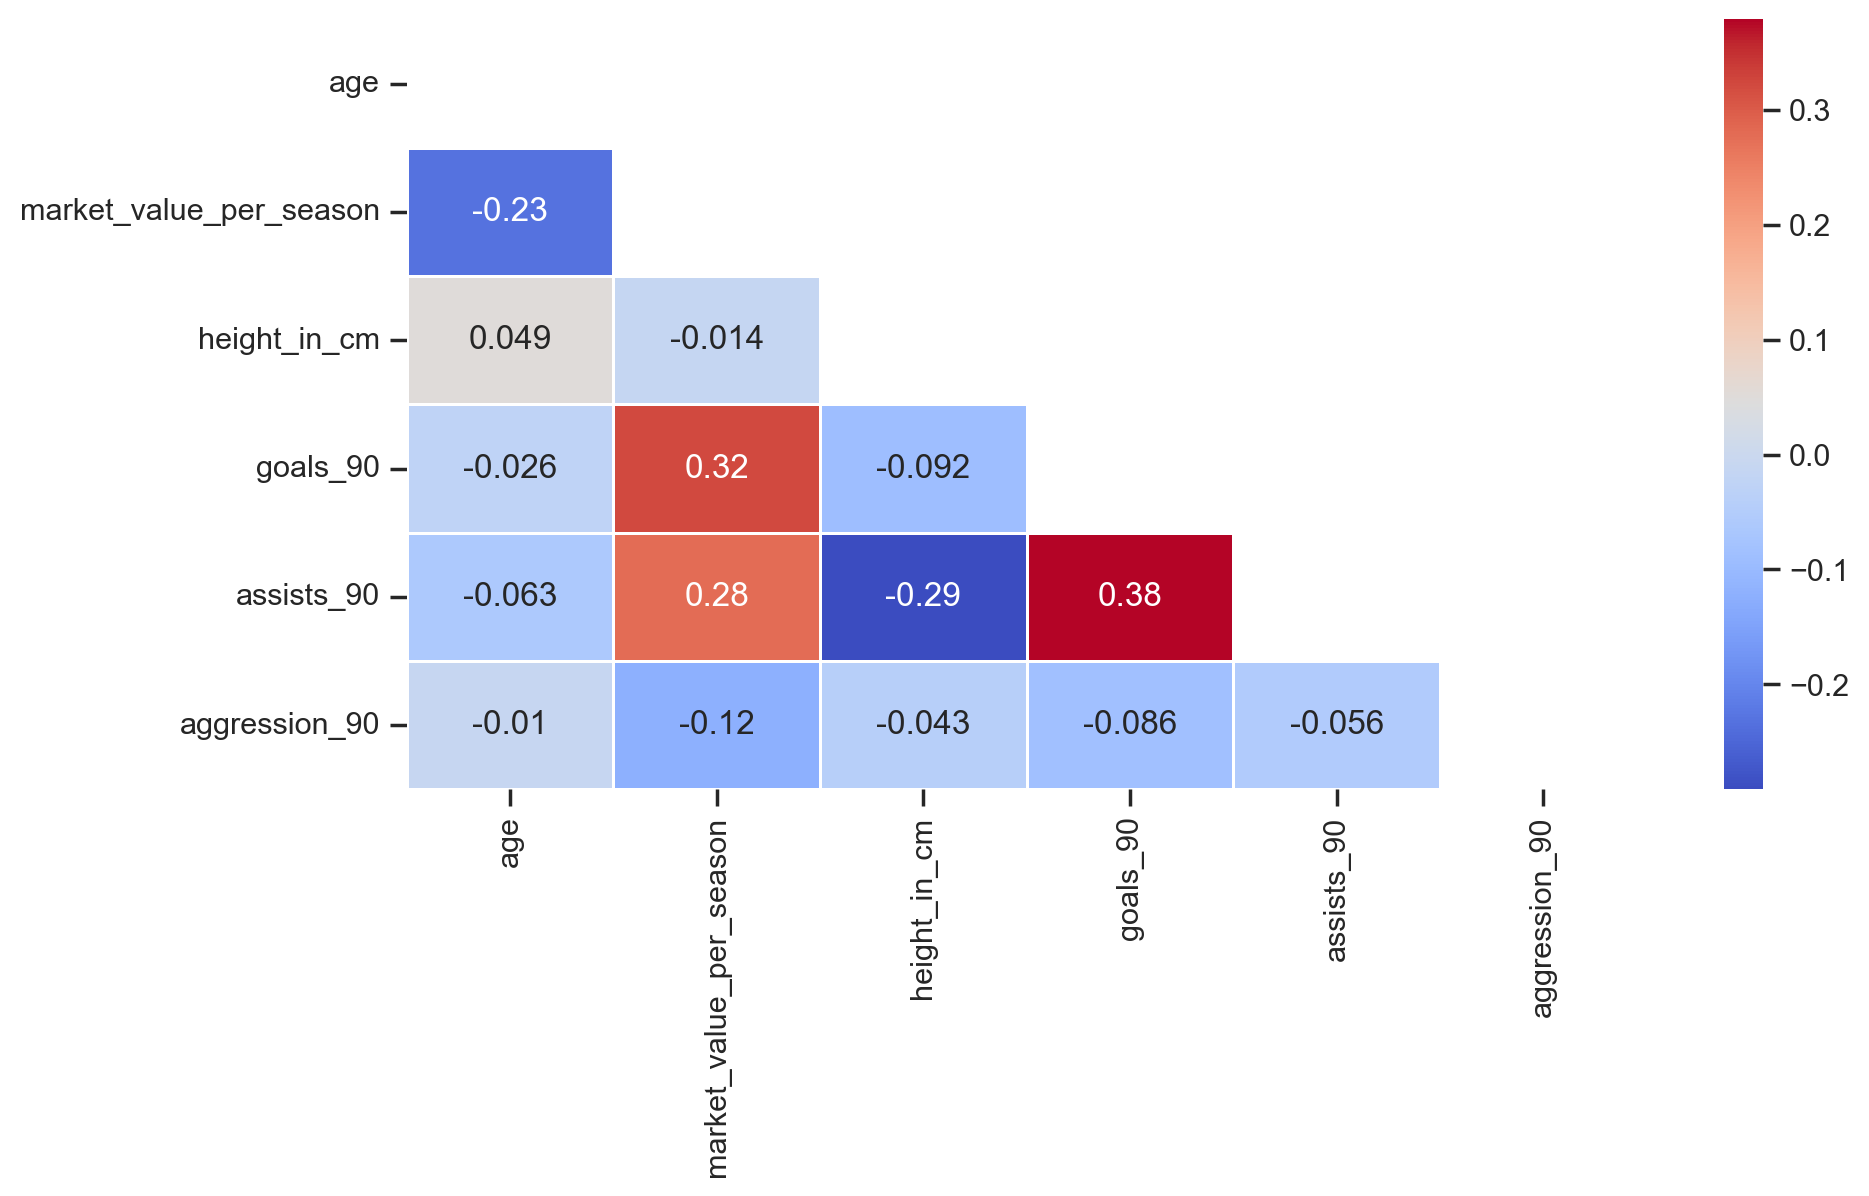

In [77]:
plt.figure(figsize=(10,5))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df_corr2, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr2,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')
plt.show()

In [78]:
# 변경한 데이터프레임 (df_copy) 다중공선성 확인
feature_engineering_XbyVIF(df_copy[["age", "market_value_per_season","height_in_cm", "goals_90", "assists_90", "aggression_90"]])

VIF_Factor                  Feature
0   44.492852                      age
1    1.837453  market_value_per_season
2   48.248562             height_in_cm
3    1.909919                 goals_90
4    1.991309               assists_90
5    2.144883            aggression_90

### 상관관계 결과
- 약한 상관관계 (0 ~ 0.2)
    - `market_value_per_season` - `goals_90`
    - `market_value_per_season` - `assists_90`
    - `goals_90` - `assists_90`
- 음의 상관관계 (-0.2 ~)
    - `assists_90` - `height_in_cm`
    - `market_value_per_season` - `age`

- 추후 머신러닝 모델링에 따라 컬럼 추가 제거 예정

## `column`별 분석

### `goals`, `assists` 분석

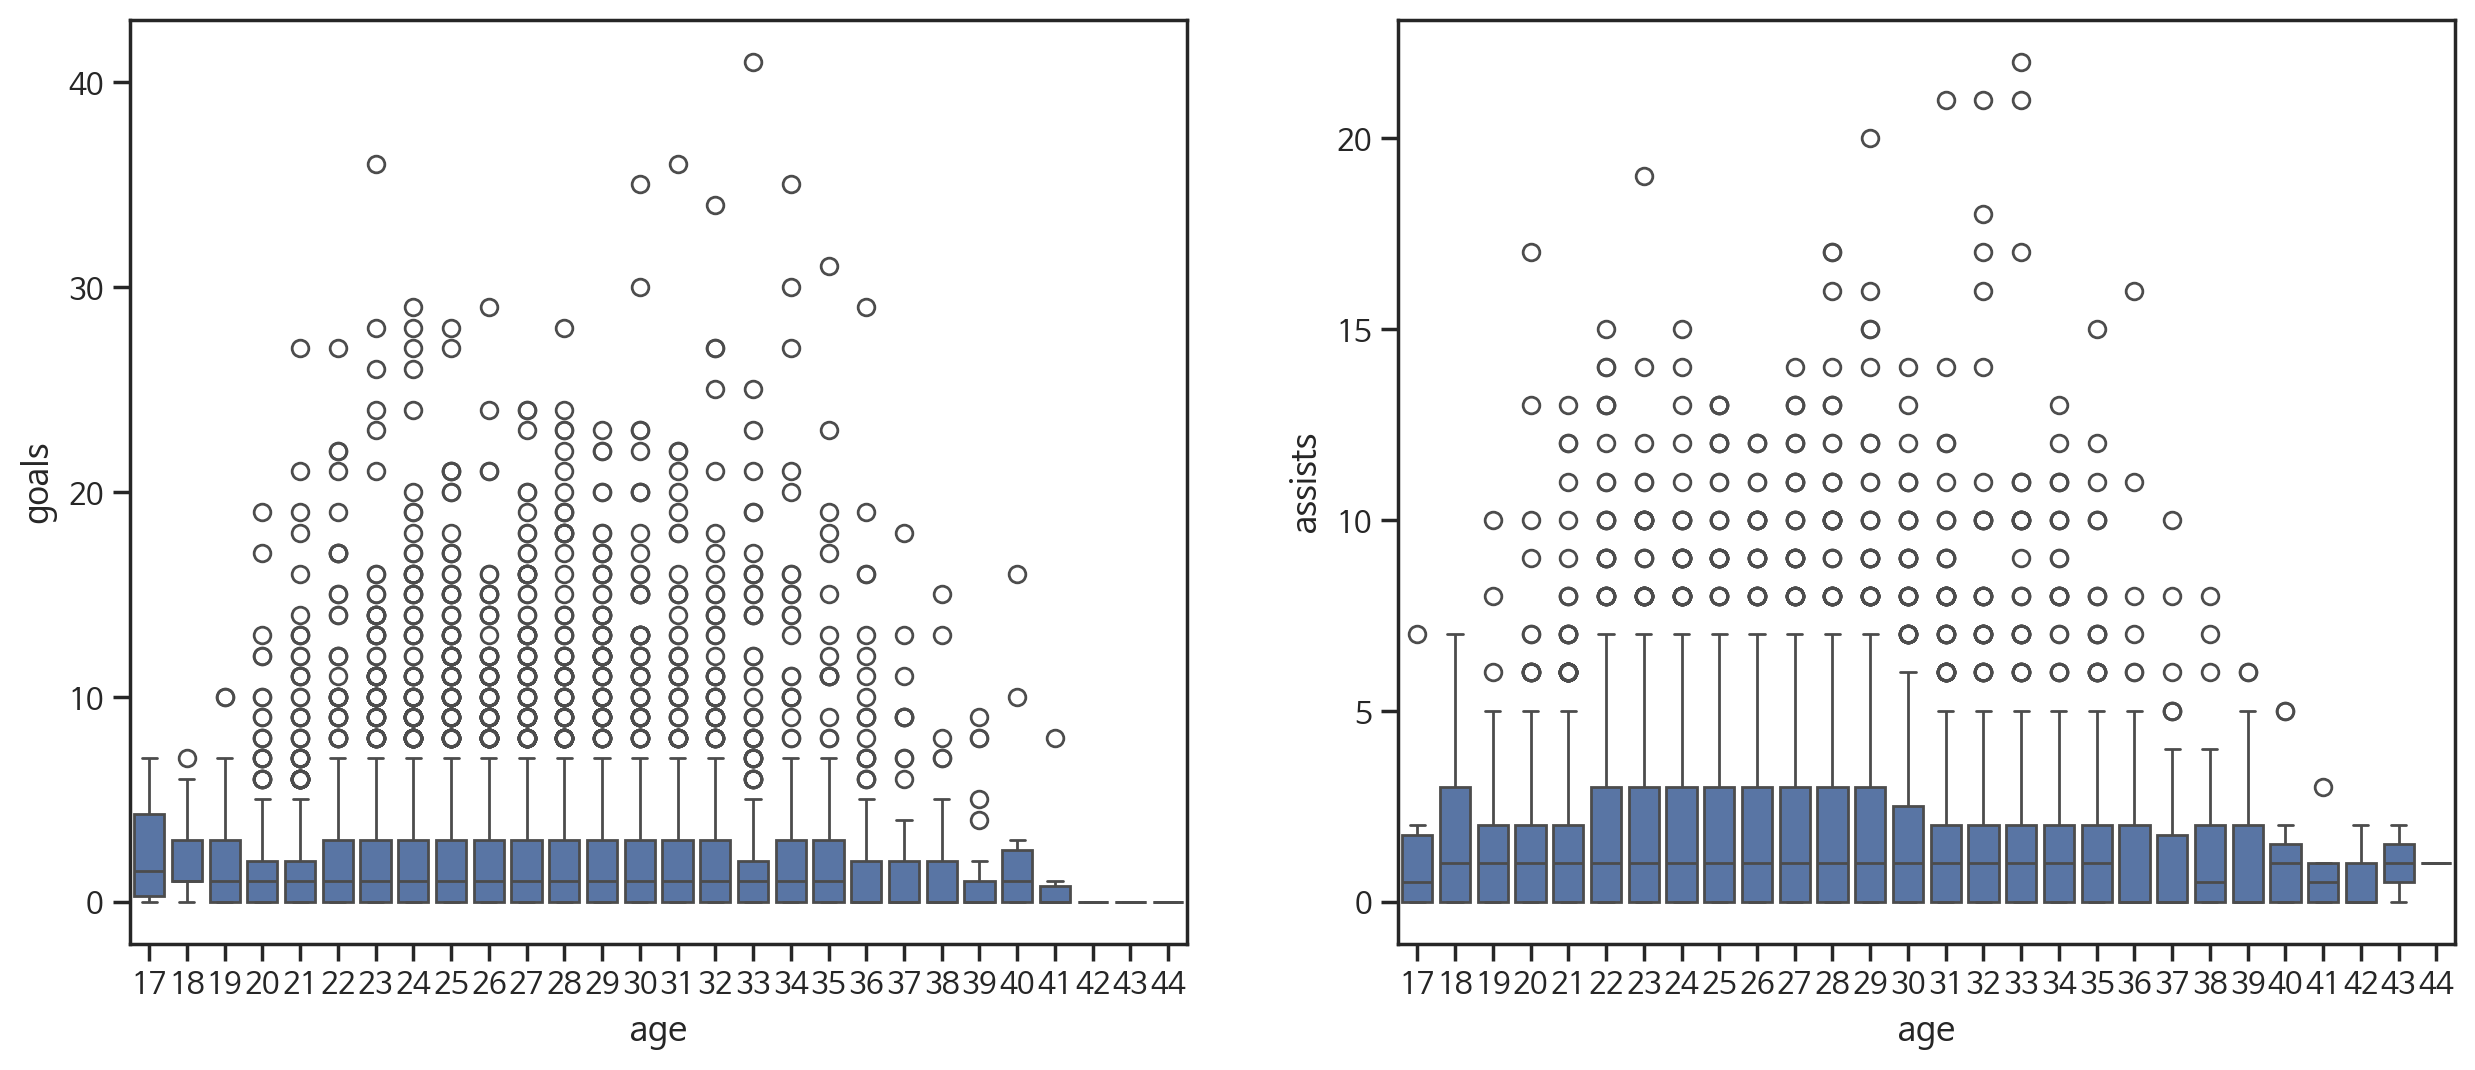

In [90]:
# boxplot 그려서 나이에 따른 골, 어시스트 확인
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# plt.figure(figsize=(15,8))
g1 = sns.boxplot(data=df_copy, x="age", y="goals", ax=axes[0])
g2 = sns.boxplot(data=df_copy, x="age", y="assists", ax=axes[1])

# g1 = sns.boxplot(data=df_copy, x="age", y="goals_90", ax=axes[1, 0])
# g2 = sns.boxplot(data=df_copy, x="age", y="assists_90", ax=axes[1, 1])

In [87]:
df_copy.loc[df_copy.sort_values(by=["goals_90", "90s"], ascending=[False, False]).index].head(10)

player_name start_season  yellow_cards  red_cards  goals  \
9426   Robert Lewandowski         2020             4          0     41   
6538          Luis Muriel         2020             0          0     22   
6537          Luis Muriel         2019             1          0     18   
3030       Erling Haaland         2022             5          0     36   
2302         Darwin Núñez         2021             6          0     26   
9427   Robert Lewandowski         2021             2          0     35   
4044           Harry Kane         2023             2          0     36   
9425   Robert Lewandowski         2019             5          0     34   
10197     Serhou Guirassy         2023             0          0     28   
6059        Kylian Mbappé         2023             4          0     27   

       assists  minutes_played    competition_code date_of_birth  age  \
9426         7            2463          bundesliga    1988-08-21   33   
6538         9            1464             serie-a    1991-04-16   30   
6537         1            1216             serie-a    1991-04-16   29   
3030         8            2777      premier-league    2000-07-21   23   
2302         4            1989  liga-portugal-bwin    1999-06-24   23   
9427         4            2952          bundesliga    1988-08-21   34   
4044         8            2843          bundesliga    1993-07-28   31   
9425         4            2761          bundesliga    1988-08-21   32   
10197        2            2214          bundesliga    1996-03-12   28   
6059         7            2159             ligue-1    1998-12-20   25   

             position    current_club_name  market_value_per_season   country  \
9426   Centre-Forward         FC Barcelona               60000000.0    Poland   
6538   Centre-Forward          Atalanta BC               30000000.0  Colombia   
6537   Centre-Forward          Atalanta BC               15000000.0  Colombia   
3030   Centre-Forward      Manchester City              180000000.0    Norway   
2302   Centre-Forward         Liverpool FC               55000000.0   Uruguay   
9427   Centre-Forward         FC Barcelona               45000000.0    Poland   
4044   Centre-Forward        Bayern Munich              100000000.0   England   
9425   Centre-Forward         FC Barcelona               56000000.0    Poland   
10197  Centre-Forward        VfB Stuttgart               40000000.0    Guinea   
6059   Centre-Forward  Paris Saint-Germain              180000000.0    France   

        foot  height_in_cm  aggression   90s  goals_90  assists_90  \
9426   right         185.0         1.2  27.4       1.5         0.3   
6538   right         180.0         0.0  16.3       1.3         0.6   
6537   right         180.0         0.3  13.5       1.3         0.1   
3030    left         195.0         1.5  30.9       1.2         0.3   
2302   right         187.0         1.8  22.1       1.2         0.2   
9427   right         185.0         0.6  32.8       1.1         0.1   
4044   right         188.0         0.6  31.6       1.1         0.3   
9425   right         185.0         1.5  30.7       1.1         0.1   
10197  right         187.0         0.0  24.6       1.1         0.1   
6059   right         178.0         1.2  24.0       1.1         0.3   

       aggression_90  
9426             0.0  
6538             0.0  
6537             0.0  
3030             0.0  
2302             0.1  
9427             0.0  
4044             0.0  
9425             0.0  
10197            0.0  
6059             0.0

In [88]:
df_copy.loc[df_copy.sort_values(by=["assists_90", "90s"], ascending=[False, False]).index].head(10)

player_name start_season  yellow_cards  red_cards  goals  \
6153    Leandro Trossard         2022             0          0      1   
3576        Fábio Vieira         2021             2          0      6   
499       Alexis Sánchez         2019             4          0      4   
9580               Roger         2023             1          0      2   
10659      Thomas Müller         2019             5          0      8   
8518     Ousmane Dembélé         2021             3          0      1   
342    Aleksandr Golovin         2020             2          0      5   
10567               Tetê         2021             1          0      2   
6258        Lionel Messi         2019             4          0     25   
10660      Thomas Müller         2020             0          0     11   

       assists  minutes_played    competition_code date_of_birth  age  \
6153        10             930      premier-league    1994-12-04   28   
3576        14            1330  liga-portugal-bwin    2000-05-30   22   
499          9             899             serie-a    1988-12-19   31   
9580         7             672  liga-portugal-bwin    2005-11-21   18   
10659       21            2261          bundesliga    1989-09-13   31   
8518        13            1411              laliga    1997-05-15   25   
342          9            1072             ligue-1    1996-05-30   25   
10567        5             585             ligue-1    2000-02-15   22   
6258        22            2880              laliga    1987-06-24   33   
10660       21            2685          bundesliga    1989-09-13   32   

                 position    current_club_name  market_value_per_season  \
6153          Left Winger           Arsenal FC               35000000.0   
3576   Attacking Midfield           Arsenal FC               25000000.0   
499        Centre-Forward          Inter Milan               16000000.0   
9580          Left Winger             SC Braga               10000000.0   
10659      Second Striker        Bayern Munich               30000000.0   
8518         Right Winger  Paris Saint-Germain               30000000.0   
342    Attacking Midfield            AS Monaco               28000000.0   
10567        Right Winger          Galatasaray               22000000.0   
6258         Right Winger  Paris Saint-Germain              112000000.0   
10660      Second Striker        Bayern Munich               30000000.0   

         country   foot  height_in_cm  aggression   90s  goals_90  assists_90  \
6153     Belgium  right         172.0         0.0  10.3       0.1         1.0   
3576    Portugal   left         170.0         0.6  14.8       0.4         0.9   
499        Chile  right         169.0         1.2  10.0       0.4         0.9   
9580    Portugal   left         166.0         0.3   7.5       0.3         0.9   
10659    Germany  right         185.0         1.5  25.1       0.3         0.8   
8518      France   both         178.0         0.9  15.7       0.1         0.8   
342       Russia  right         178.0         0.6  11.9       0.4         0.8   
10567     Brazil   left         175.0         0.3   6.5       0.3         0.8   
6258   Argentina   left         170.0         1.2  32.0       0.8         0.7   
10660    Germany  right         185.0         0.0  29.8       0.4         0.7   

       aggression_90  
6153             0.0  
3576             0.0  
499              0.1  
9580             0.0  
10659            0.1  
8518             0.1  
342              0.1  
10567            0.0  
6258             0.0  
10660            0.0

In [89]:
df_copy[df_copy["player_name"]=="Lionel Messi"]

player_name start_season  yellow_cards  red_cards  goals  assists  \
6258  Lionel Messi         2019             4          0     25       22   
6259  Lionel Messi         2020             4          0     30       11   
6260  Lionel Messi         2021             0          0      6       15   
6261  Lionel Messi         2022             0          0     16       16   

      minutes_played competition_code date_of_birth  age      position  \
6258            2880           laliga    1987-06-24   33  Right Winger   
6259            3023           laliga    1987-06-24   34  Right Winger   
6260            2152          ligue-1    1987-06-24   35  Right Winger   
6261            2842          ligue-1    1987-06-24   36  Right Winger   

        current_club_name  market_value_per_season    country  foot  \
6258  Paris Saint-Germain              112000000.0  Argentina  left   
6259  Paris Saint-Germain               80000000.0  Argentina  left   
6260  Paris Saint-Germain               50000000.0  Argentina  left   
6261  Paris Saint-Germain               35000000.0  Argentina  left   

      height_in_cm  aggression   90s  goals_90  assists_90  aggression_90  
6258         170.0         1.2  32.0       0.8         0.7            0.0  
6259         170.0         1.2  33.6       0.9         0.3            0.0  
6260         170.0         0.0  23.9       0.3         0.6            0.0  
6261         170.0         0.0  31.6       0.5         0.5            0.0

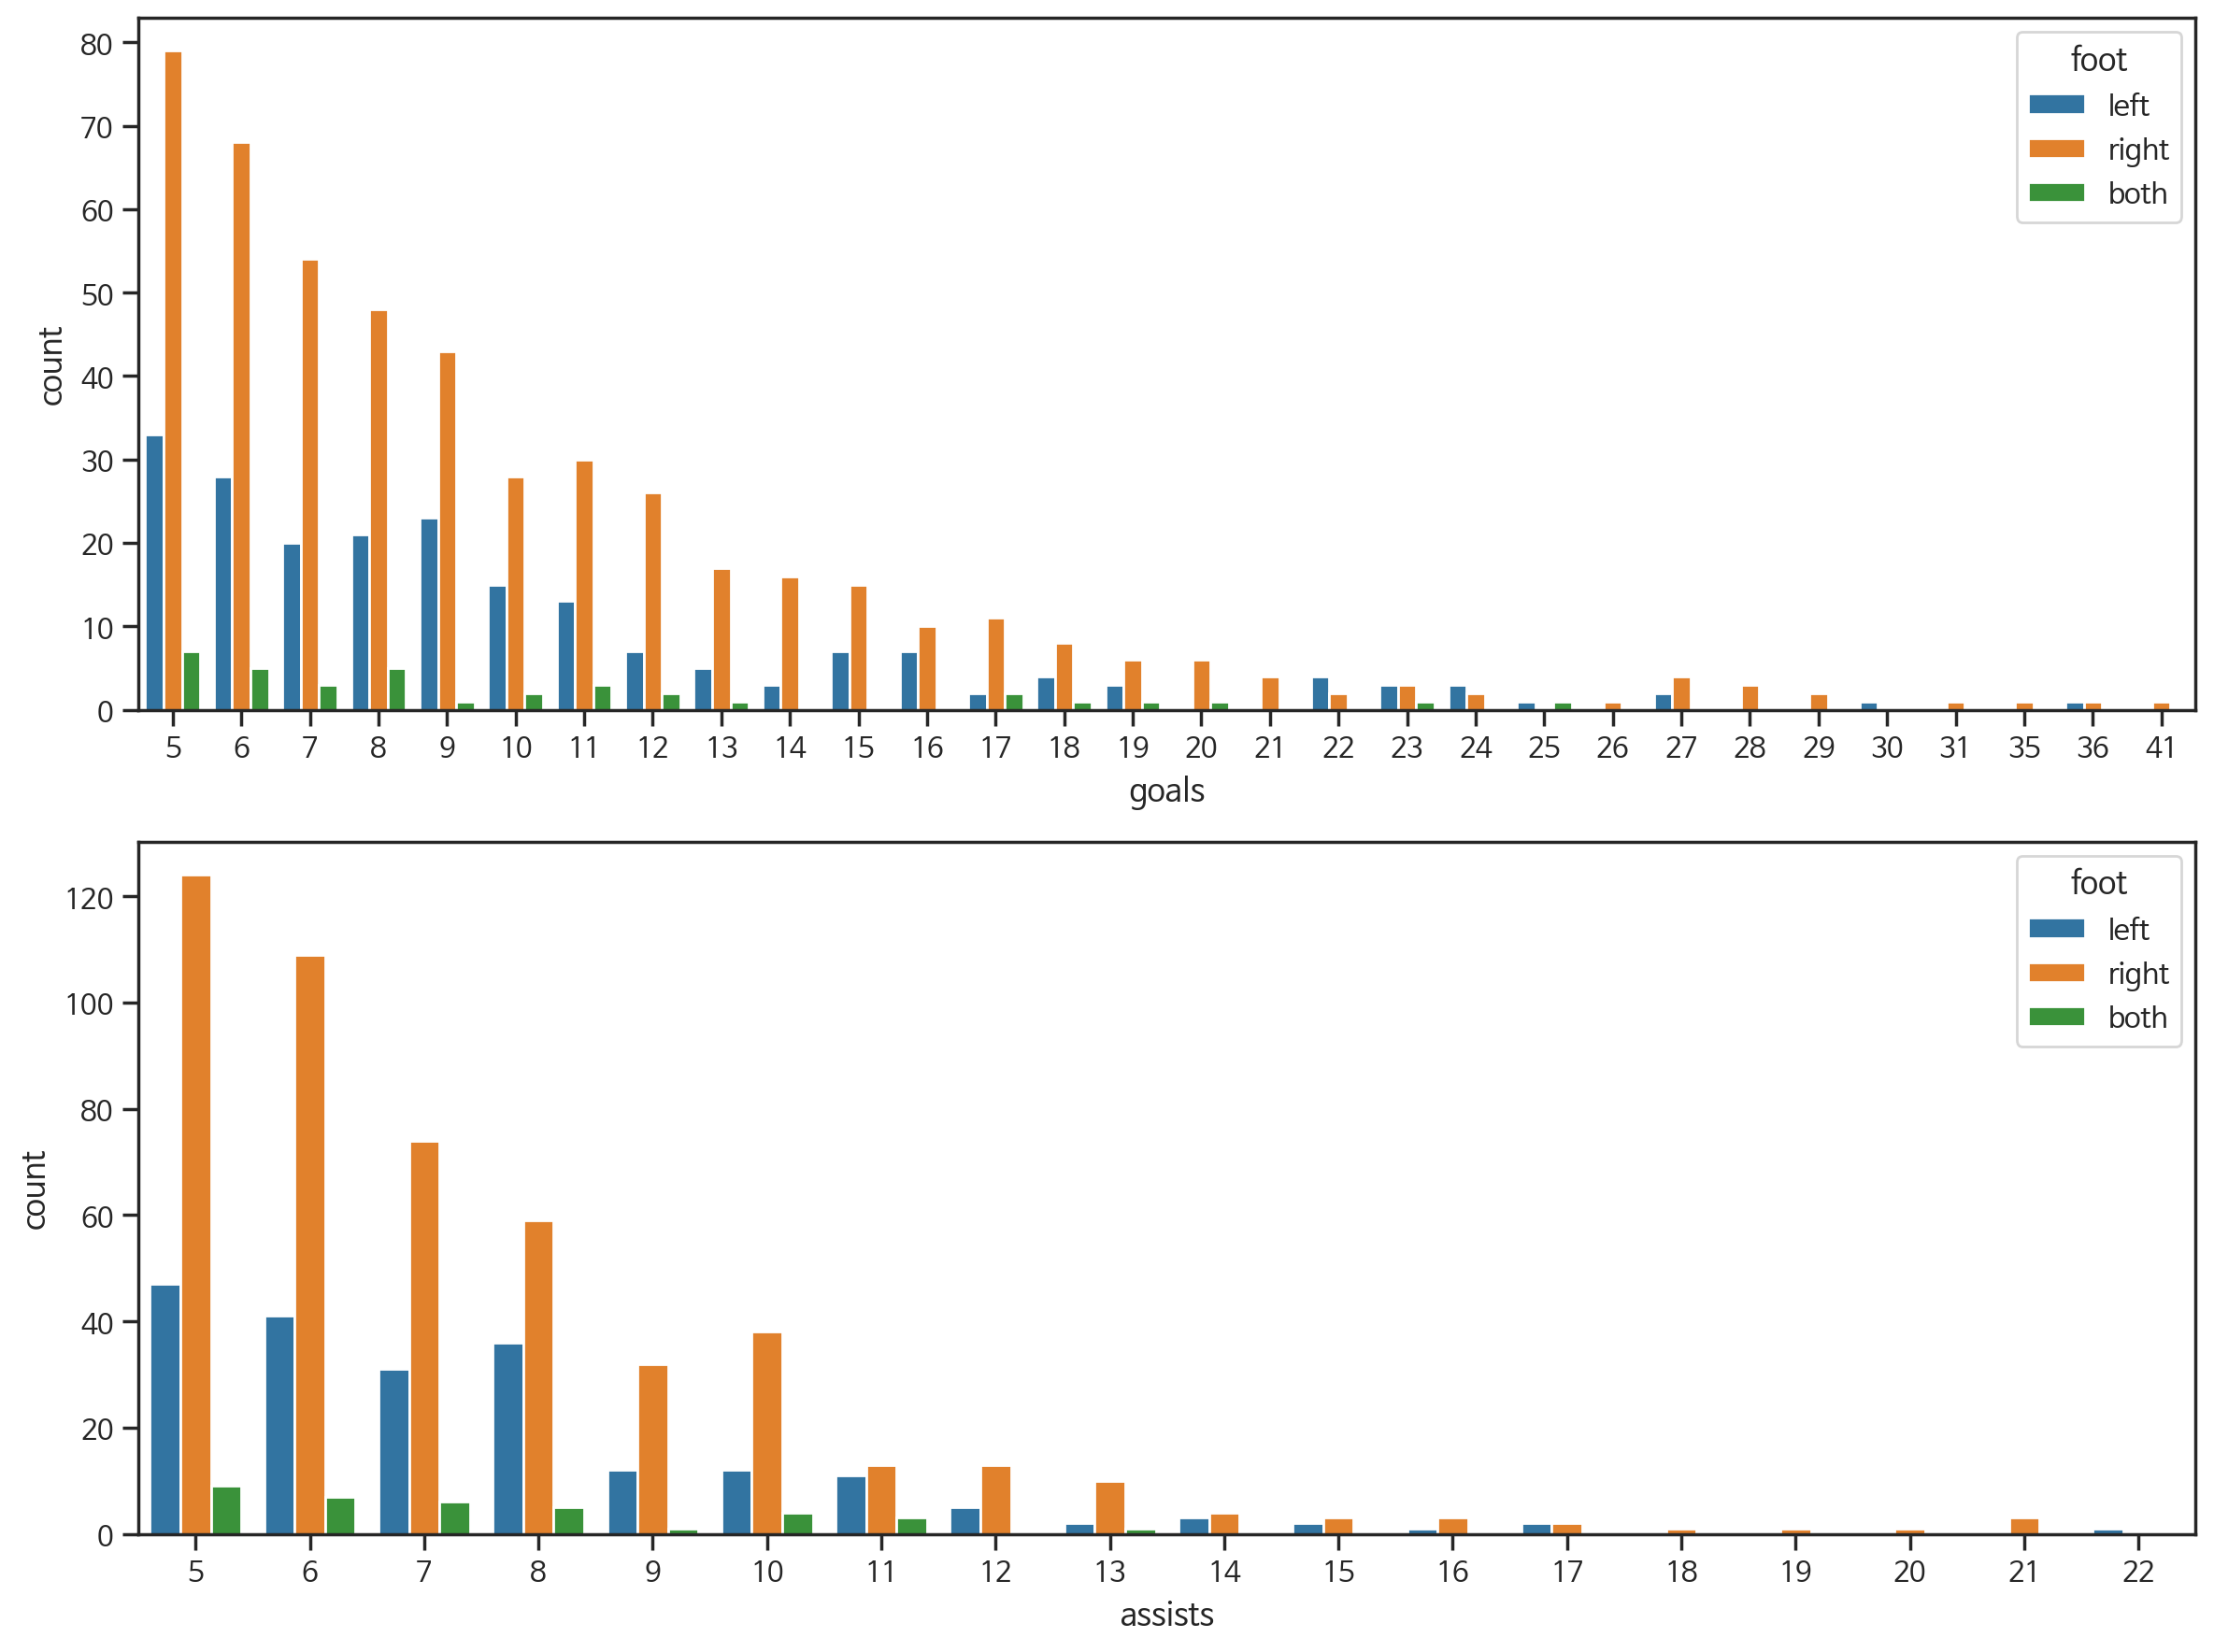

In [104]:
# countplot 그려서 골, 어시스트 숫자 확인
# 골, 어시스트 0인 선수 제외

goals_assists = ["goals", "assists"]
more_than_zero = (df_copy.goals >= 5) & (df_copy.assists >= 5)

# 'foot' 카테고리 값에 맞는 고정 색상 설정
hue_order = ['left', 'right', 'both']
fixed_palette = dict(zip(hue_order, sns.color_palette("tab10", len(hue_order))))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))

for col, ax in zip(goals_assists, axes):
    sns.countplot(data=df_copy[more_than_zero], x=col, ax=ax, hue="foot", palette=fixed_palette, hue_order=hue_order)

fig.tight_layout()

plt.show()


In [107]:
# 41 득점한 선수 확인
df_copy[df_copy.goals==np.max(df_copy.goals)]

player_name start_season  yellow_cards  red_cards  goals  \
9426  Robert Lewandowski         2020             4          0     41   

      assists  minutes_played competition_code date_of_birth  age  \
9426        7            2463       bundesliga    1988-08-21   33   

            position current_club_name  market_value_per_season country  \
9426  Centre-Forward      FC Barcelona               60000000.0  Poland   

       foot  height_in_cm  aggression   90s  goals_90  assists_90  \
9426  right         185.0         1.2  27.4       1.5         0.3   

      aggression_90  
9426            0.0

In [108]:
# 22 어시스트한 선수 확인
df_copy[df_copy.assists==np.max(df_copy.assists)]

player_name start_season  yellow_cards  red_cards  goals  assists  \
6258  Lionel Messi         2019             4          0     25       22   

      minutes_played competition_code date_of_birth  age      position  \
6258            2880           laliga    1987-06-24   33  Right Winger   

        current_club_name  market_value_per_season    country  foot  \
6258  Paris Saint-Germain              112000000.0  Argentina  left   

      height_in_cm  aggression   90s  goals_90  assists_90  aggression_90  
6258         170.0         1.2  32.0       0.8         0.7            0.0

#### 시즌별 Goals, Assists Top 5 확인

In [37]:
# func1 : 골 Top 5로 정렬
func1 = lambda g: g.sort_values(by="goals", ascending=False)[:5]

# func2 : 어시스트 Top 5로 정렬 
func2 = lambda g: g.sort_values(by="assists", ascending=False)[:5]

In [38]:
goal_top5 = df.groupby("start_season")[["player_name", "goals", "assists"]].apply(func1)
goal_top5.head()

player_name  goals  assists
start_season                                          
2019         2731        Ciro Immobile     35        8
             13156  Robert Lewandowski     34        4
             2891    Cristiano Ronaldo     31        6
             14980         Timo Werner     28        8
             8857         Lionel Messi     25       22

In [39]:
assist_top5 = df.groupby("start_season")[["player_name", "goals", "assists"]].apply(func2)
assist_top5.head()

player_name  goals  assists
start_season                                       
2019         8857      Lionel Messi     25       22
             14853    Thomas Müller      8       21
             8257   Kevin De Bruyne     13       20
             6462      Jadon Sancho     17       17
             9212      Luis Alberto      6       16

In [40]:
# goal_top5와 assist_top5를 합쳐 시즌별 골, 어시스트 top 5를 넣은 데이터프레임 생성
goals_assists_top5 = pd.concat([goal_top5, assist_top5]).reset_index()
goals_assists_top5.drop_duplicates(inplace=True)
goals_assists_top5

start_season  level_1          player_name  goals  assists
0          2019     2731        Ciro Immobile     35        8
1          2019    13156   Robert Lewandowski     34        4
2          2019     2891    Cristiano Ronaldo     31        6
3          2019    14980          Timo Werner     28        8
4          2019     8857         Lionel Messi     25       22
5          2020    13157   Robert Lewandowski     41        7
6          2020     8858         Lionel Messi     30       11
7          2020     2892    Cristiano Ronaldo     29        2
8          2020     1154          André Silva     28        8
9          2020     4314       Erling Haaland     27        8
10         2021    13158   Robert Lewandowski     35        4
11         2021     8573        Kylian Mbappé     28       19
12         2021     8088        Karim Benzema     27       12
13         2021     2733        Ciro Immobile     27        3
14         2021     3262         Darwin Núñez     26        4
15         2022     4316       Erling Haaland     36        8
16         2022     5753           Harry Kane     30        3
17         2022     8574        Kylian Mbappé     29        6
18         2022      670  Alexandre Lacazette     27        5
19         2022    15415       Victor Osimhen     26        5
20         2023     5754           Harry Kane     36        8
21         2023    15424      Viktor Gyökeres     29        9
22         2023    14194      Serhou Guirassy     28        2
23         2023     4317       Erling Haaland     27        5
24         2023     8575        Kylian Mbappé     27        7
26         2019    14853        Thomas Müller      8       21
27         2019     8257      Kevin De Bruyne     13       20
28         2019     6462         Jadon Sancho     17       17
29         2019     9212         Luis Alberto      6       16
30         2020    14854        Thomas Müller     11       21
31         2020     4743         Filip Kostić      4       17
32         2020    10655         Mehdi Taremi     16       15
33         2020     5751           Harry Kane     23       14
34         2020     5981           Iago Aspas     14       13
35         2021    14855        Thomas Müller      8       21
37         2021     3782     Domenico Berardi     15       17
38         2021     9809           Marco Reus      9       17
39         2021    12690                 Rafa      8       16
40         2022     8260      Kevin De Bruyne      7       18
41         2022     1303    Antoine Griezmann     15       17
42         2022     8860         Lionel Messi     16       16
43         2022    12799    Randal Kolo Muani     15       14
44         2022     6523        Jamal Musiala     12       13
45         2023      464   Alejandro Grimaldo     10       15
46         2023    16166           Álex Baena      2       14
47         2023    11509        Nico Williams      5       14
48         2023    15807          Xavi Simons      8       13
49         2023     6615     Jan-Niklas Beste      8       13

##### 시각화 (`plotly`)

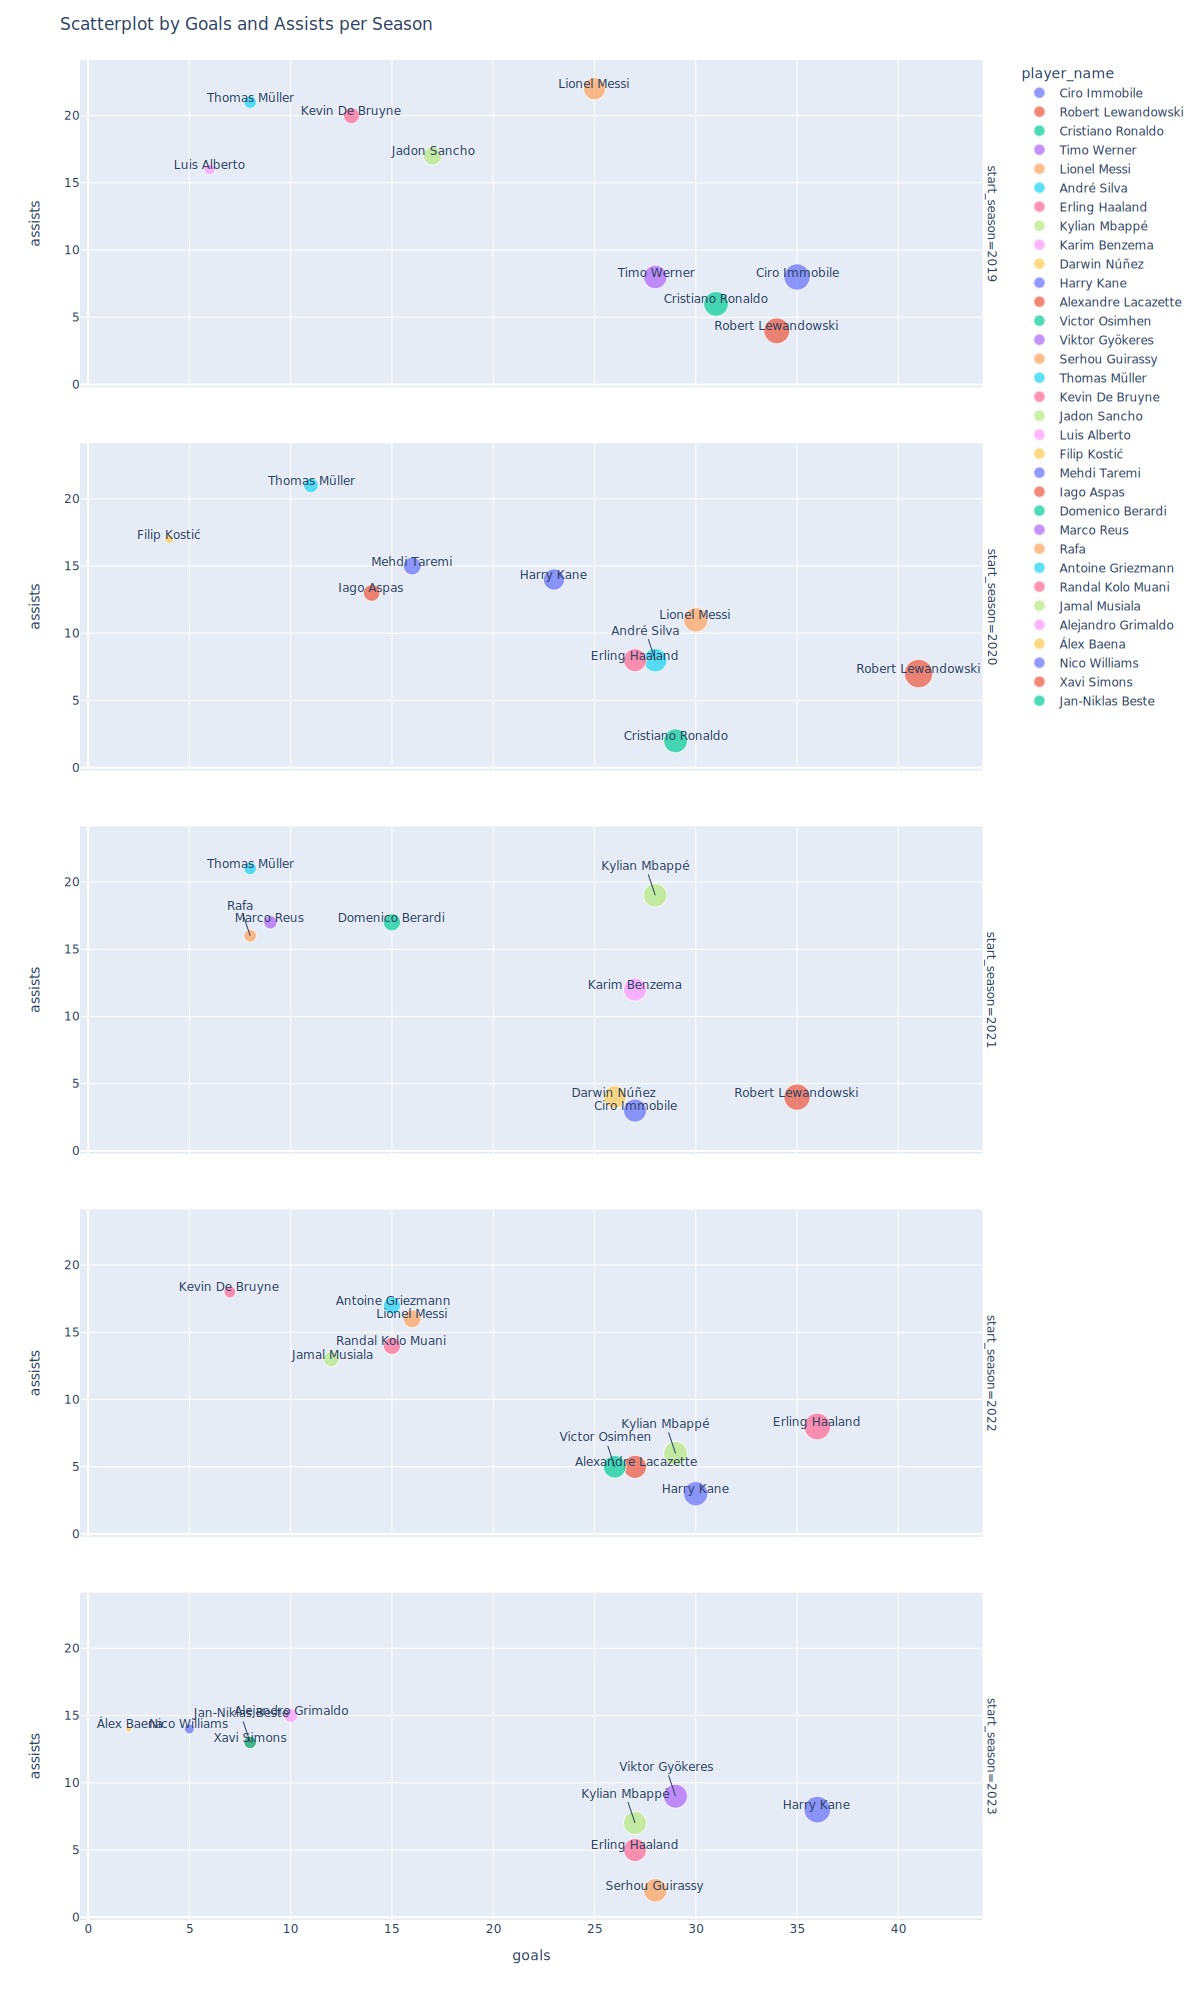

In [41]:
# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=goals_assists_top5, x="goals", y="assists", color="player_name", 
                 size="goals", facet_row="start_season", 
                 width=1200, height=2000)

overlapped_names = ["André Silva", "Rafa", "Victor Osimhen", "Ollie Watkins",
                    "Leroy Sané", "Jan-Niklas Beste", "Viktor Gyökeres", "Kylian Mbappé"]

for i, season in enumerate(goals_assists_top5["start_season"].unique()):
    seasonal = goals_assists_top5[goals_assists_top5["start_season"] == season].reset_index(drop=True)
    
    i = (-1)*(i-5)

    for j in range(seasonal.shape[0]):
            if seasonal.loc[j, "player_name"] in overlapped_names:
                fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
            else:
                fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                   text=seasonal.loc[j, "player_name"],
                                   # xanchor="left",
                                   # yanchor="bottom",
                                   showarrow=False,
                                   yshift=5,
                                   #    arrowhead=0,
                                   row=i, col=1)

fig.update_layout(title_text="Scatterplot by Goals and Assists per Season")

fig.show()

#### 10경기 이상 뛴 선수들로 시즌별 Goals, Assists Top 5 확인

In [42]:
# 10경기라 900분 이상으로 필터링
df_over_10_games = df[df.minutes_played>=900]
df_over_10_games.head()

player_name start_season  yellow_cards  red_cards  goals  assists  \
0   Aaron Connolly         2019             0          0      3        2   
3  Aaron Cresswell         2019             7          0      3        0   
4  Aaron Cresswell         2020             3          0      0        8   
5  Aaron Cresswell         2021             3          0      2        3   
6  Aaron Cresswell         2022             2          0      0        1   

   minutes_played competition_code date_of_birth  age        position  \
0            1261   premier-league    2000-01-28   20  Centre-Forward   
3            2730   premier-league    1989-12-15   30       Left-Back   
4            3172   premier-league    1989-12-15   31       Left-Back   
5            2728   premier-league    1989-12-15   32       Left-Back   
6            2237   premier-league    1989-12-15   33       Left-Back   

        current_club_name  market_value_per_season  country   foot  \
0  Brighton & Hove Albion                4000000.0  Ireland  right   
3         West Ham United                6500000.0  England   left   
4         West Ham United                5000000.0  England   left   
5         West Ham United                3000000.0  England   left   
6         West Ham United                1200000.0  England   left   

   height_in_cm  
0         174.0  
3         170.0  
4         170.0  
5         170.0  
6         170.0

In [43]:
goal_10_games_top5= df_over_10_games.groupby("start_season")[["player_name", "goals", "assists"]].apply(func1)
goal_10_games_top5.head()

player_name  goals  assists
start_season                                          
2019         2731        Ciro Immobile     35        8
             13156  Robert Lewandowski     34        4
             2891    Cristiano Ronaldo     31        6
             14980         Timo Werner     28        8
             8857         Lionel Messi     25       22

In [44]:
assist_10_games_top5 = df_over_10_games.groupby("start_season")[["player_name", "goals", "assists"]].apply(func2)
assist_10_games_top5.head()

player_name  goals  assists
start_season                                       
2019         8857      Lionel Messi     25       22
             14853    Thomas Müller      8       21
             8257   Kevin De Bruyne     13       20
             6462      Jadon Sancho     17       17
             9212      Luis Alberto      6       16

In [45]:
goals_assists_10_games_top5 = pd.concat([goal_10_games_top5, assist_10_games_top5]).reset_index()
goals_assists_10_games_top5.drop_duplicates(inplace=True)
goals_assists_10_games_top5.sort_values(by=["start_season", "assists"], ascending=[True, False], inplace=True)

In [46]:
# 10경기 이상 뛴 선수 중 시즌별 골, 어시스트 top 5를 넣은 데이터프레임 생성
goals_assists_10_games_top5.reset_index(drop=True, inplace=True)

##### 시각화 (plotly)

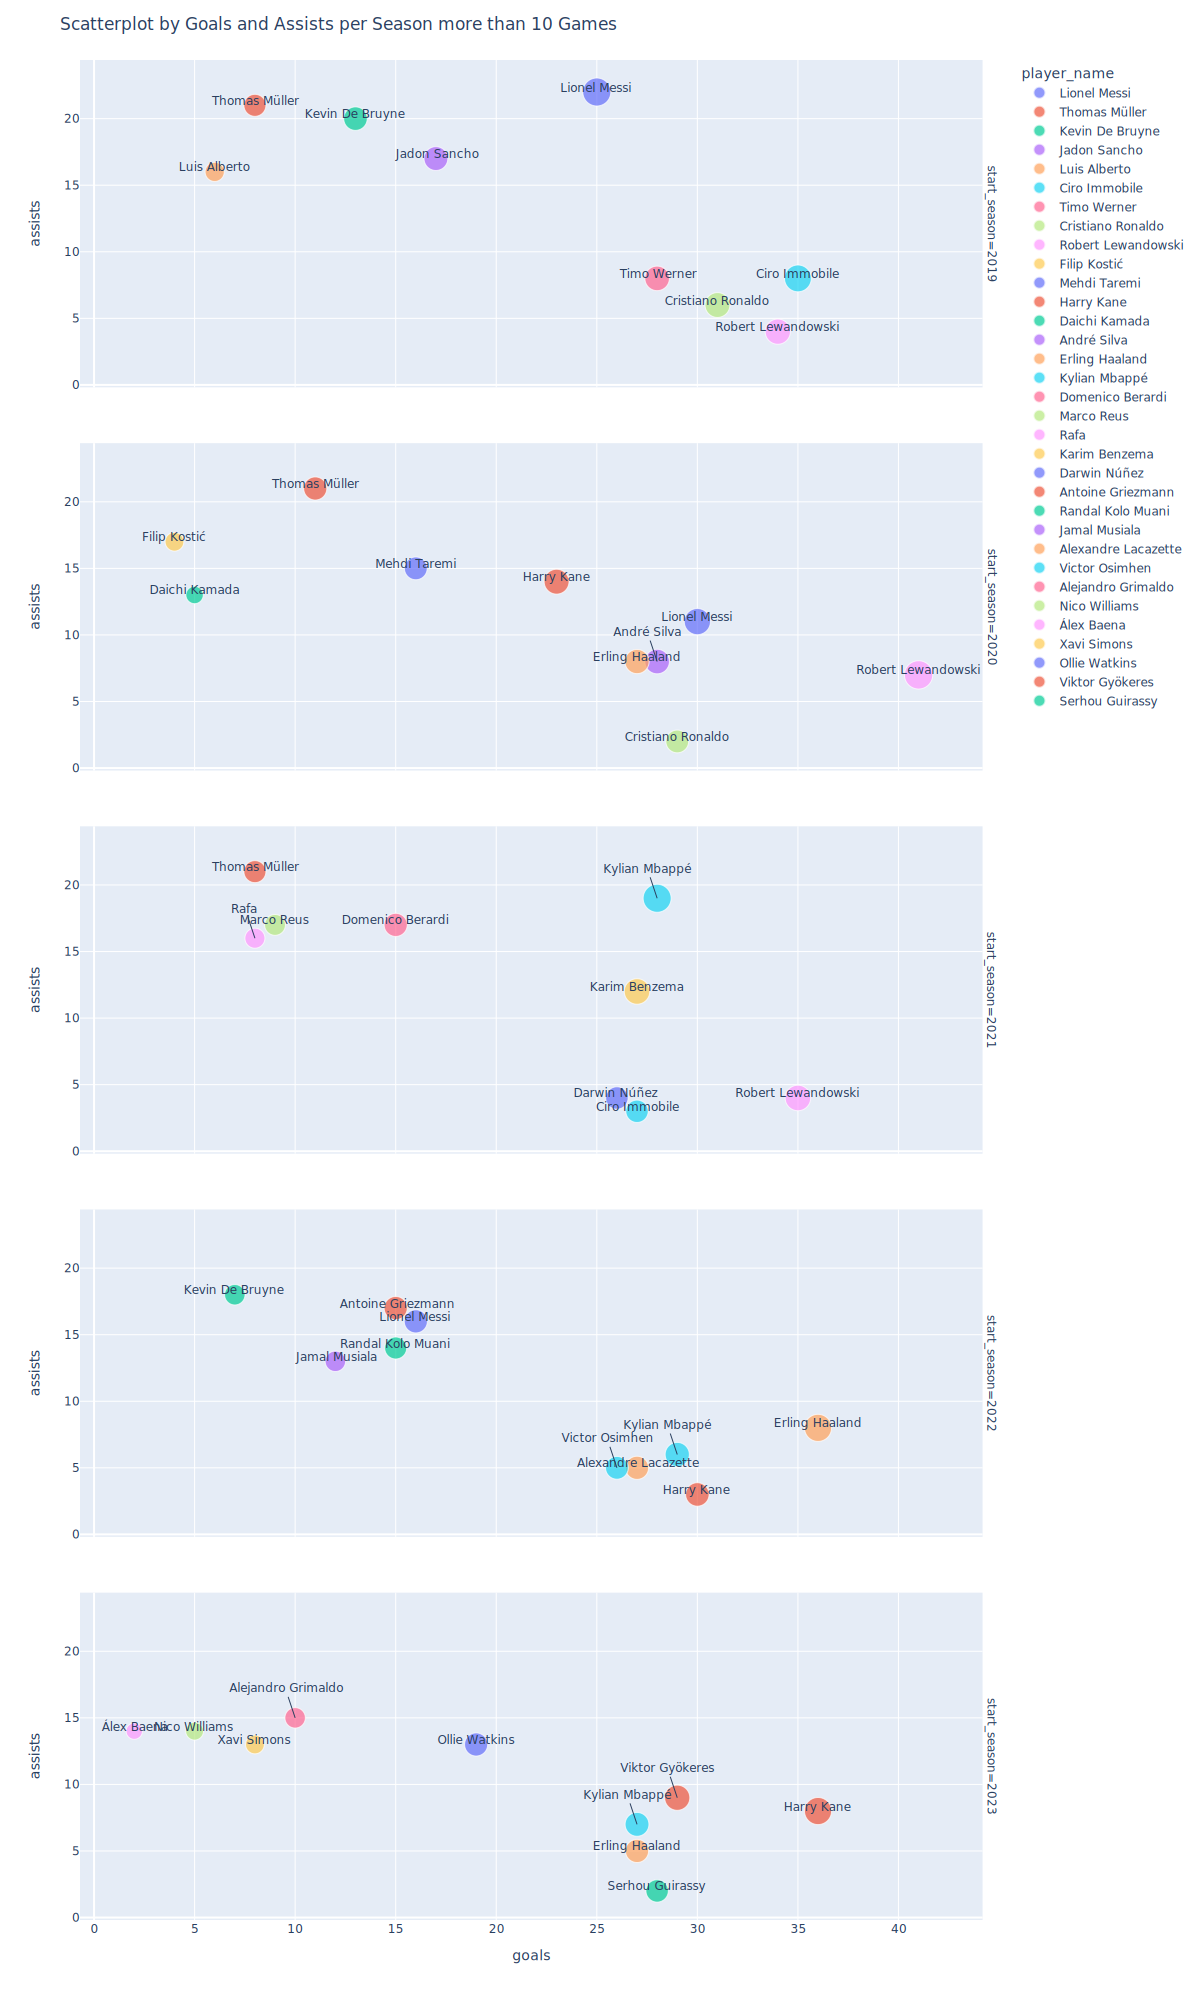

In [47]:
# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=goals_assists_10_games_top5, x="goals", y="assists", color="player_name", 
                 size=goals_assists_10_games_top5["goals"]+goals_assists_10_games_top5["assists"], 
                 facet_row=goals_assists_10_games_top5["start_season"], 
                #  text=goals_assists_10_games_top5["player_name"],
                 width=1200, height=2000)


fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 10 Games")


overlapped_names = ["André Silva", "Rafa", "Victor Osimhen", "Alejandro Grimaldo",
                    "Leroy Sané", "Jan-Niklas Beste", "Viktor Gyökeres", "Kylian Mbappé"]

for i, season in enumerate(goals_assists_10_games_top5["start_season"].unique()):
    seasonal = goals_assists_10_games_top5[goals_assists_10_games_top5["start_season"] == season].reset_index(drop=True)
    i = (-1)*(i-5)
    # print(seasonal)
    for j in range(seasonal.shape[0]):
        # print(seasonal.loc[j, "goals"])
            if seasonal.loc[j, "player_name"] in overlapped_names:
                fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
            else:
                fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                   text=seasonal.loc[j, "player_name"],
                                   # xanchor="left",
                                   # yanchor="bottom",
                                   showarrow=False,
                                   yshift=5,
                                   #    arrowhead=0,
                                   row=i, col=1)

fig.show()


### `market_value_per_season` 분석

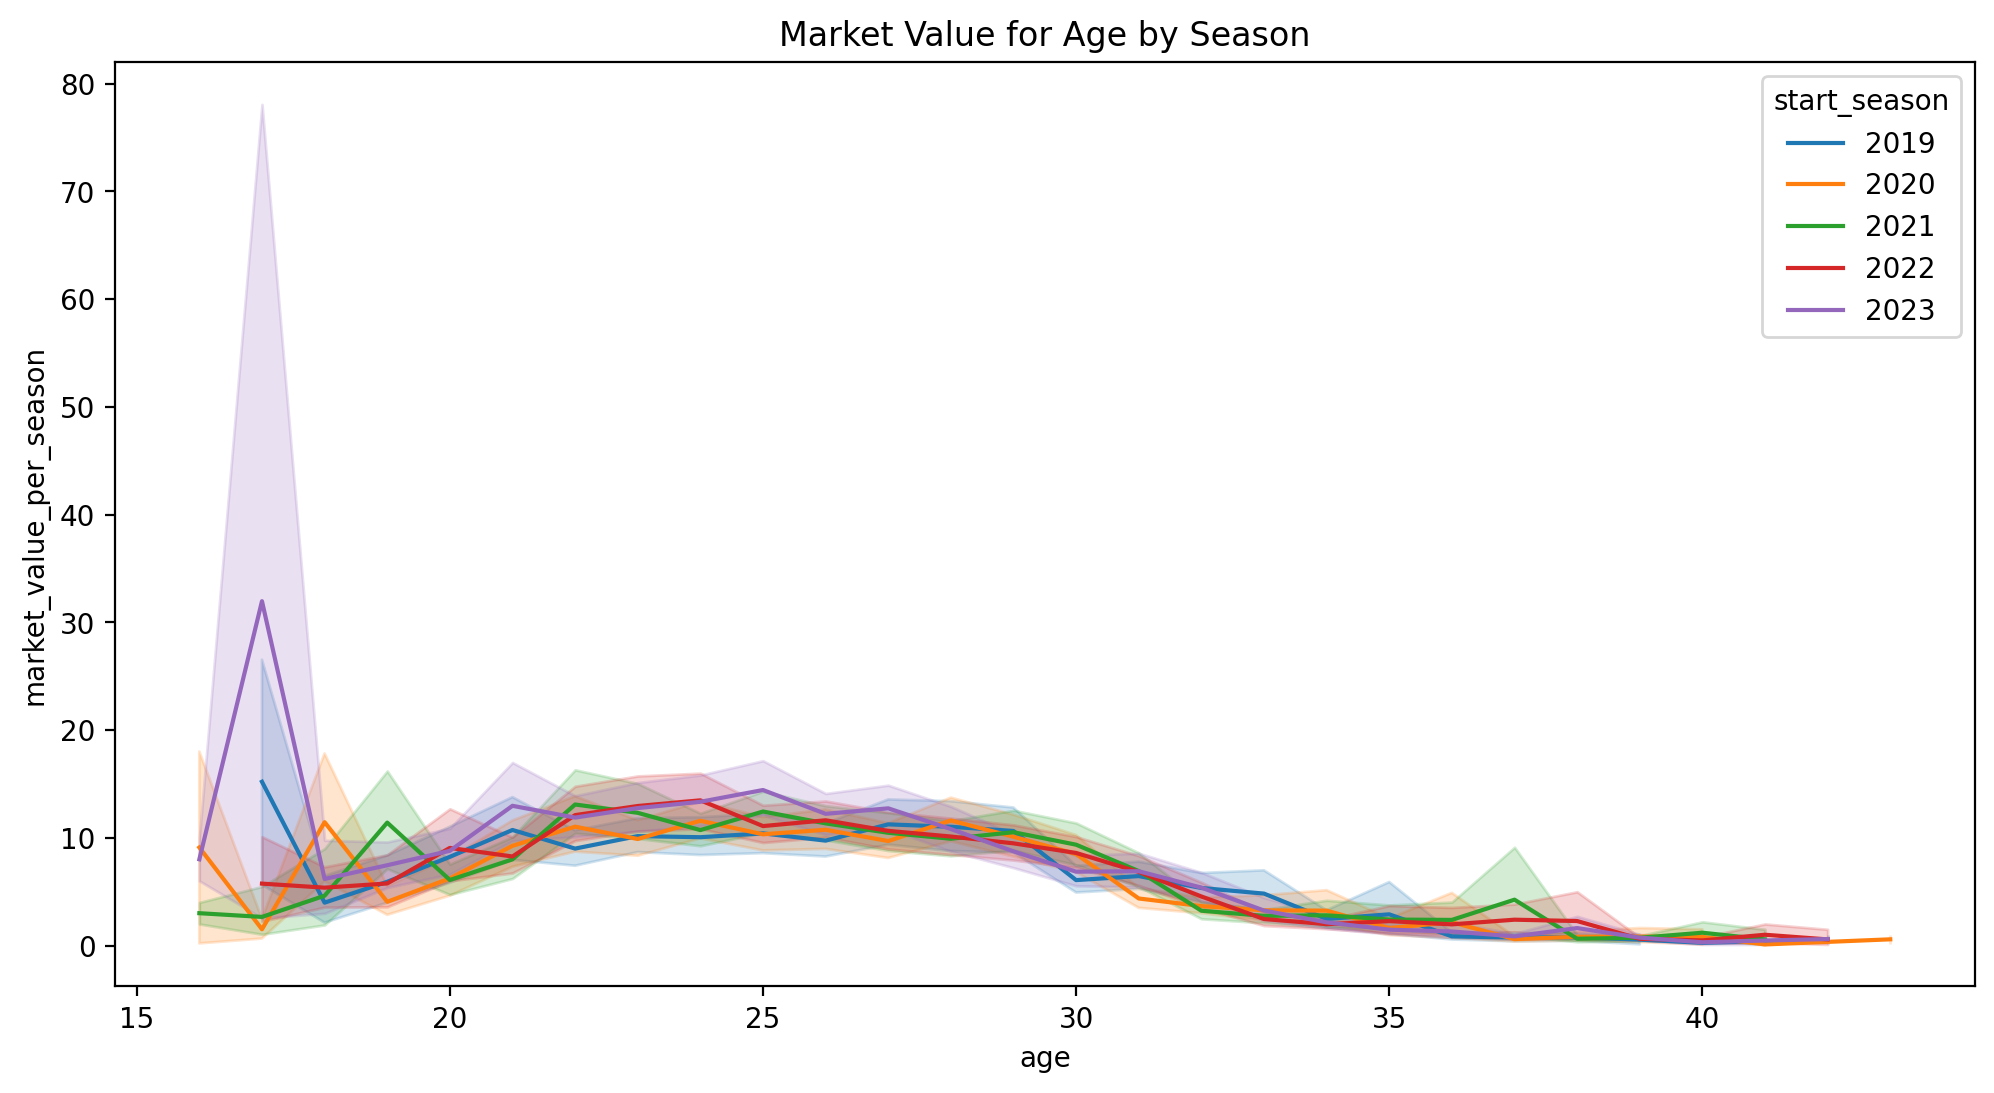

In [48]:
# 시즌, 연령에 따른 선수 몸값 변화

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df["age"], y=df["market_value_per_season"]/1000000, hue="start_season", estimator="mean")
plt.title("Market Value for Age by Season")
plt.show()

In [80]:
# 23-24 시즌 기준, 17세의 Market Value 그래프가 유독 높게 솟아 있다 (보라색 lineplot)
# 23-24 시즌 기준, 17세 이하 중 가장 높은 몸값 자랑하는 선수 확인 → Lamine Yamal

df[(df["age"]<=17) & (df["start_season"]=="2023")].sort_values("market_value_per_season", ascending=False).head(10)

player_name start_season  yellow_cards  red_cards  goals  \
8616        Lamine Yamal         2023             3          0      5   
12179        Pau Cubarsí         2023             4          0      0   
4925   Francesco Camarda         2023             0          0      0   
4342       Ethan Nwaneri         2023             0          0      0   
1657      Ayyoub Bouaddi         2023             3          0      0   
4341        Ethan Mbappé         2023             0          0      0   
15862     Yanis Issoufou         2023             0          0      0   

       assists  minutes_played competition_code date_of_birth  age  \
8616         7            2196           laliga    2007-07-13   17   
12179        0            1562           laliga    2007-01-22   17   
4925         0              12          serie-a    2008-03-10   16   
4342         0              13   premier-league    2007-03-21   17   
1657         0             126          ligue-1    2007-10-02   16   
4341         0              46          ligue-1    2006-12-29   17   
15862        0              12          ligue-1    2006-10-28   17   

                 position    current_club_name  market_value_per_season  \
8616         Right Winger         FC Barcelona              120000000.0   
12179         Centre-Back         FC Barcelona               30000000.0   
4925       Centre-Forward             AC Milan               10000000.0   
4342   Attacking Midfield           Arsenal FC                8000000.0   
1657     Central Midfield           LOSC Lille                6000000.0   
4341     Central Midfield  Paris Saint-Germain                1500000.0   
15862      Centre-Forward      Montpellier HSC                 300000.0   

       country   foot  height_in_cm  
8616     Spain   left         180.0  
12179    Spain  right         184.0  
4925     Italy   both         184.0  
4342   England   left         176.0  
1657    France  right         185.0  
4341    France   left         176.0  
15862   France   left         182.0

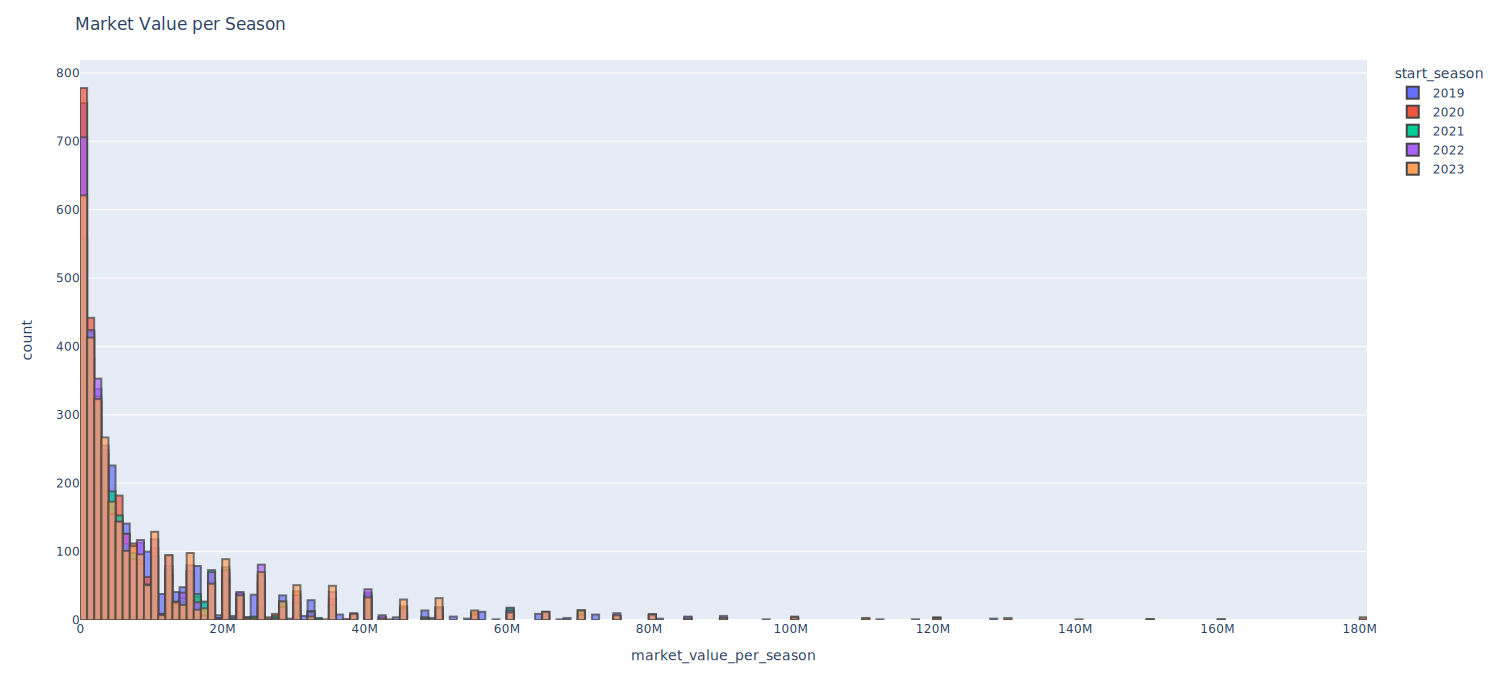

In [50]:
# 시즌별 선수 몸값
fig = px.histogram(data_frame=df, x="market_value_per_season", color="start_season",
                   width=1500, height=700)

fig.update_layout(barmode='overlay',  title_text="Market Value per Season")

fig.update_traces(marker_line_width=2, marker_opacity =0.7)

fig.show()

#### 20M 넘는 선수들로 확인

In [51]:
print("원본 df shape :", df.shape)
print("20M 유로 넘는 선수들 :", df[df.market_value_per_season >= 20000000].shape)

원본 df shape : (16360, 16)
20M 유로 넘는 선수들 : (2335, 16)


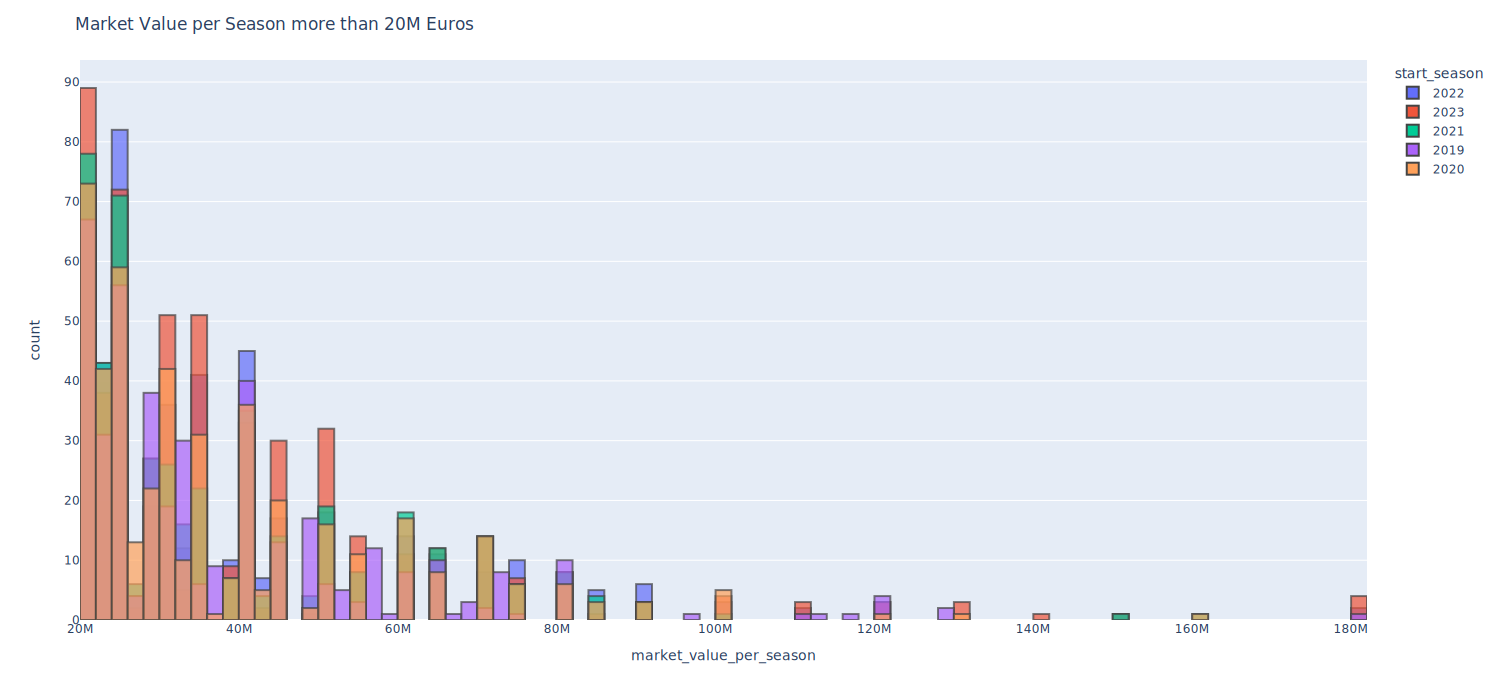

In [52]:
fig = px.histogram(data_frame=df[df.market_value_per_season >= 20000000], x="market_value_per_season", color="start_season",
                   width=1500, height=700)

fig.update_layout(barmode='overlay', title_text="Market Value per Season more than 20M Euros")

fig.update_traces(marker_line_width=2, marker_opacity =0.7)

fig.show()

#### 100M 유로 넘는 선수들 확인

In [53]:
df[df.market_value_per_season>=100000000].head(3)

player_name start_season  yellow_cards  red_cards  goals  \
1609  Aurélien Tchouaméni         2023             6          0      3   
2252          Bukayo Saka         2022             6          0     14   
2253          Bukayo Saka         2023             4          0     16   

      assists  minutes_played competition_code date_of_birth  age  \
1609        1            1986           laliga    2000-01-27   24   
2252       11            3194   premier-league    2001-09-05   22   
2253        9            2936   premier-league    2001-09-05   23   

                position current_club_name  market_value_per_season  country  \
1609  Defensive Midfield       Real Madrid              100000000.0   France   
2252        Right Winger        Arsenal FC              120000000.0  England   
2253        Right Winger        Arsenal FC              140000000.0  England   

       foot  height_in_cm  
1609  right         188.0  
2252   left         178.0  
2253   left         178.0

In [54]:
# 시장가치 100M 유로 넘는 선수들 확인

# 시장가치 100M 유로 넘는 선수들 중, player_name으로 groupby한 선수들의 market_value_per_season 최대값 중복해서 조회
mm = df[df.market_value_per_season>=100000000]
more_than_100 = mm.groupby("player_name", as_index=False).market_value_per_season.max().merge(mm)

# 득점, 어시스트 합산해서 공격포인트 (g+a) 컬럼 생성
more_than_100["g+a"] = more_than_100["goals"] + more_than_100["assists"]
more_than_100.sort_values("start_season", ascending=False).head(15)

player_name  market_value_per_season start_season  yellow_cards  \
0   Aurélien Tchouaméni              100000000.0         2023             6   
11        Jamal Musiala              130000000.0         2023             2   
27              Rodrygo              110000000.0         2023             2   
26                Rodri              130000000.0         2023             8   
24           Phil Foden              150000000.0         2023             2   
20      Martin Ødegaard              110000000.0         2023             2   
18     Lautaro Martínez              110000000.0         2023             5   
17         Lamine Yamal              120000000.0         2023             3   
1           Bukayo Saka              140000000.0         2023             4   
12      Jude Bellingham              180000000.0         2023             5   
16        Kylian Mbappé              180000000.0         2023             4   
32      Vinicius Junior              180000000.0         2023             7   
3     Eduardo Camavinga              100000000.0         2023             9   
7         Florian Wirtz              130000000.0         2023             3   
6     Federico Valverde              120000000.0         2023             2   

    red_cards  goals  assists  minutes_played competition_code date_of_birth  \
0           0      3        1            1986           laliga    2000-01-27   
11          0     10        6            1767       bundesliga    2003-02-26   
27          0     10        5            2391           laliga    2001-01-09   
26          1      8        9            2938   premier-league    1996-06-22   
24          0     19        8            2871   premier-league    2000-05-28   
20          0      8       10            3104   premier-league    1998-12-17   
18          0     24        6            2667          serie-a    1997-08-22   
17          0      5        7            2196           laliga    2007-07-13   
1           0     16        9            2936   premier-league    2001-09-05   
12          1     19        6            2324           laliga    2003-06-29   
16          0     27        7            2159          ligue-1    1998-12-20   
32          0     15        6            1875           laliga    2000-07-12   
3           0      0        2            1823           laliga    2002-11-10   
7           0     11       12            2384       bundesliga    2003-05-03   
6           0      2        7            2911           laliga    1998-07-22   

    age            position    current_club_name    country   foot  \
0    24  Defensive Midfield          Real Madrid     France  right   
11   21  Attacking Midfield        Bayern Munich    Germany  right   
27   23        Right Winger          Real Madrid     Brazil  right   
26   28  Defensive Midfield      Manchester City      Spain  right   
24   24        Right Winger      Manchester City    England   left   
20   25  Attacking Midfield           Arsenal FC     Norway   left   
18   27      Centre-Forward          Inter Milan  Argentina  right   
17   17        Right Winger         FC Barcelona      Spain   left   
1    23        Right Winger           Arsenal FC    England   left   
12   21  Attacking Midfield          Real Madrid    England  right   
16   25      Centre-Forward  Paris Saint-Germain     France  right   
32   24         Left Winger          Real Madrid     Brazil  right   
3    21    Central Midfield          Real Madrid     France   left   
7    21  Attacking Midfield  Bayer 04 Leverkusen    Germany  right   
6    26    Central Midfield          Real Madrid    Uruguay  right   

    height_in_cm  g+a  
0          188.0    4  
11         184.0   16  
27         174.0   15  
26         191.0   17  
24         171.0   27  
20         178.0   18  
18         174.0   30  
17         180.0   12  
1          178.0   25  
12         186.0   25  
16         178.0   34  
32         176.0   21  
3          182.0    2  
7        

In [55]:
more_than_100 = more_than_100.sort_values("start_season")

##### Goals, Assists 시각화

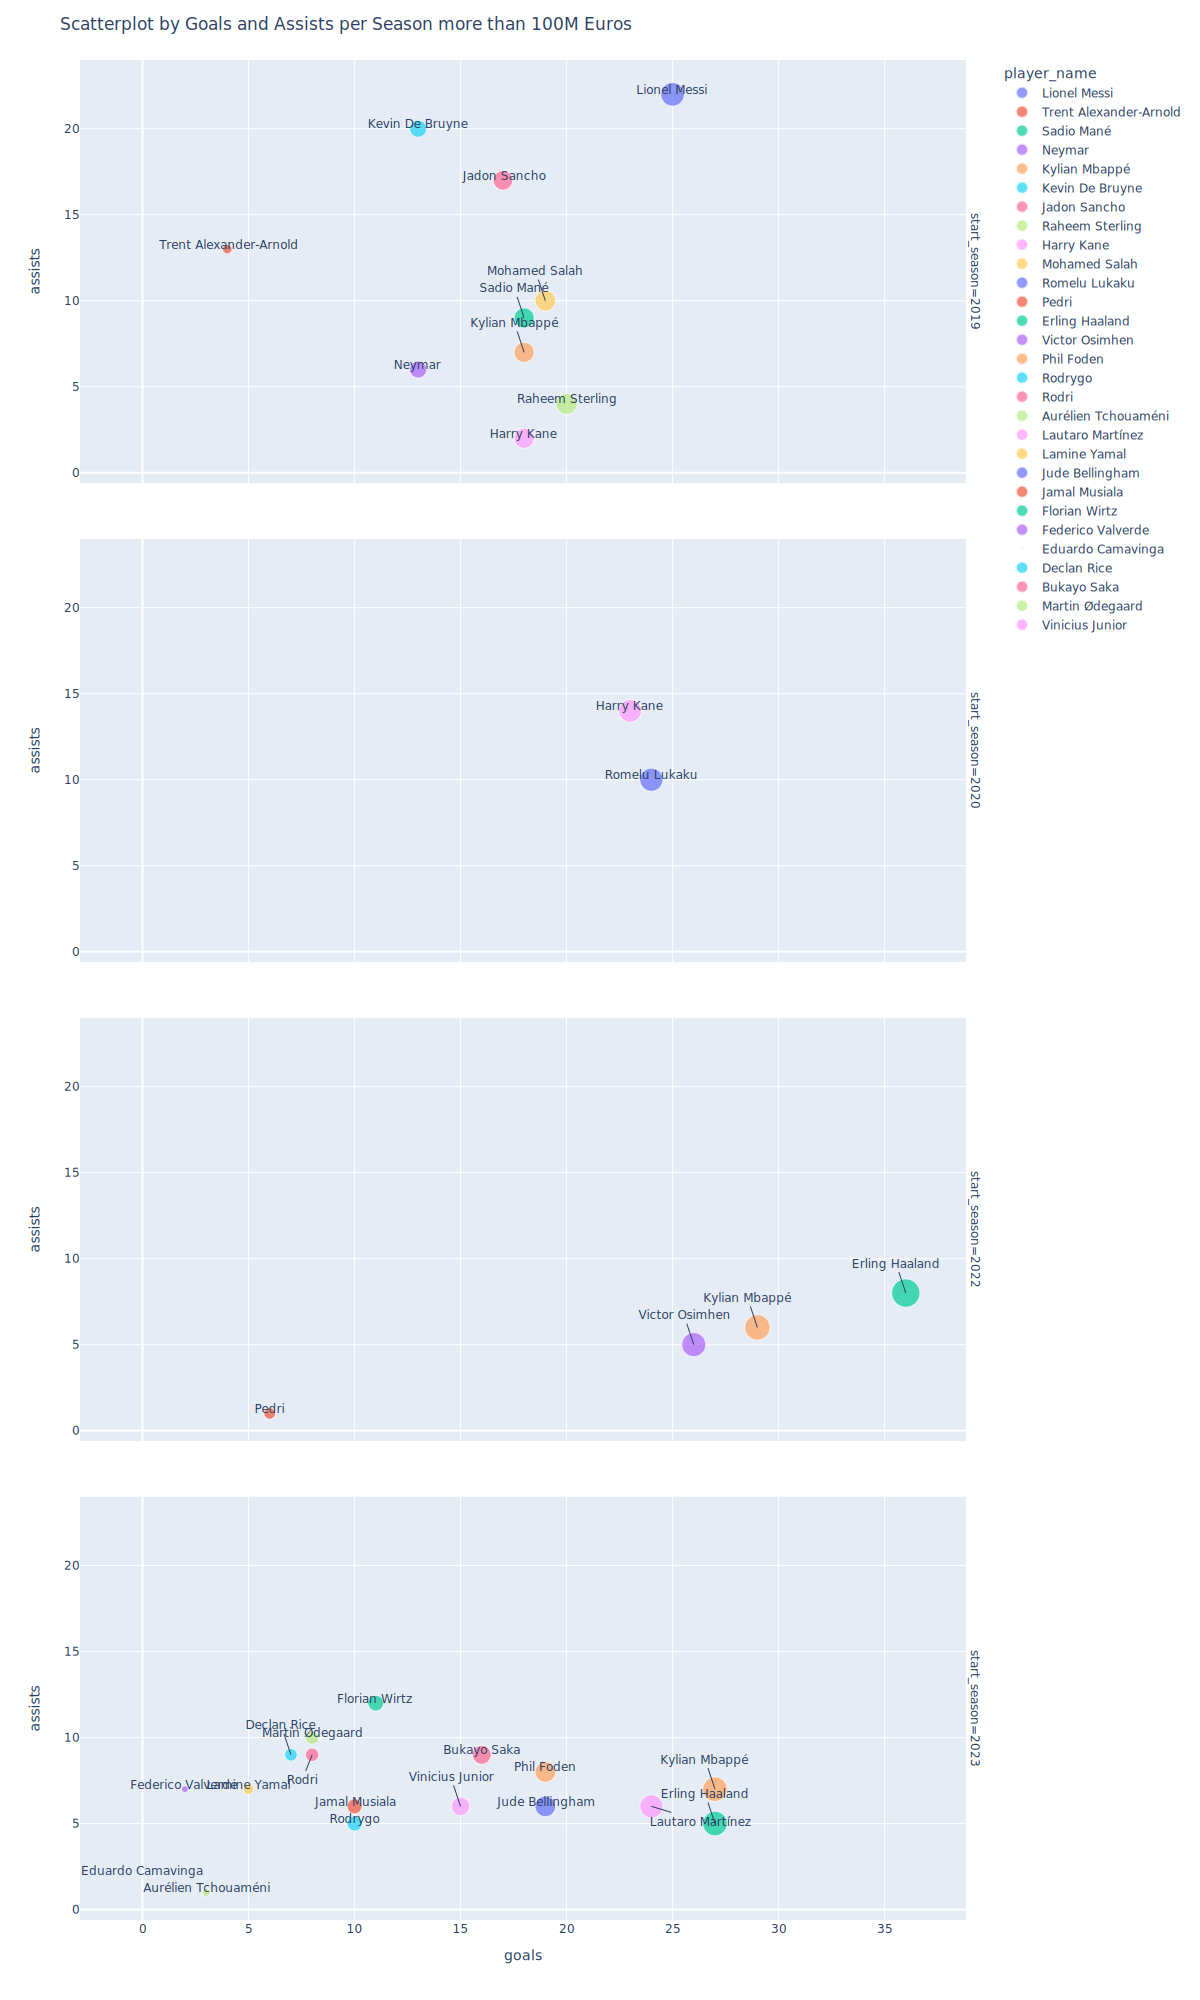

In [56]:
# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100, x="goals", y="assists", color="player_name", 
                 size="goals", facet_row="start_season", 
                #  text="player_name",
                 width=1200, height=2000)

fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 100M Euros")
# fig.update_traces(textposition="top right")

overlapped_names = ["Vinicius Junior", "Sadio Mané", "Declan Rice", "Victor Osimhen", 
                    "Mohamed Salah", "Erling Haaland", "Kylian Mbappé"]
                    # "Phil Foden",Rodrygo"]

for i, season in enumerate(more_than_100["start_season"].unique()):
    seasonal = more_than_100[more_than_100["start_season"] == season].reset_index(drop=True)
    i = (-1)*(i-4)
    # print(seasonal)
    for j in range(seasonal.shape[0]):
        # print(seasonal.loc[j, "goals"])
            if seasonal.loc[j, "player_name"] in overlapped_names:
                fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ay=-30,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                
            elif seasonal.loc[j, "player_name"] in ["Rodri"]:
                                                    # "Jamal Musiala"]:
                                 fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ay=25,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
            
            elif seasonal.loc[j, "player_name"] in ["Lautaro Martínez"]:
                                 fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ax=50,
                                    ay=15,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                 
            else:
                fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                   text=seasonal.loc[j, "player_name"],
                                   # xanchor="left",
                                   # yanchor="bottom",
                                   showarrow=False,
                                   yshift=5,
                                   #    arrowhead=0,
                                   row=i, col=1)

fig.show()

##### 공격포인트 합산 시각화

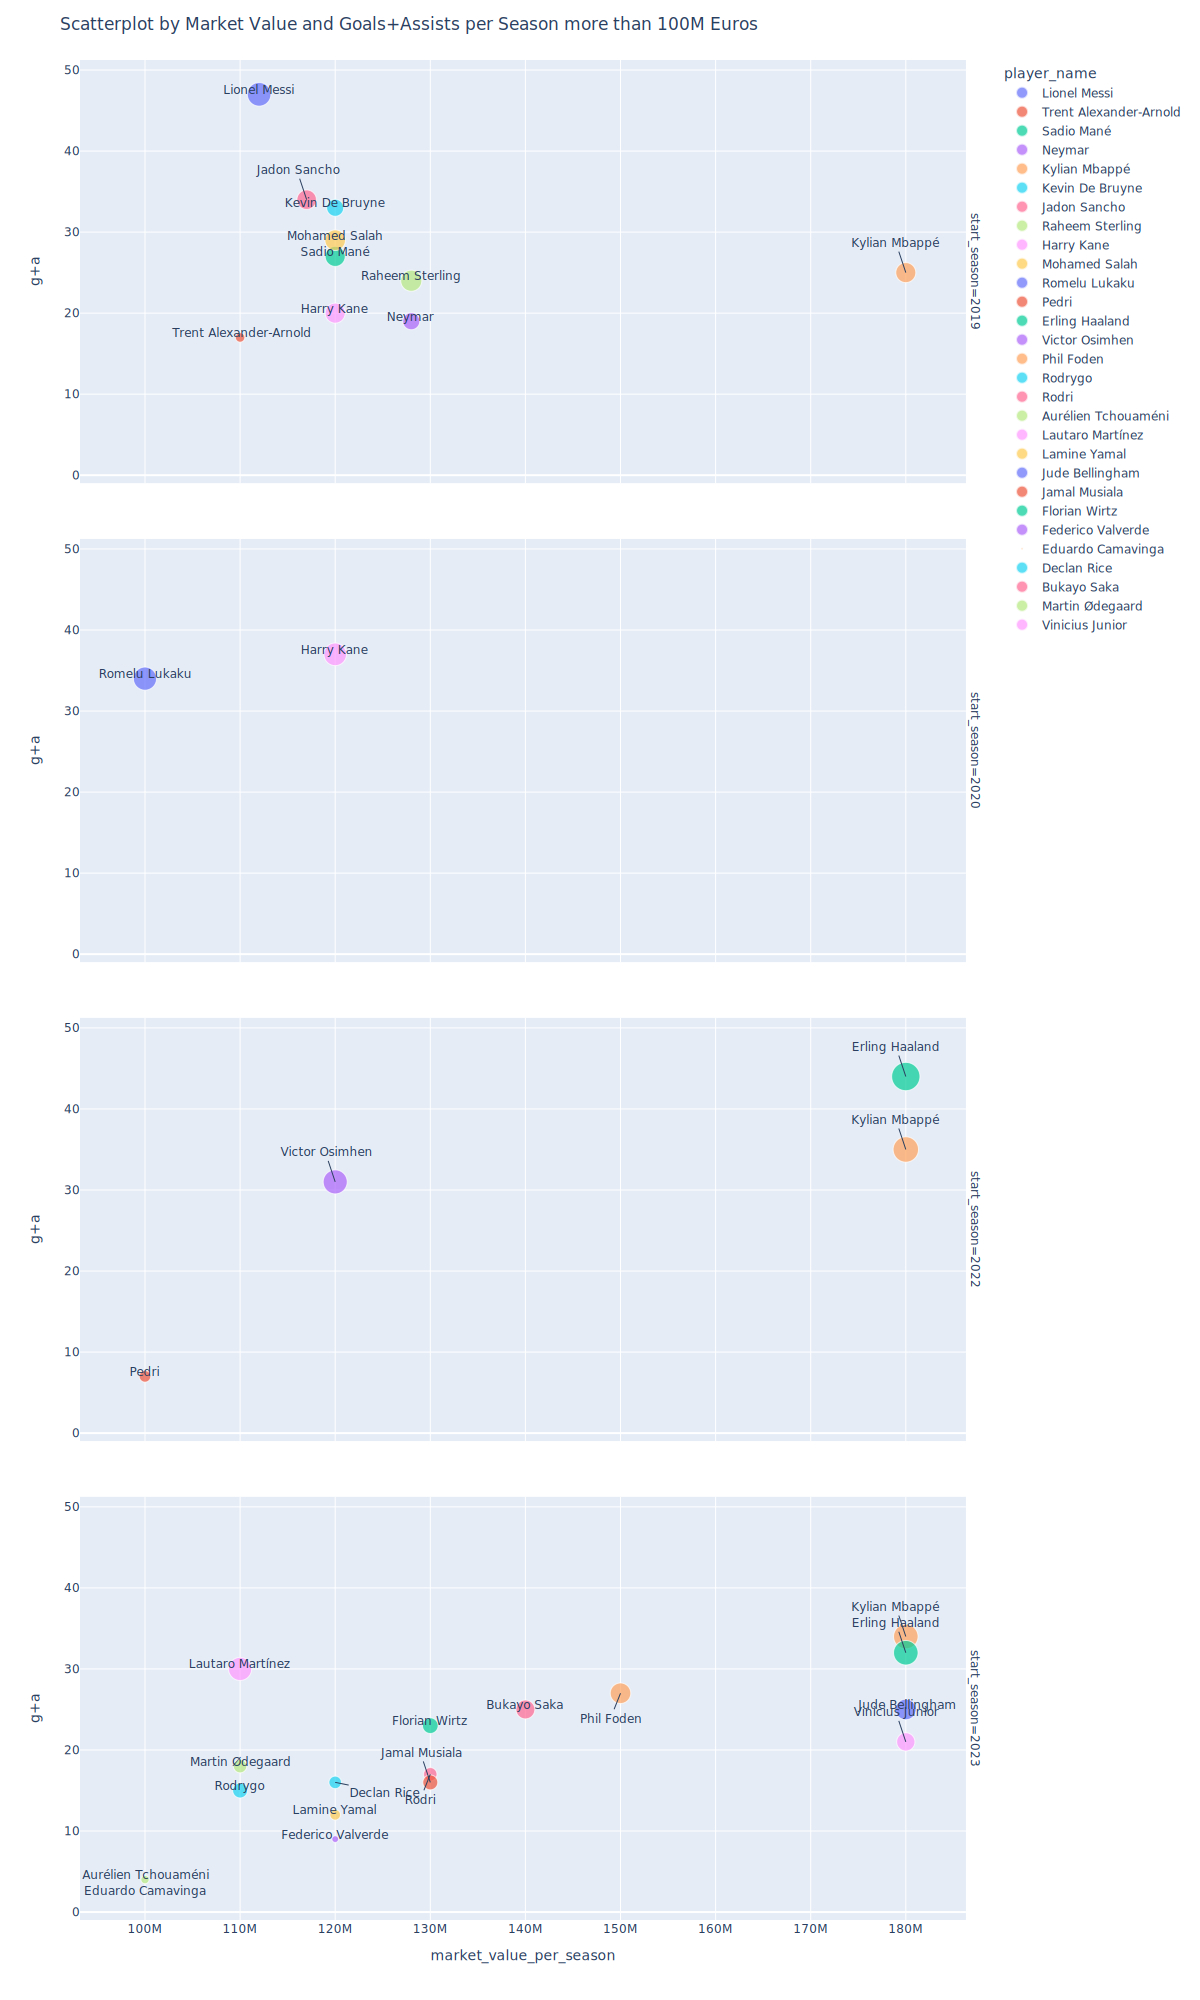

In [57]:
# 득점 + 어시스트 하나로 합친 공격포인트 시각화

# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100, x="market_value_per_season", y="g+a", color="player_name", 
                 size="goals", facet_row="start_season",
                #  text="player_name",
                 width=1200, height=2000)


overlapped_names = ["Jadon Sancho", "Jamal Musiala", "Victor Osimhen", 
                    "Vinicius Junior", "Erling Haaland", "Kylian Mbappé"]
                    # "Phil Foden",

for i, season in enumerate(more_than_100["start_season"].unique()):
    seasonal = more_than_100[more_than_100["start_season"] == season].reset_index(drop=True)
    i = (-1)*(i-4)
    # print(seasonal)
    for j in range(seasonal.shape[0]):
        # print(seasonal.loc[j, "goals"])
            if seasonal.loc[j, "player_name"] in overlapped_names:
                fig.add_annotation(x=seasonal.loc[j, "market_value_per_season"], y=seasonal.loc[j, "g+a"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ay=-30,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                
            elif seasonal.loc[j, "player_name"] in ["Rodri", "Phil Foden"]:
                                                    # "Rodrygo"]:
                                 fig.add_annotation(x=seasonal.loc[j, "market_value_per_season"], y=seasonal.loc[j, "g+a"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    # ax = 25,
                                    ay=25,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
            
            elif seasonal.loc[j, "player_name"] == "Declan Rice":
                                 fig.add_annotation(x=seasonal.loc[j, "market_value_per_season"], y=seasonal.loc[j, "g+a"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ax = 50,
                                    ay=10,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                 
            else:
                fig.add_annotation(x=seasonal.loc[j, "market_value_per_season"], y=seasonal.loc[j, "g+a"],
                                   text=seasonal.loc[j, "player_name"],
                                   # xanchor="left",
                                   # yanchor="bottom",
                                   showarrow=False,
                                   yshift=5,
                                   #    arrowhead=0,
                                   row=i, col=1)

fig.update_layout(title_text="Scatterplot by Market Value and Goals+Assists per Season more than 100M Euros")
# fig.update_traces(textposition="top center")
fig.show()

#### 포지션별 평균 market_value_per_season

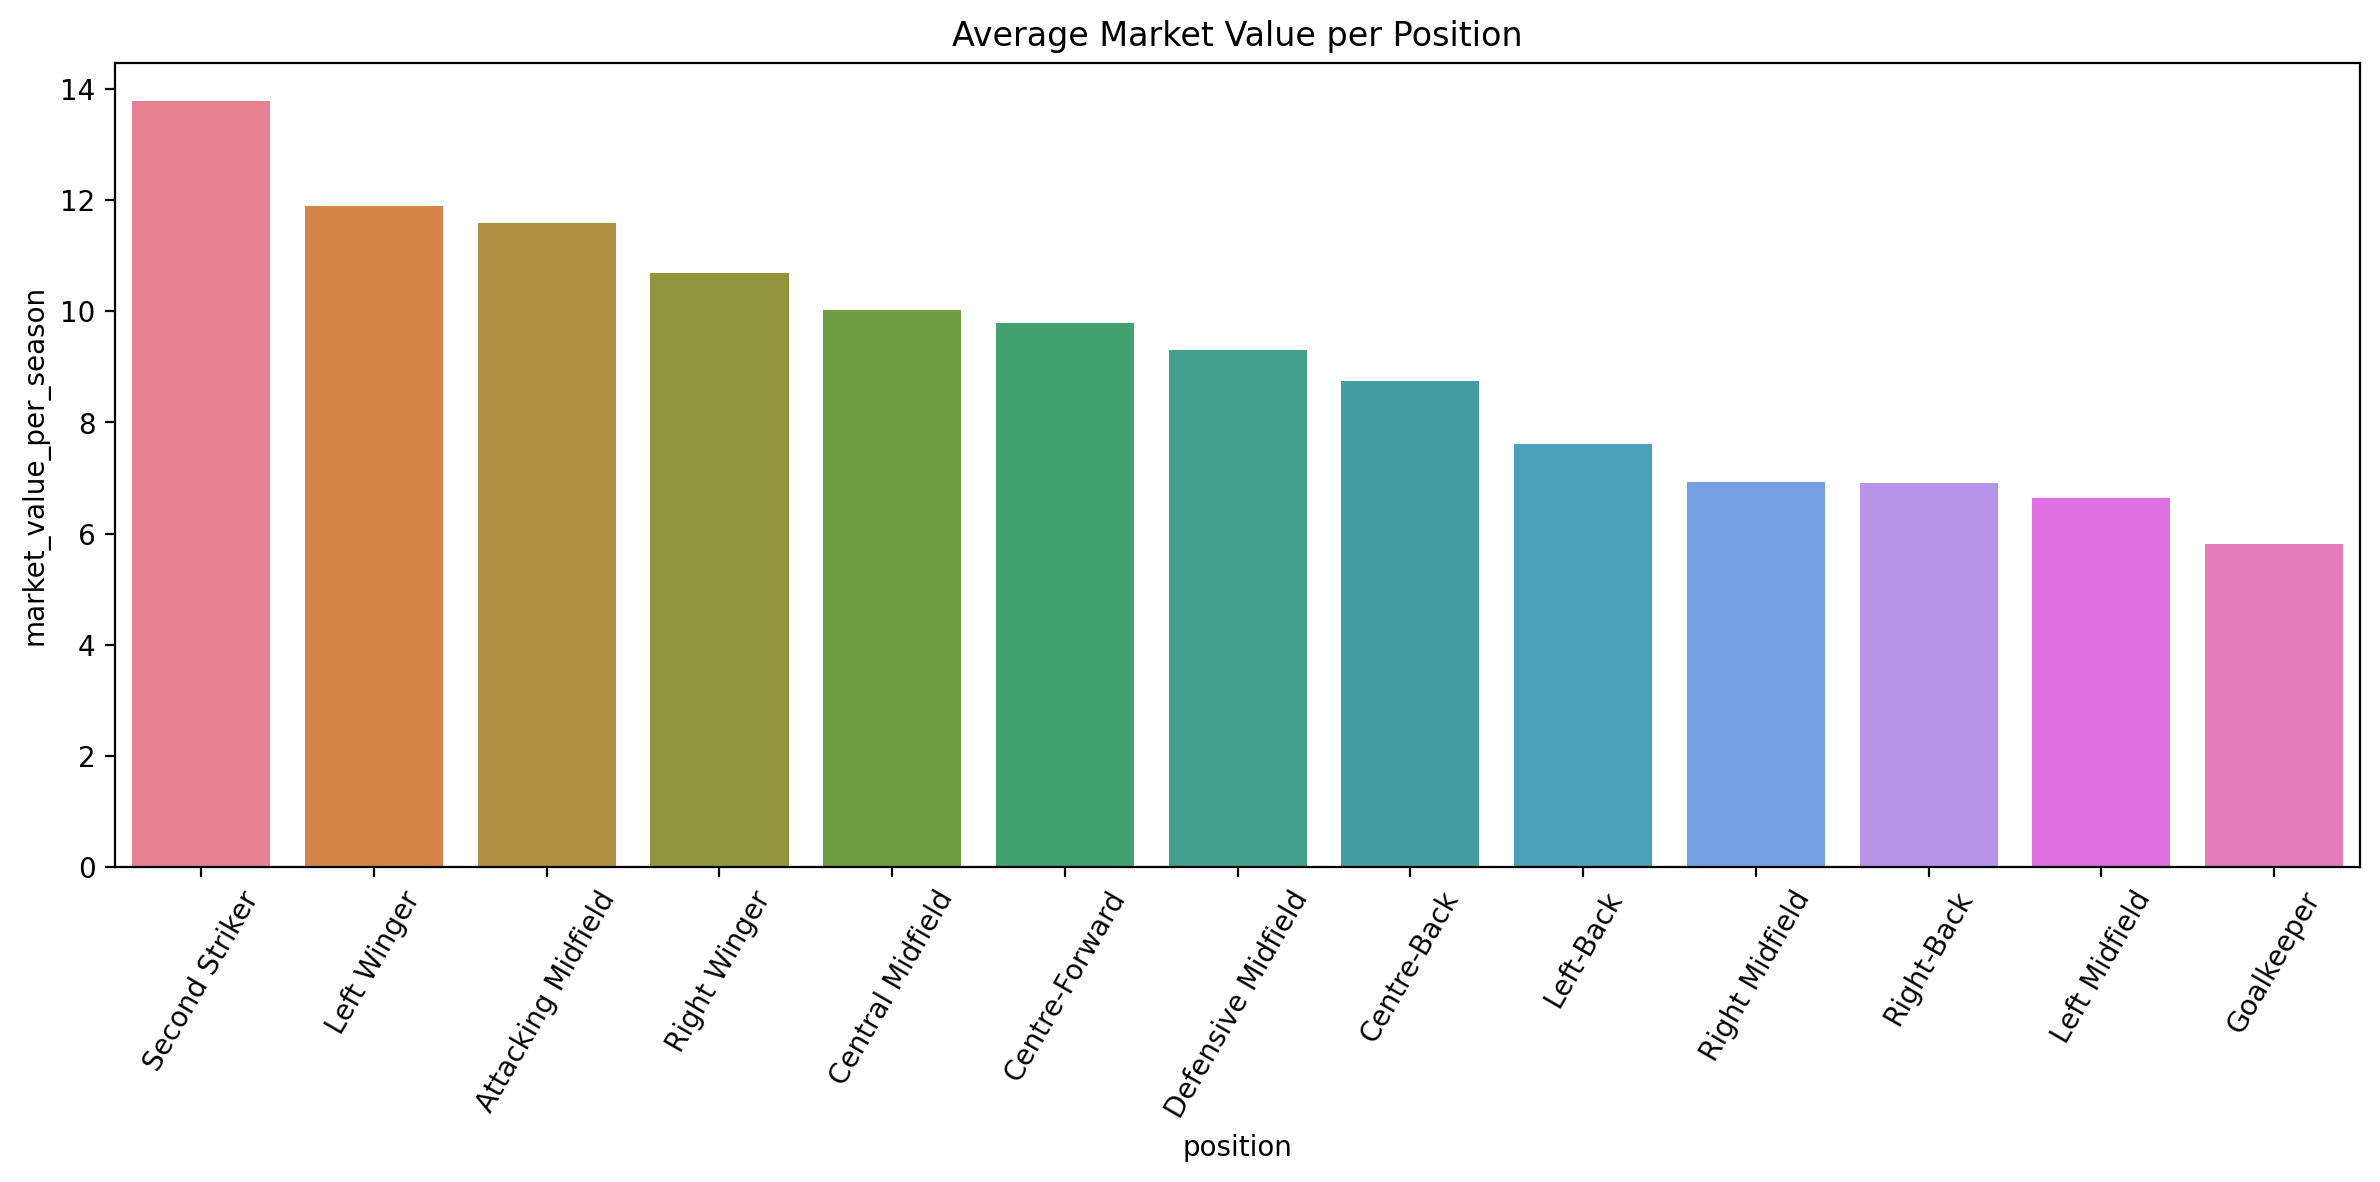

In [58]:
# Left Winger가 가장 평균 몸값이 비싸다
plt.figure(figsize=(12, 6))

per_position = df.groupby("position").mean("market_value_per_season").sort_values("market_value_per_season", ascending=False).reset_index()

g = sns.barplot(data=per_position, x="position", y=per_position["market_value_per_season"]/1000000,
                # dodge=False,
                hue="position")
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.title("Average Market Value per Position")
plt.tight_layout()
plt.show()


In [59]:
# Left Winger 몸값 비싼 순위 Top 5
df[df.position=="Left Winger"].sort_values("market_value_per_season", ascending=False).head(5)

player_name start_season  yellow_cards  red_cards  goals  assists  \
15469  Vinicius Junior         2023             7          0     15        6   
15468  Vinicius Junior         2022            10          1     10       10   
11447           Neymar         2019             4          0     13        6   
12774  Raheem Sterling         2019             5          0     20        4   
13710       Sadio Mané         2019             3          0     18        9   

       minutes_played competition_code date_of_birth  age     position  \
15469            1875           laliga    2000-07-12   24  Left Winger   
15468            2833           laliga    2000-07-12   23  Left Winger   
11447            1322          ligue-1    1992-02-05   28  Left Winger   
12774            2660   premier-league    1994-12-08   25  Left Winger   
13710            2755   premier-league    1992-04-10   28  Left Winger   

         current_club_name  market_value_per_season  country   foot  \
15469          Real Madrid              180000000.0   Brazil  right   
15468          Real Madrid              150000000.0   Brazil  right   
11447  Paris Saint-Germain              128000000.0   Brazil  right   
12774           Chelsea FC              128000000.0  England  right   
13710        Bayern Munich              120000000.0  Senegal  right   

       height_in_cm  
15469         176.0  
15468         176.0  
11447         175.0  
12774         170.0  
13710         174.0

### `Age` 분석

#### 전체, 20M 유로 이상, 100M 유로 이상 몸값인 선수들끼리 비교

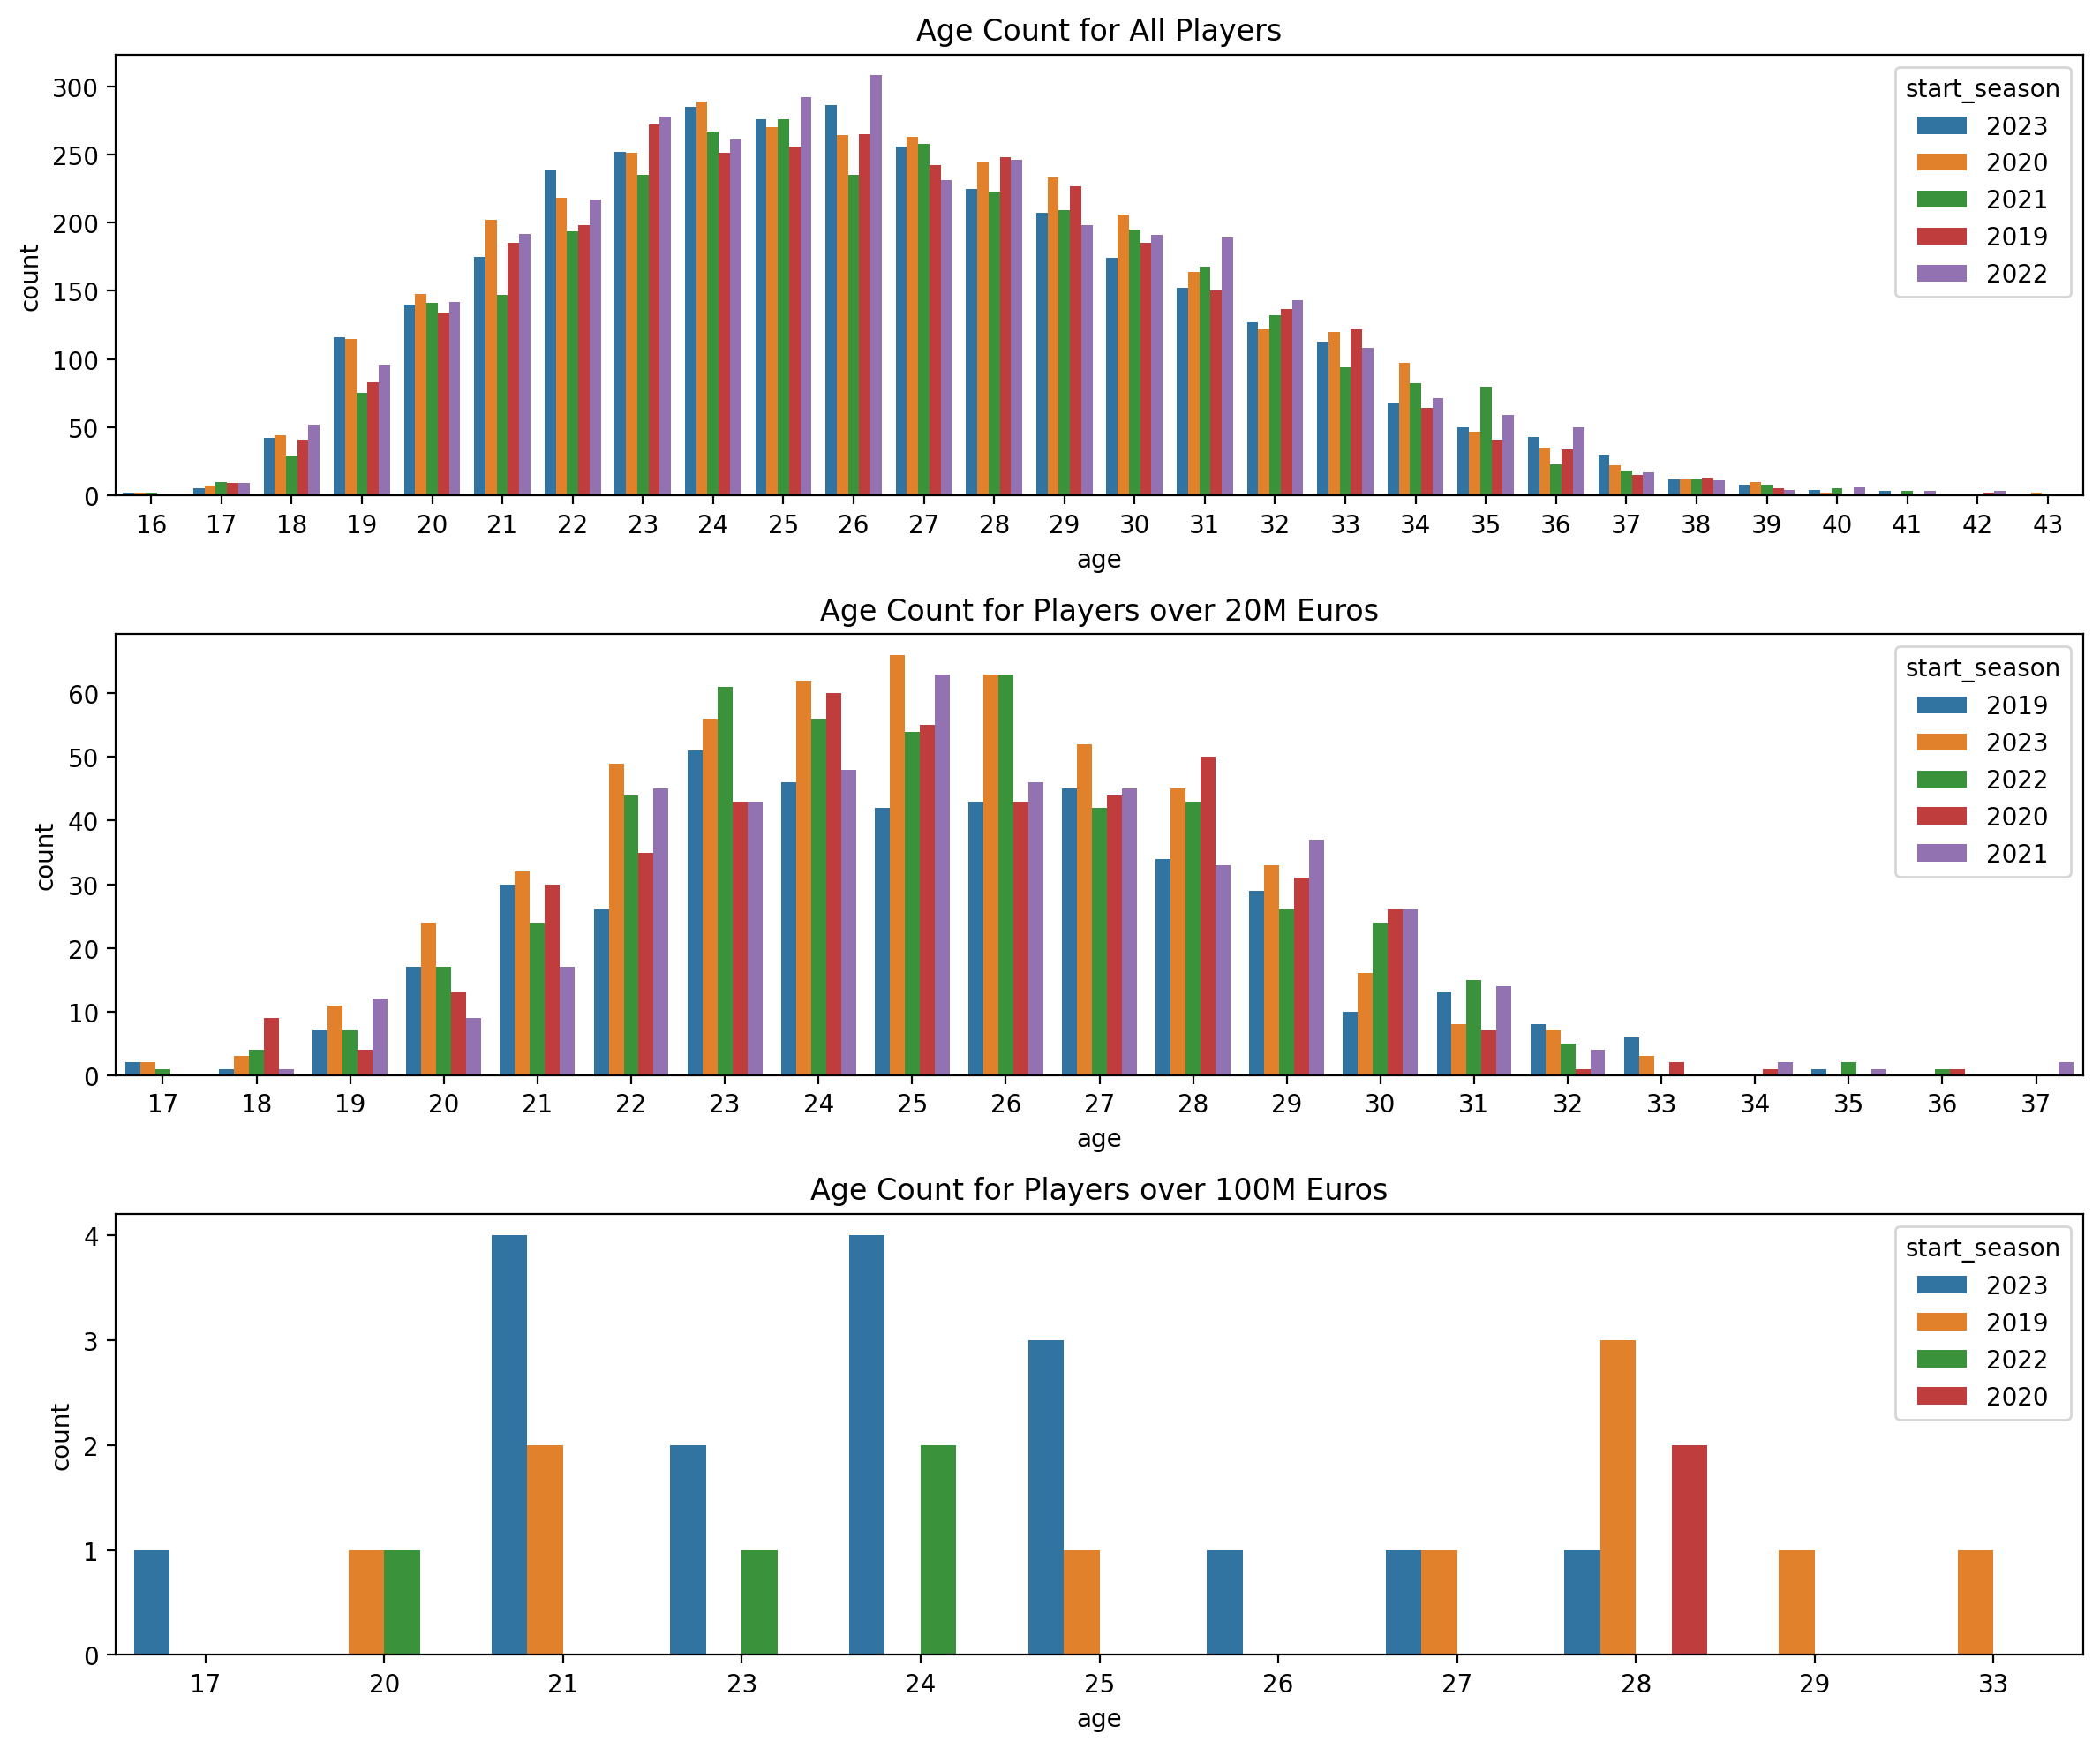

In [60]:
nrows, ncols = 3, 1
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10))

hue_order = [2019, 2020, 2021, 2022, 2023]
# flatten()을 통해axes를 1차원 array로 펴줘야 한다
# axes = axes.T.flatten()

g1 = sns.countplot(data=df, x="age", hue="start_season", ax=axes[0])
g2 = sns.countplot(data=df[df.market_value_per_season >= 20000000], x="age", hue="start_season", ax=axes[1])
g3 = sns.countplot(data=more_than_100, x="age", hue="start_season", ax=axes[2])

g1.set_title("Age Count for All Players")
g2.set_title("Age Count for Players over 20M Euros")
g3.set_title("Age Count for Players over 100M Euros")

plt.tight_layout()
plt.show()


##### 100M 유로 넘는 선수들 공격포인트와 `age` 비교

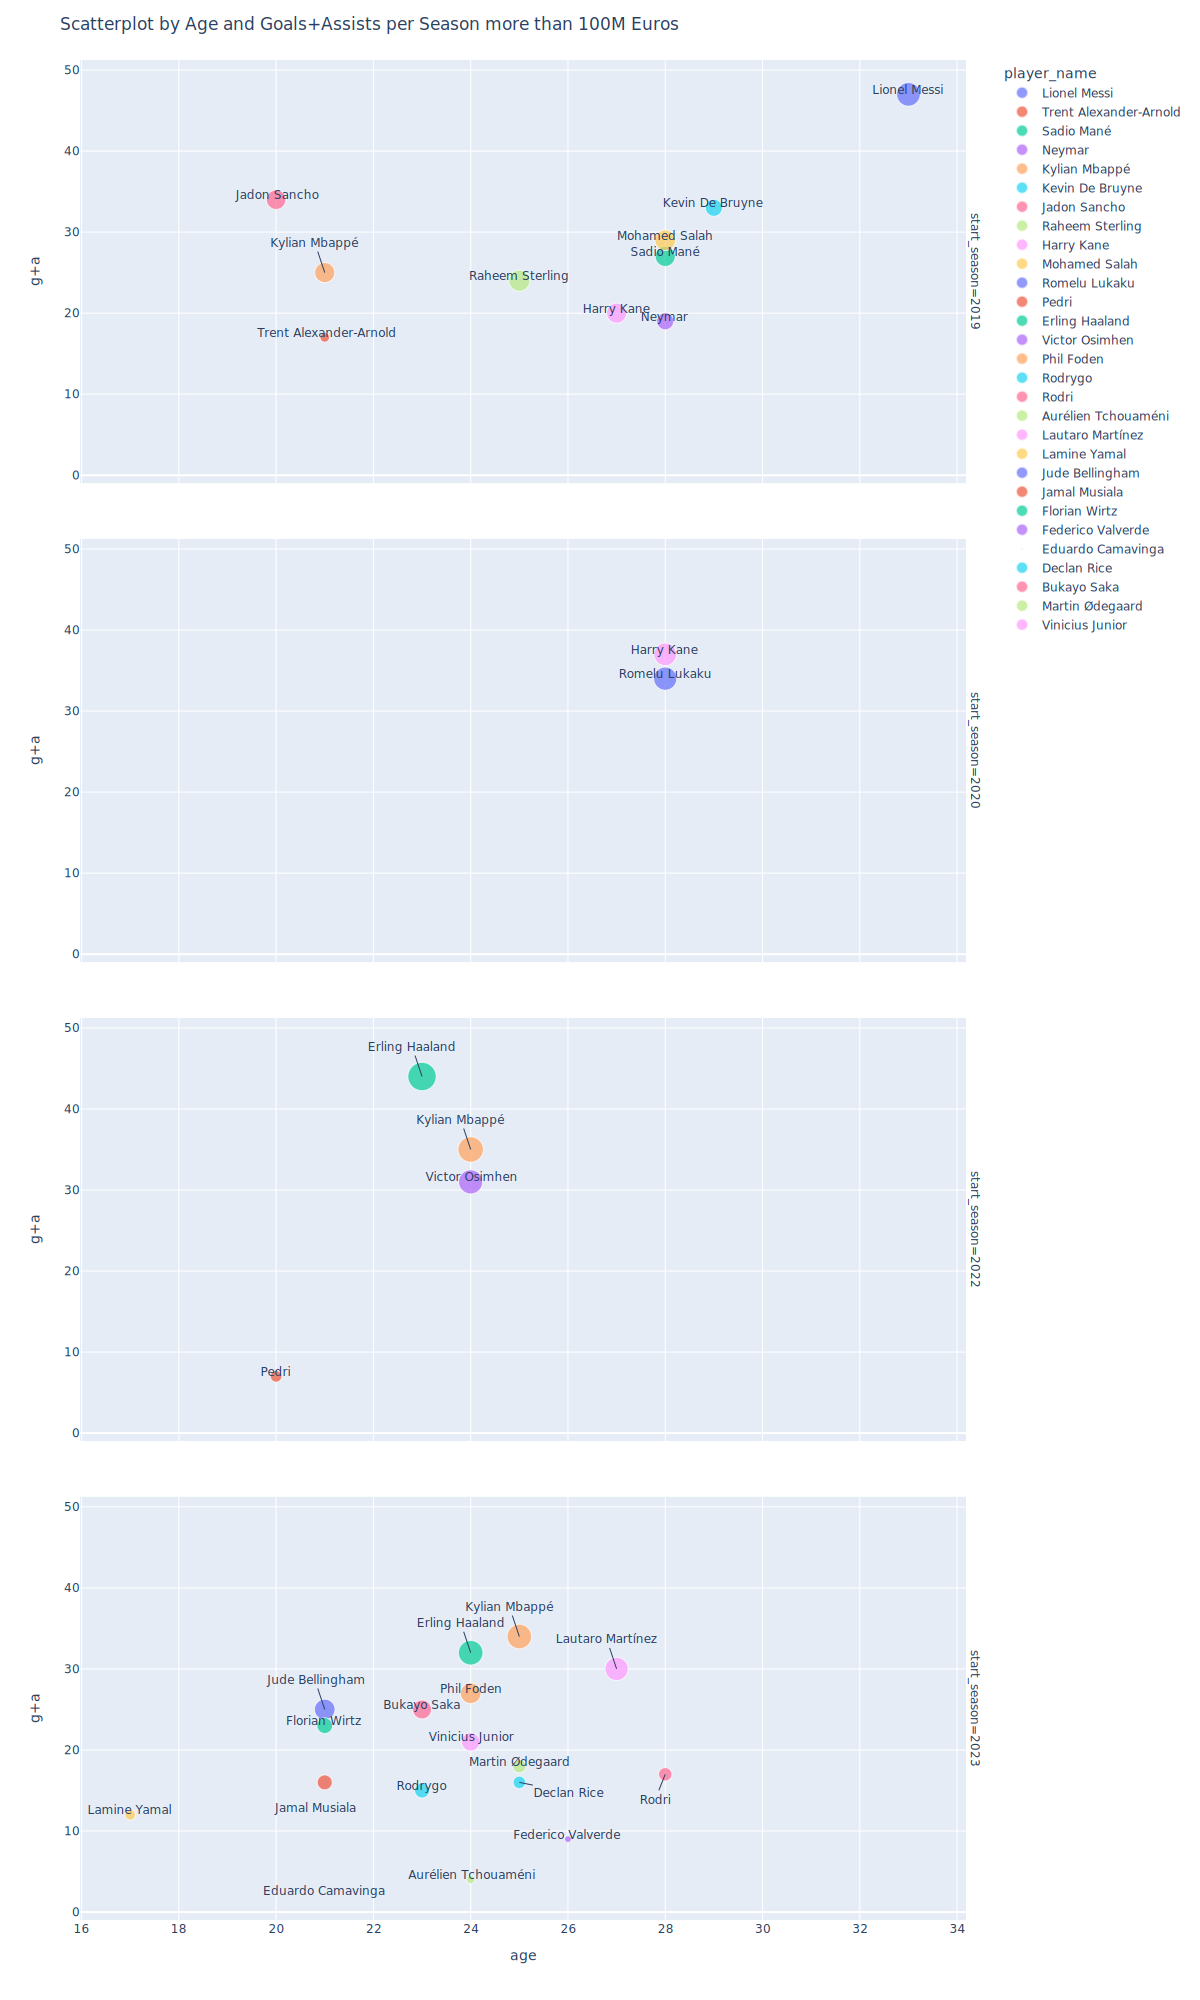

In [61]:
# 득점 + 어시스트 하나로 합친 공격포인트 시각화

# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100, x="age", y="g+a", color="player_name", 
                 size="goals", facet_row="start_season",
                #  text="player_name",
                 width=1200, height=2000)


overlapped_names = ["Erling Haaland", "Kylian Mbappé", "Lautaro Martínez", "Jude Bellingham"]

for i, season in enumerate(more_than_100["start_season"].unique()):
    seasonal = more_than_100[more_than_100["start_season"] == season].reset_index(drop=True)
    i = (-1)*(i-4)
    # print(seasonal)
    for j in range(seasonal.shape[0]):
        # print(seasonal.loc[j, "goals"])
            if seasonal.loc[j, "player_name"] in overlapped_names:
                fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "g+a"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ay=-30,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                
            elif seasonal.loc[j, "player_name"] in ["Rodri", "Jamal Musiala"]:
                                 fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "g+a"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    # ax = 25,
                                    ay=25,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
            
            elif seasonal.loc[j, "player_name"] in ["Declan Rice"]:
                                 fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "g+a"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ax = 50,
                                    ay=10,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                 
            else:
                fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "g+a"],
                                   text=seasonal.loc[j, "player_name"],
                                   # xanchor="left",
                                   # yanchor="bottom",
                                   showarrow=False,
                                   yshift=5,
                                   #    arrowhead=0,
                                   row=i, col=1)

fig.update_layout(title_text="Scatterplot by Age and Goals+Assists per Season more than 100M Euros")
fig.update_traces(textposition="top center")
fig.show()

##### 100M 유로 넘는 선수들 `market_value_per_season`과 `age` 비교

In [62]:
more_than_100

player_name  market_value_per_season start_season  \
19            Lionel Messi              112000000.0         2019   
30  Trent Alexander-Arnold              110000000.0         2019   
29              Sadio Mané              120000000.0         2019   
22                  Neymar              128000000.0         2019   
14           Kylian Mbappé              180000000.0         2019   
13         Kevin De Bruyne              120000000.0         2019   
10            Jadon Sancho              117000000.0         2019   
25         Raheem Sterling              128000000.0         2019   
8               Harry Kane              120000000.0         2019   
21           Mohamed Salah              120000000.0         2019   
9               Harry Kane              120000000.0         2020   
28           Romelu Lukaku              100000000.0         2020   
23                   Pedri              100000000.0         2022   
4           Erling Haaland              180000000.0         2022   
15           Kylian Mbappé              180000000.0         2022   
31          Victor Osimhen              120000000.0         2022   
24              Phil Foden              150000000.0         2023   
27                 Rodrygo              110000000.0         2023   
26                   Rodri              130000000.0         2023   
0      Aurélien Tchouaméni              100000000.0         2023   
16           Kylian Mbappé              180000000.0         2023   
18        Lautaro Martínez              110000000.0         2023   
17            Lamine Yamal              120000000.0         2023   
12         Jude Bellingham              180000000.0         2023   
11           Jamal Musiala              130000000.0         2023   
7            Florian Wirtz              130000000.0         2023   
6        Federico Valverde              120000000.0         2023   
5           Erling Haaland              180000000.0         2023   
3        Eduardo Camavinga              100000000.0         2023   
2              Declan Rice              120000000.0         2023   
1              Bukayo Saka              140000000.0         2023   
20         Martin Ødegaard              110000000.0         2023   
32         Vinicius Junior              180000000.0         2023   

    yellow_cards  red_cards  goals  assists  minutes_played competition_code  \
19             4          0     25       22            2880           laliga   
30             5          0      4       13            3176   premier-league   
29             3          0     18        9            2755   premier-league   
22             4          0     13        6            1322          ligue-1   
14             0          0     18        7            1515          ligue-1   
13             3          0     13       20            2800   premier-league   
10             2          0     17       17            2292       bundesliga   
25             5          0     20        4            2660   premier-league   
8              4          0     18        2            2590   premier-league   
21             1          0     19       10            2888   premier-league   
9              1          0     23       14            3086   premier-league   
28             4          0     24       10            2978          serie-a   
23             2          0      6        1            1982           laliga   
4              5          0     36        8            2777   premier-league   
15             6          0     29        6            2822          ligue-1   
31             4          0     26        5            2581          serie-a   
24             2          0     19        8            2871   premier-league   
27             2          0     10        5            2391           laliga   
26             8          1      8        9            2938   premier-league   
0              6          0      3        1            1986           laliga   
16             4      

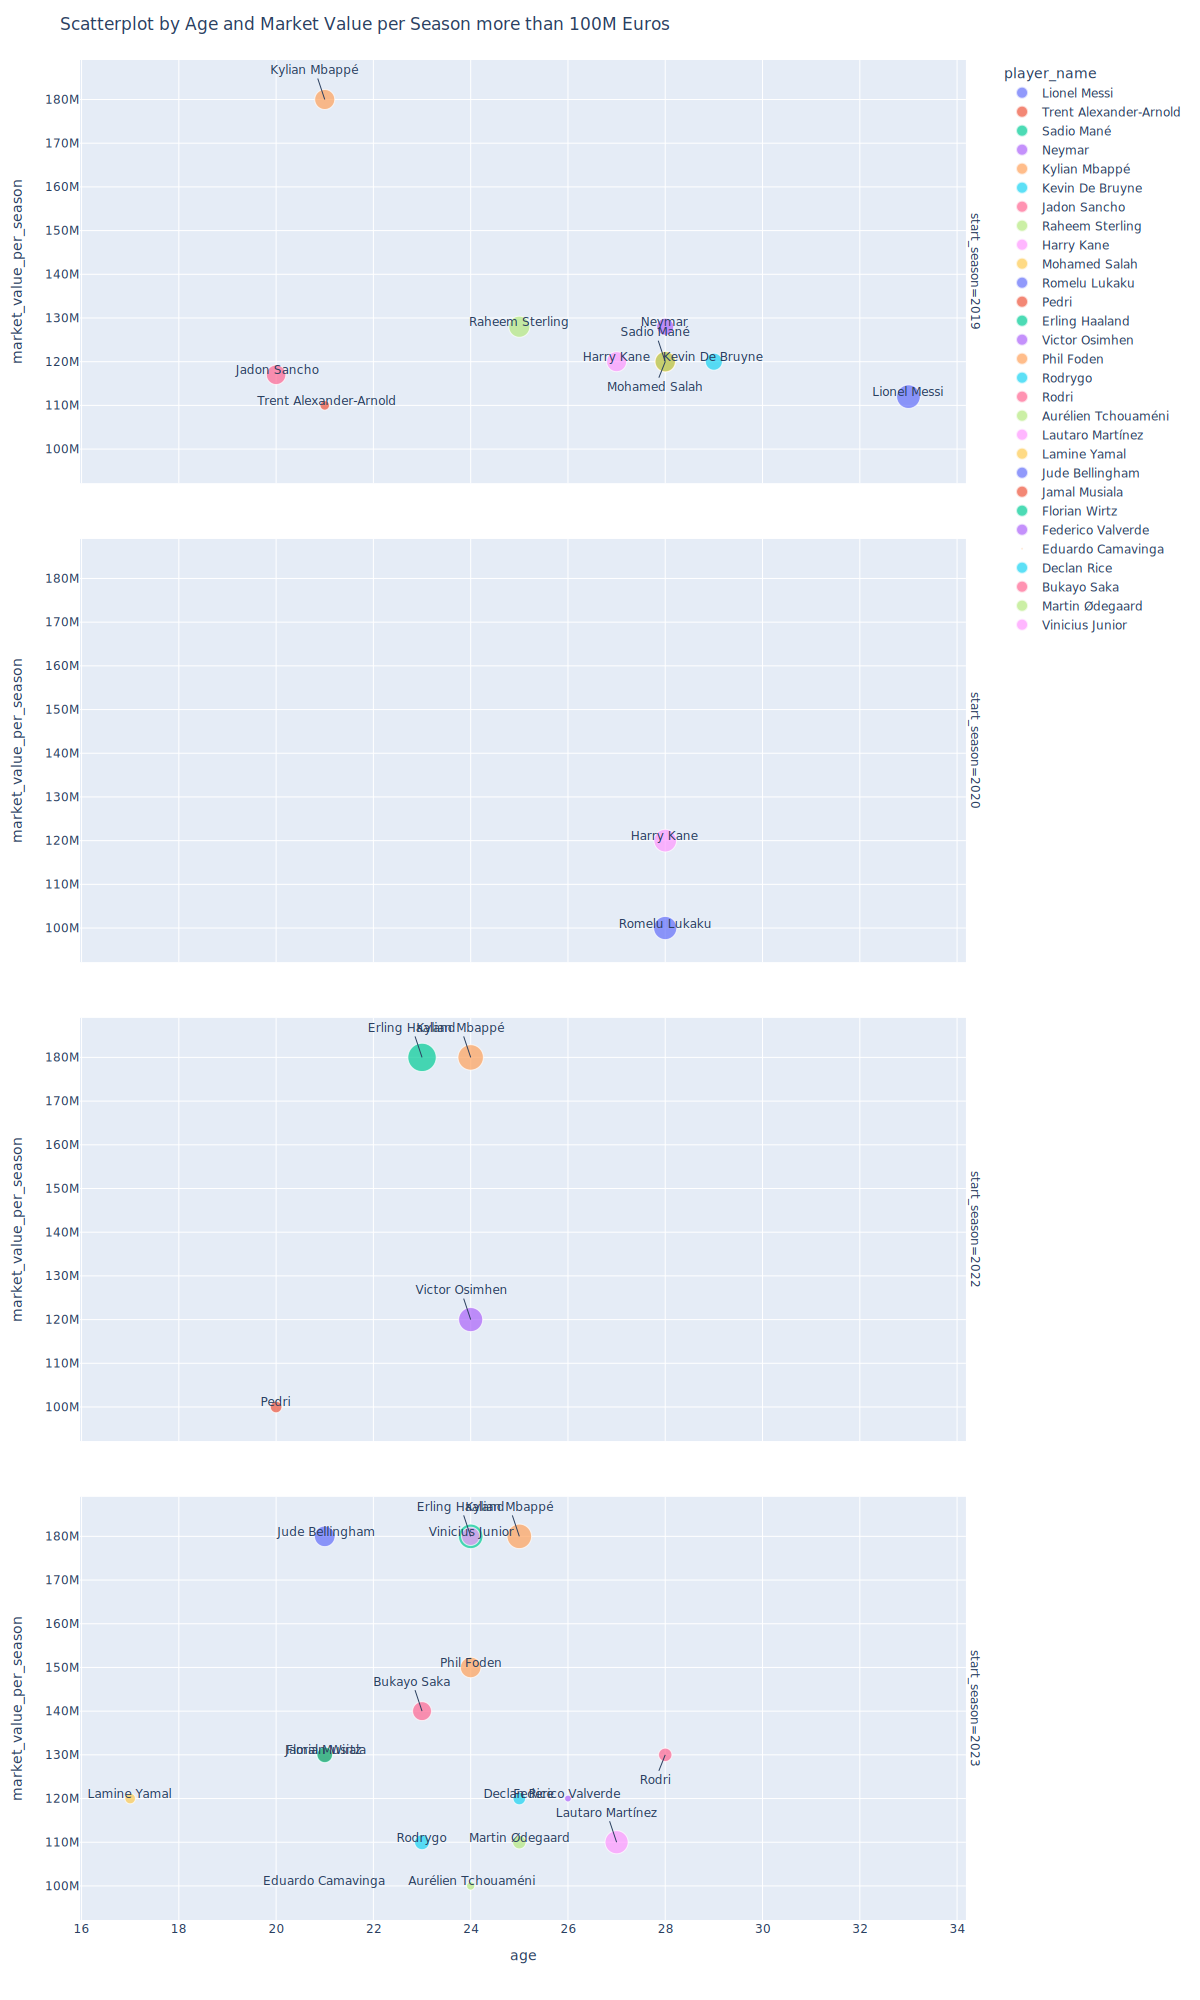

In [63]:
# 나이에 따른 market_value_per_season 시각화

# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100, x="age", y="market_value_per_season",
                 color="player_name", 
                 size="goals", facet_row="start_season",
                #  text="player_name",
                 width=1200, height=2000)

overlapped_names = ["Victor Osimhen", "Erling Haaland", "Kylian Mbappé", "Lautaro Martínez", "Sadio Mané", "Bukayo Saka"]

for i, season in enumerate(more_than_100["start_season"].unique()):
    seasonal = more_than_100[more_than_100["start_season"] == season].reset_index(drop=True)
    i = (-1)*(i-4)
    # print(seasonal)
    for j in range(seasonal.shape[0]):
        # print(seasonal.loc[j, "goals"])
            if seasonal.loc[j, "player_name"] in overlapped_names:
                fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "market_value_per_season"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ay=-30,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                
            elif seasonal.loc[j, "player_name"] in ["Rodri", "Mohamed Salah"]:
                                 fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "market_value_per_season"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    # ax = 25,
                                    ay=25,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)

            else:
                fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "market_value_per_season"],
                                   text=seasonal.loc[j, "player_name"],
                                   # xanchor="left",
                                   # yanchor="bottom",
                                   showarrow=False,
                                   yshift=5,
                                   #    arrowhead=0,
                                   row=i, col=1)

fig.update_layout(title_text="Scatterplot by Age and Market Value per Season more than 100M Euros")
# fig.update_traces(textposition="top center")
fig.show()

## EDA 정리

- 데이터 특징
    - 다양한 컬럼에서 많은 이상치 존재
        - 그러나 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라지게 나타난다
    - 결론 : 이상치 따로 처리하지 않음

- 상관관계
    - 다중 공선성 체크
    - 상관관계 높은 컬럼들 존재 → 추후 머신러닝 모델링에 따라 추가 제거 고민

- 컬럼별 분석
    - `goals`, `assists`
        - 19세 ~ 35세 까지 분포가 많다
        - 나이에 따라 비슷하게 이상치 존재
        - 시각화 결과
            - 시즌별 (5년간) 득점, 어시스트 특화된 순수들이 대다수
            - 시즌에 따라 간혹, 득점, 어시스트 전부 다 많이 기록하는 선수들 존재한다 (Mbappe, Messi 등)
    - `market_value_per_season`
        - 나이별 몸값은 시즌에 따라 보통 비슷하게 나타난다
            - outlier : 2023 시즌 16세 → Lamine Yamal
        - 몸값 `100M 유로` 넘는 선수들 (고가의 선수)만 따로 한번 더 시각화
            - `goals`, `assists`
                - 몸값 높은 선수들은 보통 득점이 많거나 어시스트가 많다
                    - 간혹 둘 다 높은 선수도 존재
            - `goals` + `assists` 합산한 공격포인트 확인
                - 공격포인트 높은 선수가 비싸다
                - 하지만 비슷한 공격포인트를 기록해도 몸값이 차이나는 선수들 존재
        - 포지션별 몸값은 `Left Winger`가 가장 높다
            - 2번째는 `Second Striker`, 3번째는 `Attacking Midfield`, 마지막은 `Goalkeeper`
    - `age`
        - 시즌별 전체 선수, 몸값 20M 유로 넘는 선수, 몸값 100M 유로 넘는 선수 분포 비교 → 분포 비슷하다
        - 몸값 `100M 유로` 넘는 선수들 (고가의 선수)만 따로 한번 더 시각화
            - `age`, `goals` + `assists` 합산한 공격포인트
                - 시즌별로 나이에 따라 공격포인트가 증가하는 모습을 보임
                - 포지션에 따라 공격포인트가 적을 수도 있음 (ex. Rice, Rodri : Defensive Midfield)
            - `age`, `market_value_per_season`
                - 시간이 지날 수록 나이 어린 선수들이 주로 높은 몸값 기록 (Bellingham, Haaland, Mbappe, Vinicius 등)
                    - Outlier : 1920 시즌 Messi        




## EDA 거친 데이터셋 `csv`로 저장

In [64]:
# 상관관계 높은 컬럼 ("yellow_cards", "red_cards") 삭제한 데이터셋 
df_deleted = df.drop(columns=["yellow_cards", "red_cards"], axis="columns")
df_deleted.head()

player_name start_season  goals  assists  minutes_played  \
0   Aaron Connolly         2019      3        2            1261   
1   Aaron Connolly         2020      2        1             791   
2   Aaron Connolly         2021      0        0             155   
3  Aaron Cresswell         2019      3        0            2730   
4  Aaron Cresswell         2020      0        8            3172   

  competition_code date_of_birth  age        position       current_club_name  \
0   premier-league    2000-01-28   20  Centre-Forward  Brighton & Hove Albion   
1   premier-league    2000-01-28   21  Centre-Forward  Brighton & Hove Albion   
2   premier-league    2000-01-28   22  Centre-Forward  Brighton & Hove Albion   
3   premier-league    1989-12-15   30       Left-Back         West Ham United   
4   premier-league    1989-12-15   31       Left-Back         West Ham United   

   market_value_per_season  country   foot  height_in_cm  
0                4000000.0  Ireland  right         174.0  
1                7000000.0  Ireland  right         174.0  
2                6000000.0  Ireland  right         174.0  
3                6500000.0  England   left         170.0  
4                5000000.0  England   left         170.0

In [65]:
# 상관관계 높은 컬럼 ("yellow_cards", "red_cards") 삭제한 데이터셋을 df_eda.csv로 저장
df_deleted.to_csv("data/df_eda.csv", index=False)

In [66]:
# 컬럼 삭제하지 않은 데이터셋을 df_eda_no_del.csv로 저장
df.to_csv("data/df_eda_no_del.csv", index=False)